# Importing Modules

In [58]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt # for visualisation
from matplotlib.dates import DateFormatter
import seaborn as sns   # for visualisation

# Importing Data

In [59]:
df = pd.read_csv("../Data/Preprocessed/preprocessed_railway.csv")

# Journey Characteristics and  Operational Performance

In [60]:
print("Number of Transactions:", df['Transaction ID'].nunique())
print("Number of Routes:", df['Route'].nunique())
print("Number of Departure Stations:", df['Departure Station'].nunique())
print("Number of Arrival Destinations:", df['Arrival Destination'].nunique())
all_stations = pd.concat([df['Departure Station'], df['Arrival Destination']])
print("Number of Stations:", all_stations.nunique())

Number of Transactions: 31653
Number of Routes: 65
Number of Departure Stations: 12
Number of Arrival Destinations: 32
Number of Stations: 32


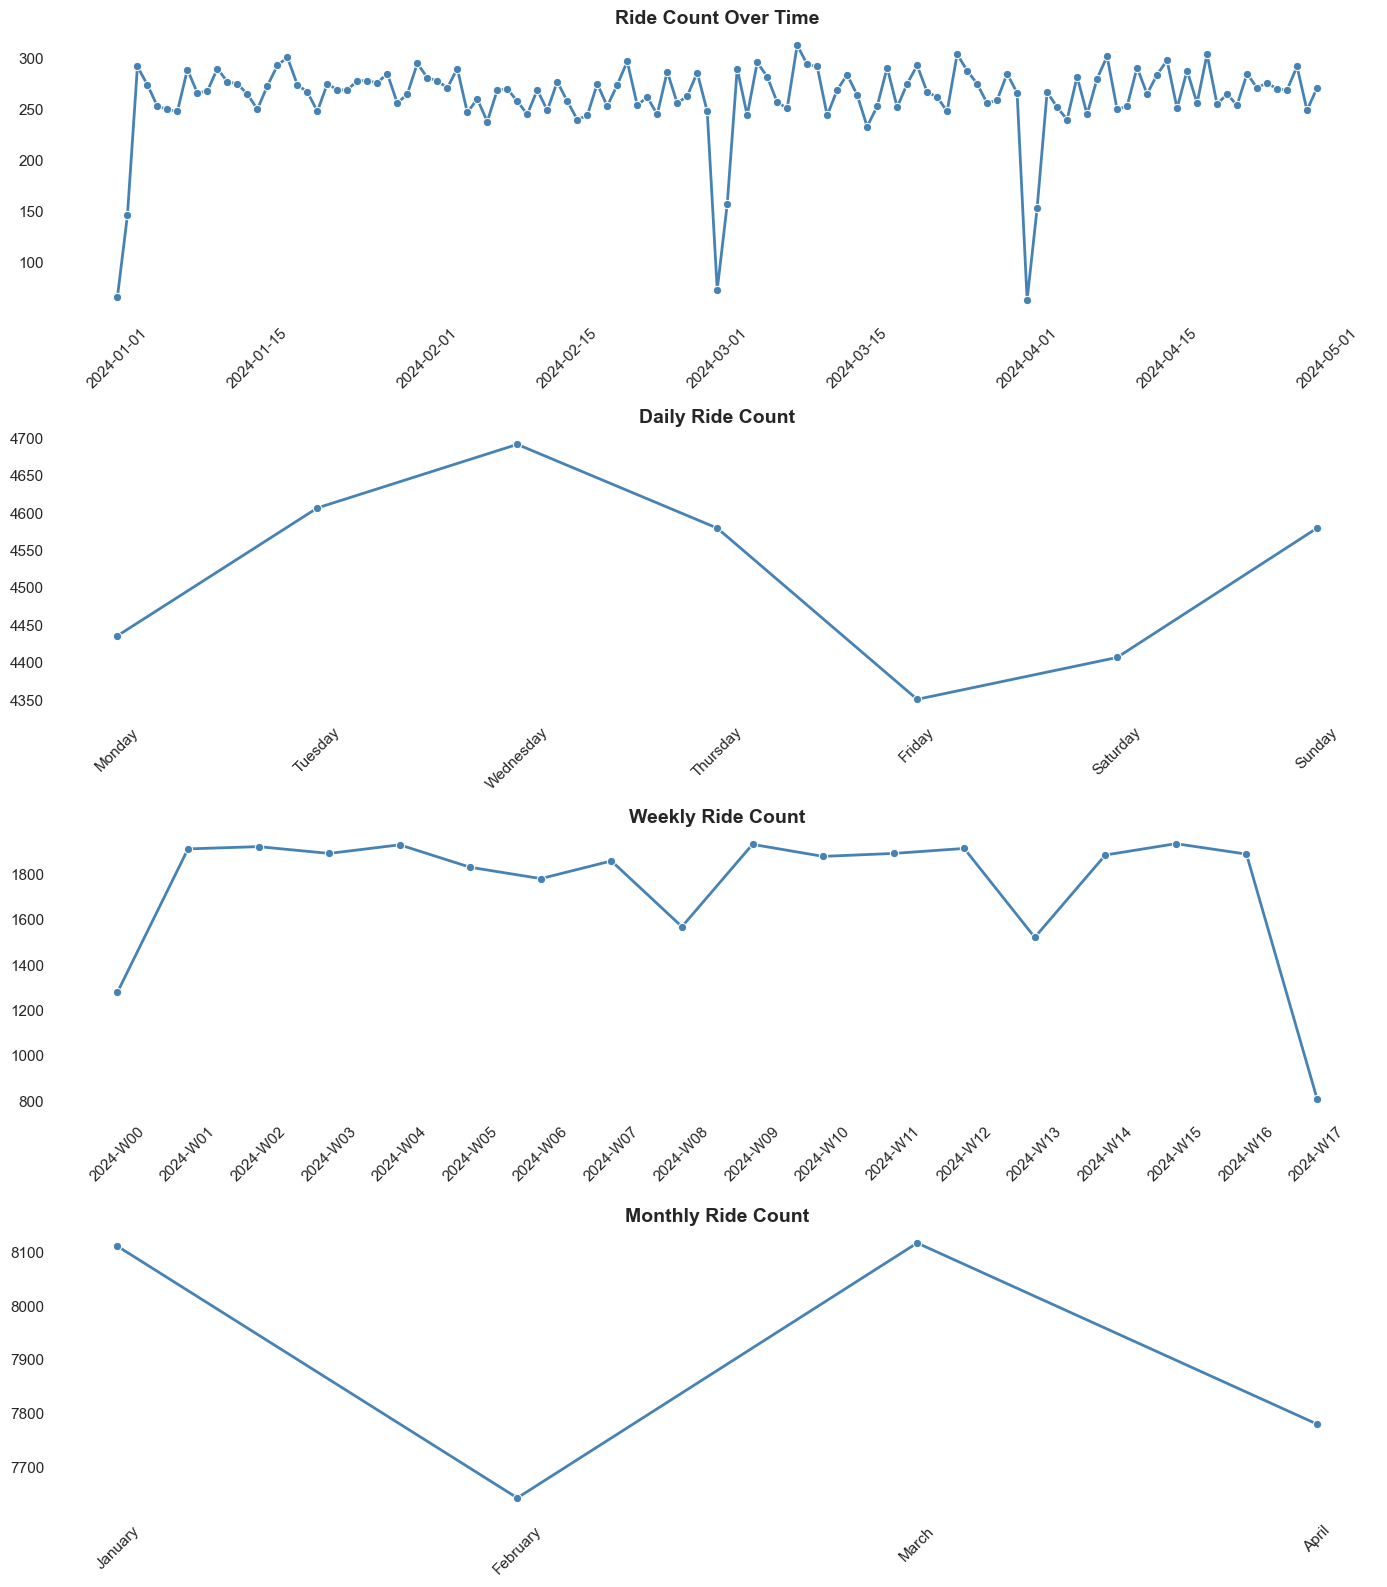

In [61]:
# Ensure 'Departure Timestamp' is in datetime format
df['Departure Timestamp'] = pd.to_datetime(df['Departure Timestamp'])
df['Departure Date'] = pd.to_datetime(df['Departure Date'])

# Extract the day and month from the 'Departure Timestamp'
df['Departure Week'] = df['Departure Timestamp'].dt.strftime('%Y-W%U')
df['Departure Month'] = df['Departure Timestamp'].dt.strftime('%B')

# Group by date and count rides
ride_counts = df.groupby(df['Departure Date'].dt.date).size().reset_index(name='Count')
ride_counts['Departure Date'] = pd.to_datetime(ride_counts['Departure Date'])

# Group by 'Departure Day' and count the number of rides
daily_ride_count = df.groupby('Departure Weekday').size().reset_index(name='Ride Count')

# Group by 'Departure Week' and count the number of rides
weekly_ride_count = df.groupby('Departure Week').size().reset_index(name='Ride Count')

# Group by 'Departure Month' and count the number of rides
monthly_ride_count = df.groupby('Departure Month').size().reset_index(name='Ride Count')

# Sort by timestamp
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_ride_count['Departure Weekday'] = pd.Categorical(
    daily_ride_count['Departure Weekday'], categories=weekday_order, ordered=True
)

weekly_ride_count = weekly_ride_count.sort_values('Departure Week')

# Sort the months in chronological order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

monthly_ride_count['Departure Month'] = pd.Categorical(
    monthly_ride_count['Departure Month'], categories=month_order, ordered=True
)
monthly_ride_count = monthly_ride_count.sort_values('Departure Month')

# Find global min and max for standardized y-axis
global_min = min(
    ride_counts['Count'].min(),
    daily_ride_count['Ride Count'].min(),
    weekly_ride_count['Ride Count'].min(),
    monthly_ride_count['Ride Count'].min()
)
global_max = max(
    ride_counts['Count'].max(),
    daily_ride_count['Ride Count'].max(),
    weekly_ride_count['Ride Count'].max(),
    monthly_ride_count['Ride Count'].max()
)

# Add some padding to the y-axis limits
#y_padding = (global_max - global_min) * 0.05
#y_min = global_min - y_padding
#y_max = global_max + y_padding

# Plot all four ride counts
plt.figure(figsize=(14, 16))

# Plot ride count over time (first subplot)
ax0 = plt.subplot(4, 1, 1)
sns.lineplot(x='Departure Date', y='Count', data=ride_counts, marker='o', color='steelblue', linewidth=2)
plt.title('Ride Count Over Time', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
#plt.ylim(y_min, y_max)
date_format = DateFormatter("%Y-%m-%d")
ax0.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.grid(False)

# Plot the daily ride count
ax1 = plt.subplot(4, 1, 2)
sns.lineplot(data=daily_ride_count, x='Departure Weekday', y='Ride Count', marker='o', color='steelblue', linewidth=2)
plt.title('Daily Ride Count', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
#plt.ylim(y_min, y_max)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.grid(False)

# Plot the weekly ride count
ax2 = plt.subplot(4, 1, 3)
sns.lineplot(data=weekly_ride_count, x='Departure Week', y='Ride Count', marker='o', color='steelblue', linewidth=2)
plt.title('Weekly Ride Count', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
#plt.ylim(y_min, y_max)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.grid(False)

# Plot the Monthly ride count
ax3 = plt.subplot(4, 1, 4)
sns.lineplot(data=monthly_ride_count, x='Departure Month', y='Ride Count', marker='o', color='steelblue', linewidth=2)
plt.title('Monthly Ride Count', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
#plt.ylim(y_min, y_max)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.grid(False)

plt.tight_layout()
plt.show()

## Popular Routes and Stations

In [62]:
# Create the aggregated dataframe grouped by Route

route_analysis = df.groupby('Route').agg(
    RideCount=('Route', 'count'),
    OnTimeCount=('Journey Status', lambda x: (x == 'On Time').sum()),
    DelayedCount=('Journey Status', lambda x: (x == 'Delayed').sum()),
    CancelledCount=('Journey Status', lambda x: (x == 'Cancelled').sum()),
    ScheduledDuration=('Journey Duration', lambda x: x.fillna(0).mean()),
    AvgDelayDuration=('Journey Duration', lambda x: x.fillna(0).mean()),
    MinDelayDuration=('Journey Duration', lambda x: x.fillna(0).min()),
    MaxDelayDuration=('Journey Duration', lambda x: x.fillna(0).max()),
    StdDevDelayDuration=('Journey Duration', lambda x: x.fillna(0).std()),
    TotalRevenue=('Price', 'sum'),
    AvgPrice=('Price', 'mean'),
    TotalRefundRequests=('Refund Request', lambda x: (x == 'Yes').sum())
).reset_index()

# Calculate Price for refund requests (Revenue Loss)
refund_revenue = df[df['Refund Request'] == 'Yes'].groupby('Route')['Price'].sum().reset_index()
refund_revenue.columns = ['Route', 'RevenueLoss']

# Merge refund revenue back to main dataframe
route_analysis = route_analysis.merge(refund_revenue, on='Route', how='left')
route_analysis['RevenueLoss'] = route_analysis['RevenueLoss'].fillna(0)

# Calculate percentages
total_rides = route_analysis['RideCount'].sum()
total_revenue = route_analysis['TotalRevenue'].sum()

route_analysis['PercentOfTotalRides'] = (route_analysis['RideCount'] * 100.0 / total_rides).round(2)
route_analysis['OnTimePercent'] = (route_analysis['OnTimeCount'] * 100.0 / route_analysis['RideCount']).round(2)
route_analysis['DelayedPercent'] = (route_analysis['DelayedCount'] * 100.0 / route_analysis['RideCount']).round(2)
route_analysis['CancelledPercent'] = (route_analysis['CancelledCount'] * 100.0 / route_analysis['RideCount']).round(2)
route_analysis['PercentOfTotalRevenue'] = (route_analysis['TotalRevenue'] * 100.0 / total_revenue).round(2)

# Reorder columns to match SQL query output
route_analysis = route_analysis[[
    'Route',
    'RideCount',
    'PercentOfTotalRides',
    'OnTimeCount',
    'OnTimePercent',
    'DelayedCount',
    'DelayedPercent',
    'CancelledCount',
    'CancelledPercent',
    'ScheduledDuration',
    'AvgDelayDuration',
    'MinDelayDuration',
    'MaxDelayDuration',
    'StdDevDelayDuration',
    'TotalRevenue',
    'PercentOfTotalRevenue',
    'AvgPrice',
    'TotalRefundRequests',
    'RevenueLoss'
]]

# Sort by RideCount descending
route_analysis = route_analysis.sort_values('RideCount', ascending=False).reset_index(drop=True)

route_analysis

Route  RideCount  \
0   Manchester Piccadilly _TO_ Liverpool Lime Street       4628   
1           London Euston _TO_ Birmingham New Street       4209   
2                       London Kings Cross _TO_ York       3922   
3                     London Paddington _TO_ Reading       3873   
4       London St Pancras _TO_ Birmingham New Street       3471   
..                                               ...        ...   
60             Manchester Piccadilly _TO_ Warrington         15   
61                   York _TO_ Liverpool Lime Street         15   
62                      York _TO_ Edinburgh Waverley         15   
63                               York _TO_ Wakefield         15   
64  Liverpool Lime Street _TO_ Birmingham New Street         14   

    PercentOfTotalRides  OnTimeCount  OnTimePercent  DelayedCount  \
0                 14.62         3984          86.08           354   
1                 13.30         3756          89.24           242   
2                 12.39         3593          91.61           131   
3                 12.24         3521          90.91            66   
4                 10.97         3198          92.13             0   
..                  ...          ...            ...           ...   
60                 0.05           15         100.00             0   
61                 0.05           14          93.33             0   
62                 0.05           15         100.00             0   
63                 0.05            0           0.00            15   
64                 0.04           12          85.71             0   

    DelayedPercent  CancelledCount  CancelledPercent  ScheduledDuration  \
0             7.65             290              6.27               30.0   
1             5.75             211              5.01               80.0   
2             3.34             198              5.05              110.0   
3             1.70             286              7.38               60.0   
4             0.00             273              7.87               80.0   
..             ...             ...               ...                ...   
60            0.00               0              0.00               20.0   
61            0.00               1              6.67               90.0   
62            0.00               0              0.00              150.0   
63          100.00               0              0.00               25.0   
64            0.00               2             14.29               90.0   

    AvgDelayDuration  MinDelayDuration  MaxDelayDuration  StdDevDelayDuration  \
0               30.0              30.0              30.0                  0.0   
1               80.0              80.0              80.0                  0.0   
2              110.0             110.0             110.0                  0.0   
3               60.0              60.0              60.0                  0.0   
4               80.0              80.0              80.0                  0.0   
..               ...               ...               ...                  ...   
60              20.0              20.0              20.0                  0.0   
61              90.0              90.0              90.0                  0.0   
62             150.0             150.0             150.0                  0.0   
63              25.0              25.0              25.0                  0.0   
64              90.0              90.0              90.0                  0.0   

    TotalRevenue  PercentOfTotalRevenue   AvgPrice  TotalRefundRequests  \
0          17310                   2.33   3.740277                   91   
1          50349                   6.79  11.962224                   83   
2         183193                  24.69  46.709077                   82   
3          65368                   8.81  16.877872                   89   
4          52869                   7.13  15.231634                   64   
..           ...                    ...        ...                  ...   
60            

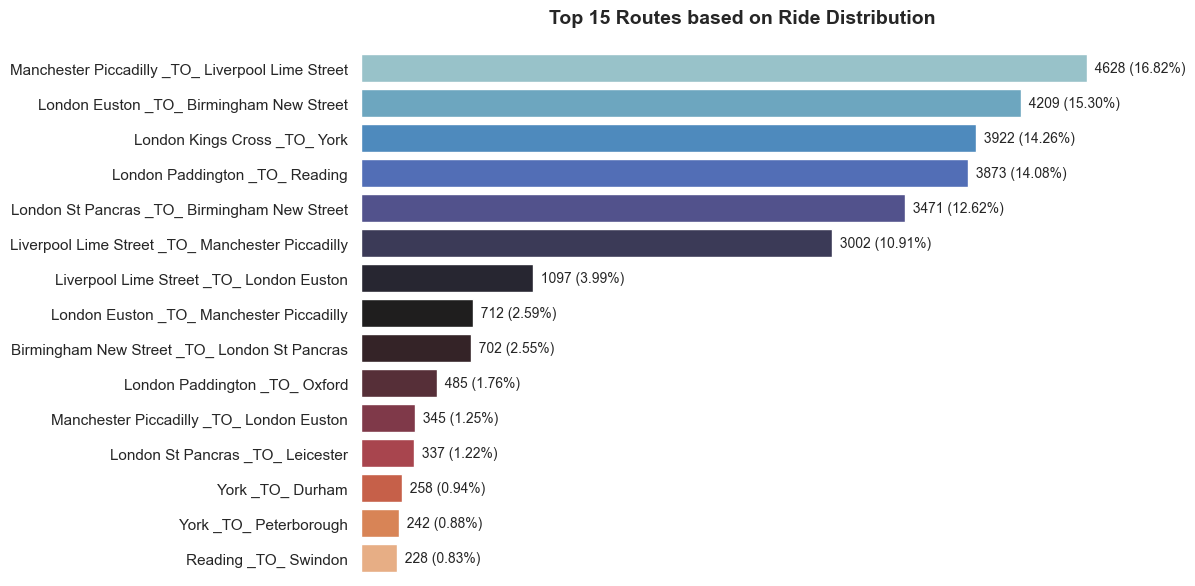

In [63]:
# Count of rides per route
route_counts = df['Route'].value_counts().nlargest(15)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=route_counts.values, y=route_counts.index, orient='h', 
                  hue=route_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Top 15 Routes based on Ride Distribution', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = route_counts.sum()
for i, (idx, value) in enumerate(route_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.2f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

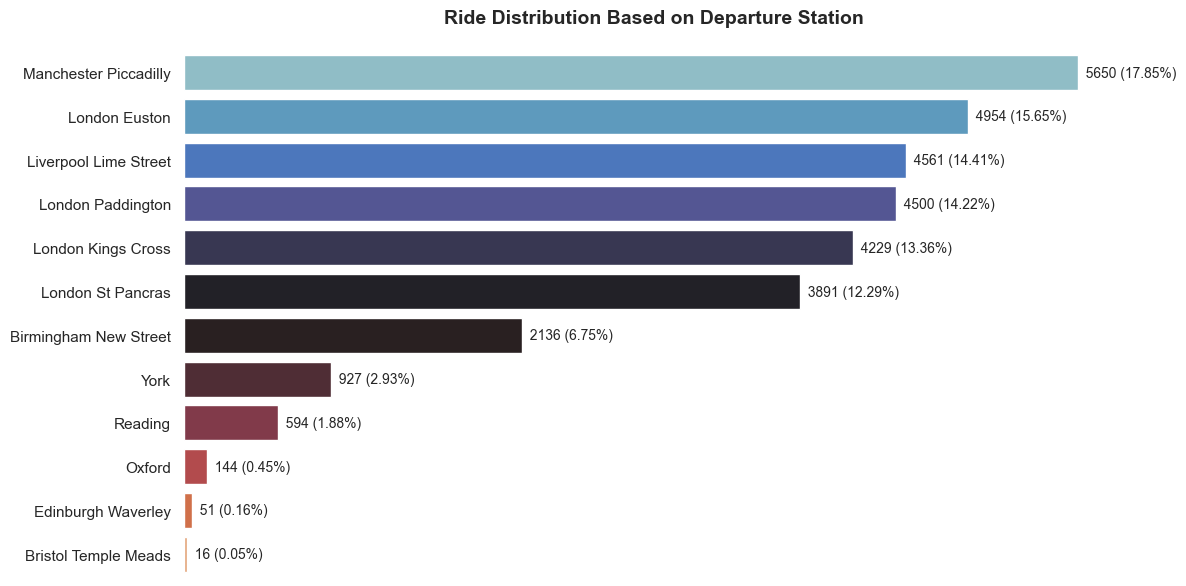

In [64]:
# Count of rides per station
station_counts = df['Departure Station'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Ride Distribution Based on Departure Station', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.2f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

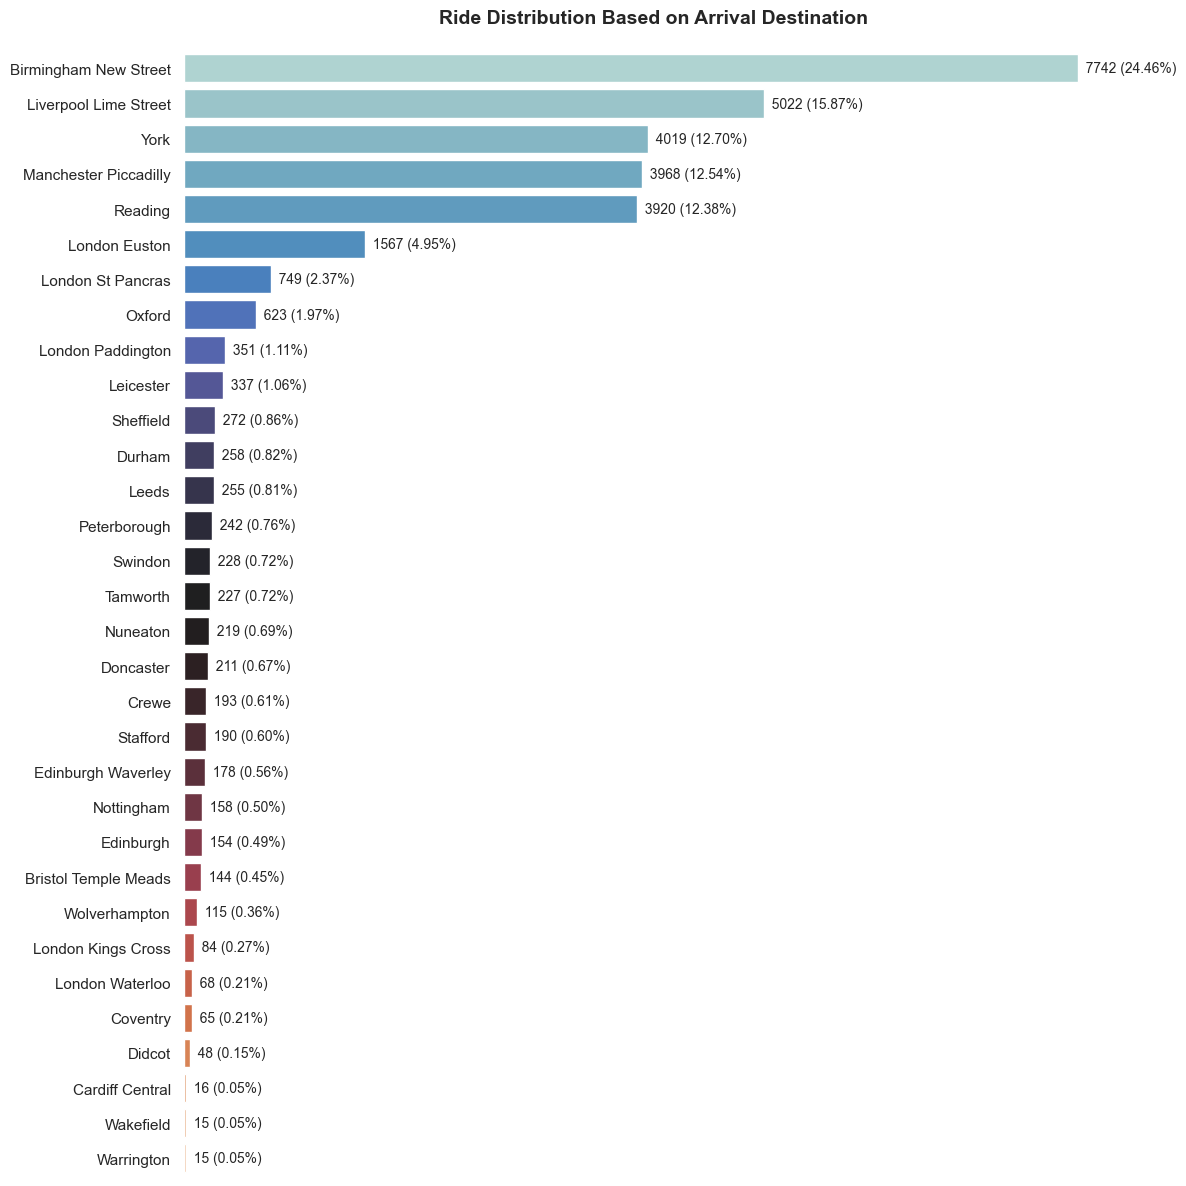

In [65]:
# Count of rides per station
station_counts = df['Arrival Destination'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, 12))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Ride Distribution Based on Arrival Destination', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.2f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

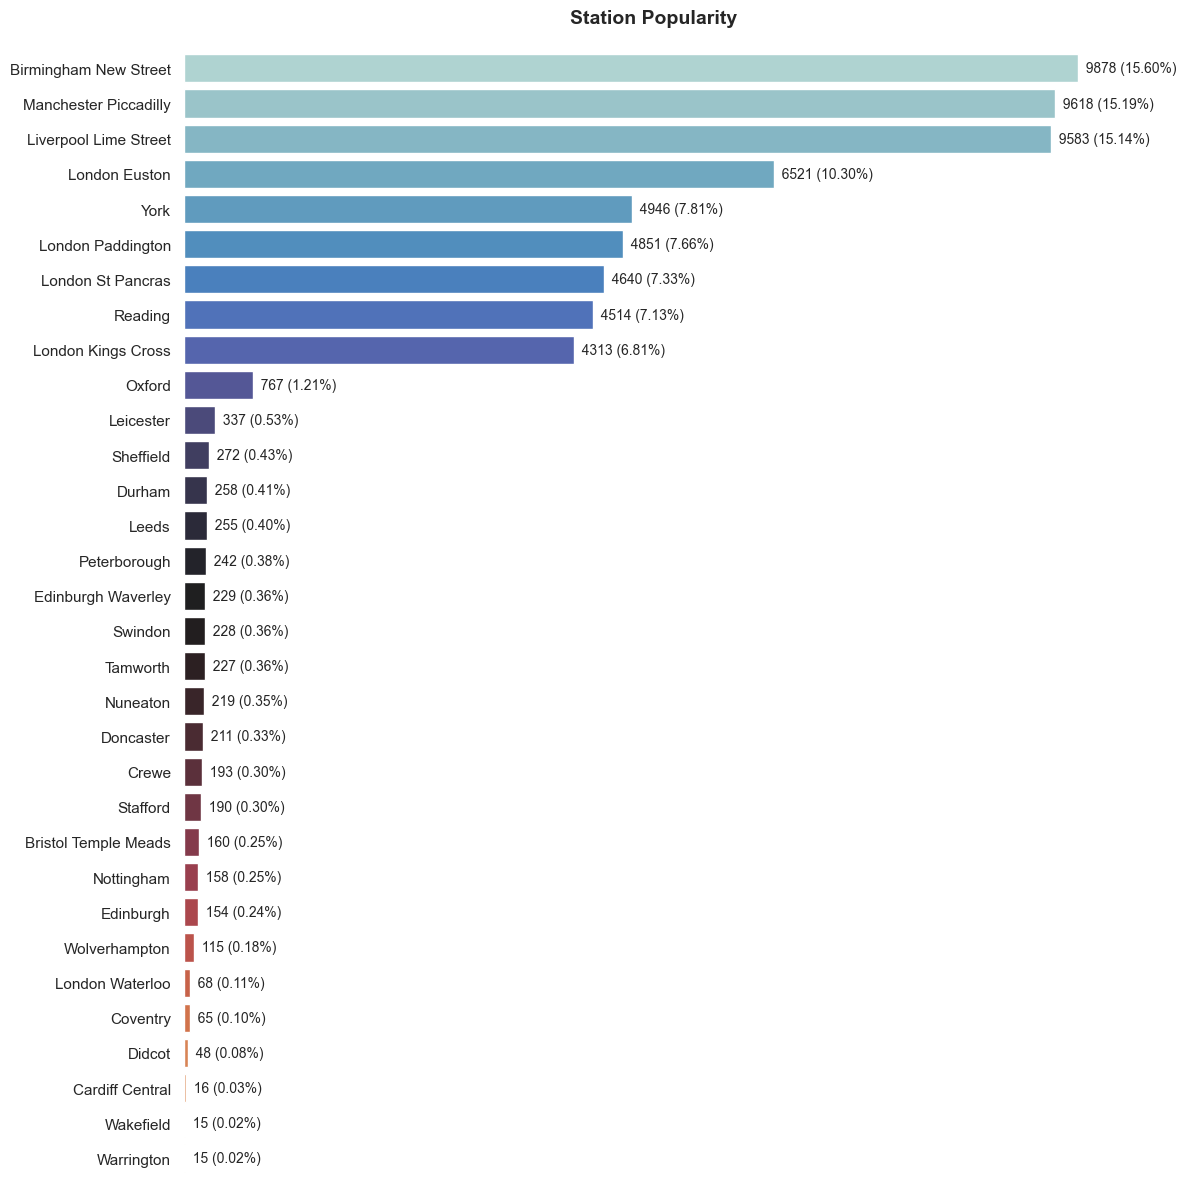

In [66]:
# Combine departure and arrival stations
all_stations = pd.concat([df['Departure Station'], df['Arrival Destination']])
station_counts = all_stations.value_counts().sort_values(ascending=False)

# Plot as a bar chart
plt.figure(figsize=(12, 12))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Station Popularity', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.2f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

## Departure and Arrival Patterns

Peak hours are between 6-8 AM and 4-6 PM

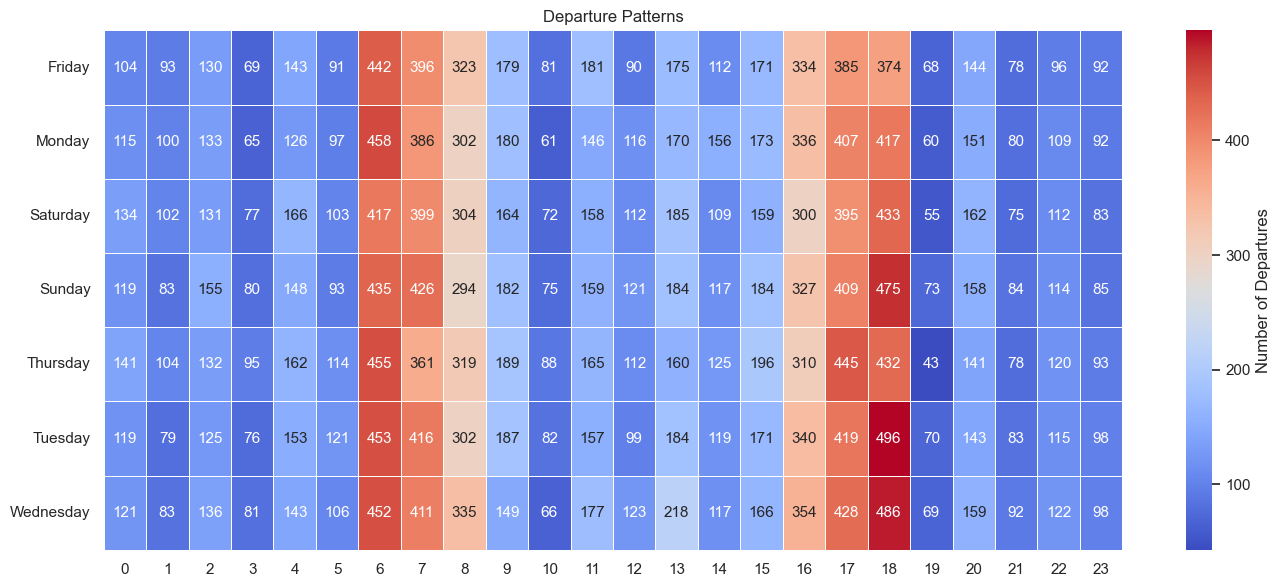

In [67]:
# Convert 'Departure Time' to hour with explicit format
df['Departure Hour'] = pd.to_datetime(df['Departure Time'], format='%H:%M:%S', errors='coerce').dt.hour

# Create a pivot table
pivot_table = df.pivot_table(values='Transaction ID', 
                               index='Departure Weekday', 
                               columns='Departure Hour', 
                               aggfunc='count', 
                               fill_value=0)

# Ensure all values are integers
pivot_table = pivot_table.astype(int)

# Plot the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='d', cbar_kws={'label': 'Number of Departures'}, linewidths=0.5)
plt.title('Departure Patterns')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

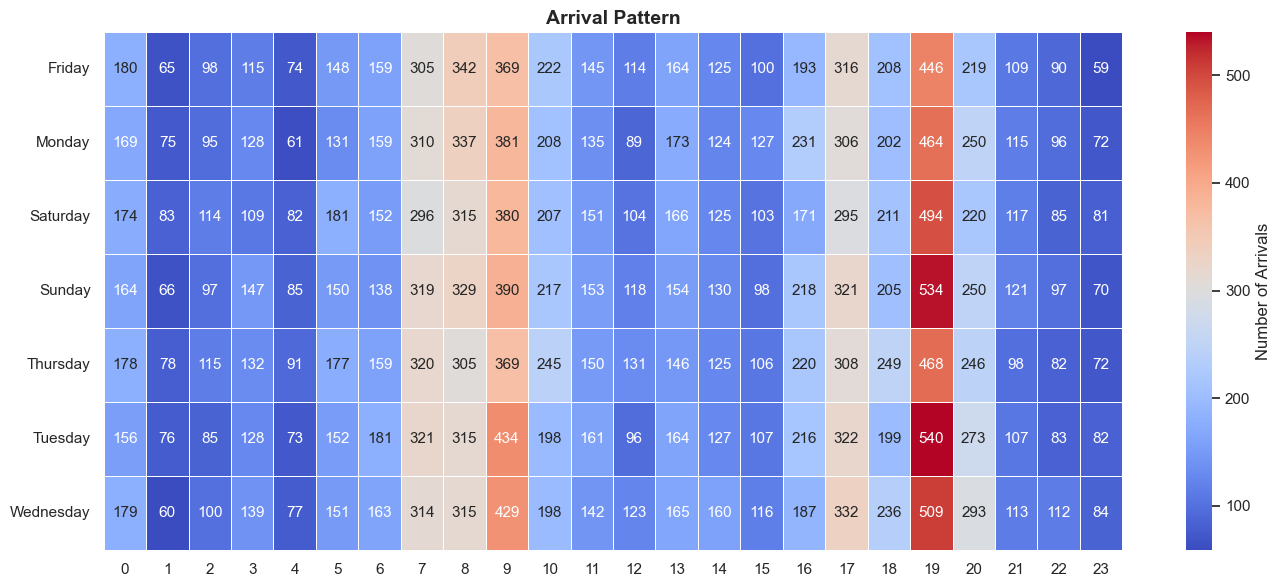

In [68]:
# Convert 'Arrival Time' to hour with explicit format
df['Arrival Hour'] = pd.to_datetime(df['Arrival Time'], format='%H:%M:%S', errors='coerce').dt.hour

# Create Arrival Weekday from Arrival Timestamp
df['Arrival Weekday'] = pd.to_datetime(df['Arrival Timestamp']).dt.day_name()

# Create a pivot table
pivot_table = df.pivot_table(values='Transaction ID', 
                               index='Arrival Weekday', 
                               columns='Arrival Hour', 
                               aggfunc='count', 
                               fill_value=0)

# Ensure all values are integers
pivot_table = pivot_table.astype(int)

# Convert column names to integers
pivot_table.columns = pivot_table.columns.astype(int)

# Plot the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='d', 
            cbar_kws={'label': 'Number of Arrivals'}, linewidths=0.5)

plt.title('Arrival Pattern', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

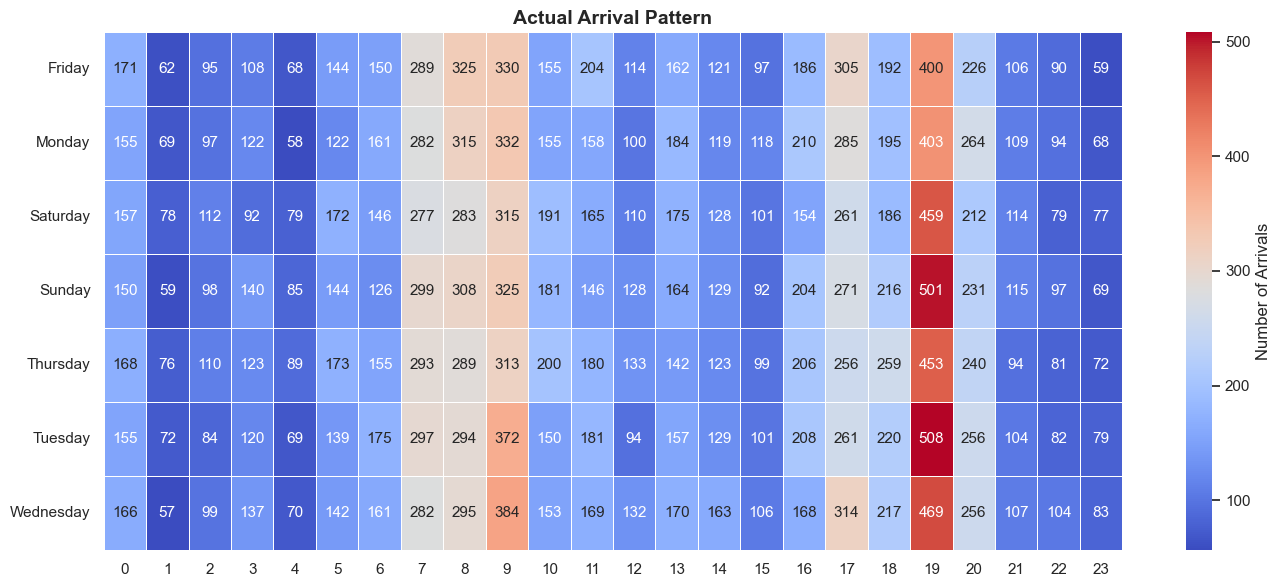

In [69]:
# Convert 'Actual Arrival Time' to hour with explicit format
df['Actual Arrival Hour'] = pd.to_datetime(df['Actual Arrival Time'], format='%H:%M:%S', errors='coerce').dt.hour

# Create Actual Arrival Weekday from Actual Arrival Timestamp
df['Actual Arrival Weekday'] = pd.to_datetime(df['Actual Arrival Timestamp']).dt.day_name()

# Create a pivot table
pivot_table = df.pivot_table(values='Transaction ID', 
                               index='Actual Arrival Weekday', 
                               columns='Actual Arrival Hour', 
                               aggfunc='count', 
                               fill_value=0)

# Ensure all values are integers
pivot_table = pivot_table.astype(int)

# Convert column names to integers
pivot_table.columns = pivot_table.columns.astype(int)

# Plot the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='d', 
            cbar_kws={'label': 'Number of Arrivals'}, linewidths=0.5)

plt.title('Actual Arrival Pattern', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

## Comprehensive Journey duration Statistics by Route

In [70]:
route_duration_stats = df.groupby('Route').agg({
    'Journey Duration': ['count', 'min', 'max', 'mean', 'median', 'std'],
    'Actual Journey Duration': ['min', 'max', 'mean', 'median', 'std'],
    'Delay Duration': ['mean', 'median', 'max']
}).round(2)

# Flatten column names
route_duration_stats.columns = [
    'Count',
    'Scheduled Min', 'Scheduled Max', 'Scheduled Mean', 'Scheduled Median', 'Scheduled Std',
    'Actual Min', 'Actual Max', 'Actual Mean', 'Actual Median', 'Actual Std',
    'Avg Delay', 'Median Delay', 'Max Delay'
]

# Reset index
route_duration_stats = route_duration_stats.reset_index()

# Calculate total journeys for percentage
total_rides = route_duration_stats['Count'].sum()

# Add percentage column right after Count
route_duration_stats['Percentage'] = (
    (route_duration_stats['Count'] / total_rides) * 100
).round(2)

# Count delayed journeys per route
delayed_counts = df[df['Journey Status'] == 'Delayed'].groupby('Route').size().reset_index(name='Delayed Count')

# Merge delayed counts into route_duration_stats
route_duration_stats = route_duration_stats.merge(delayed_counts, on='Route', how='left')
route_duration_stats['Delayed Count'] = route_duration_stats['Delayed Count'].fillna(0).astype(int)

# Calculate percentage of delayed journeys
route_duration_stats['Delayed Percentage'] = (
    (route_duration_stats['Delayed Count'] / route_duration_stats['Count']) * 100
).round(2)

# Add calculated columns for insights
route_duration_stats['Mean Delay %'] = (
    (route_duration_stats['Avg Delay'] / route_duration_stats['Scheduled Mean']) * 100
).round(2)

# Reorder columns to the desired order
cols_order = [
    'Route',
    'Count',
    'Percentage',
    'Delayed Count',
    'Delayed Percentage',
    'Scheduled Min', 'Scheduled Max', 'Scheduled Mean', 'Scheduled Median', 'Scheduled Std',
    'Actual Min', 'Actual Max', 'Actual Mean', 'Actual Median', 'Actual Std',
    'Avg Delay', 'Median Delay', 'Max Delay',
    'Mean Delay %'
]

route_duration_stats = route_duration_stats[cols_order]

# Sort by journey count or mean delay
route_duration_stats = route_duration_stats.sort_values('Count', ascending=False)

route_duration_stats

Route  Count  Percentage  \
40  Manchester Piccadilly _TO_ Liverpool Lime Street   4628       14.62   
24          London Euston _TO_ Birmingham New Street   4209       13.30   
30                      London Kings Cross _TO_ York   3922       12.39   
35                    London Paddington _TO_ Reading   3873       12.24   
36      London St Pancras _TO_ Birmingham New Street   3471       10.97   
..                                               ...    ...         ...   
47             Manchester Piccadilly _TO_ Warrington     15        0.05   
62                   York _TO_ Liverpool Lime Street     15        0.05   
60                      York _TO_ Edinburgh Waverley     15        0.05   
64                               York _TO_ Wakefield     15        0.05   
16  Liverpool Lime Street _TO_ Birmingham New Street     14        0.04   

    Delayed Count  Delayed Percentage  Scheduled Min  Scheduled Max  \
40            354                7.65           30.0           30.0   
24            242                5.75           80.0           80.0   
30            131                3.34          110.0          110.0   
35             66                1.70           60.0           60.0   
36              0                0.00           80.0           80.0   
..            ...                 ...            ...            ...   
47              0                0.00           20.0           20.0   
62              0                0.00           90.0           90.0   
60              0                0.00          150.0          150.0   
64             15              100.00           25.0           25.0   
16              0                0.00           90.0           90.0   

    Scheduled Mean  Scheduled Median  Scheduled Std  Actual Min  Actual Max  \
40            30.0              30.0            0.0        30.0       209.0   
24            80.0              80.0            0.0        80.0       179.0   
30           110.0             110.0            0.0       110.0       153.0   
35            60.0              60.0            0.0        60.0       118.0   
36            80.0              80.0            0.0        80.0        80.0   
..             ...               ...            ...         ...         ...   
47            20.0              20.0            0.0        20.0        20.0   
62            90.0              90.0            0.0        90.0        90.0   
60           150.0             150.0            0.0       150.0       150.0   
64            25.0              25.0            0.0        25.0        54.0   
16            90.0              90.0            0.0        90.0        90.0   

    Actual Mean  Actual Median  Actual Std  Avg Delay  Median Delay  \
40        35.48           30.0       22.76       5.48           0.0   
24        83.33           80.0       14.69       3.33           0.0   
30       110.57          110.0        3.66       0.57           0.0   
35        60.66           60.0        5.21       0.66           0.0   
36        80.00           80.0        0.00       0.00           0.0   
..          ...            ...         ...        ...           ...   
47        20.00           20.0        0.00       0.00           0.0   
62        90.00           90.0        0.00       0.00           0.0   
60       150.00          150.0        0.00       0.00           0.0   
64        37.27           39.0        8.92      12.27          14.0   
16        90.00           90.0        0.00       0.00           0.0   

    Max Delay  Mean Delay %  
40      179.0         18.27  
24       99.0          4.16  
30       43.0          0.52  
35       58.0          1.10  
36        0.0          0.00  
..        ...           ...  
47        0.0          0.00  
62        0.0          0.00  
60        0.0          0.00  
64       29.0         49.08  
16        0.0          0.00  

[65 rows x 19 columns]

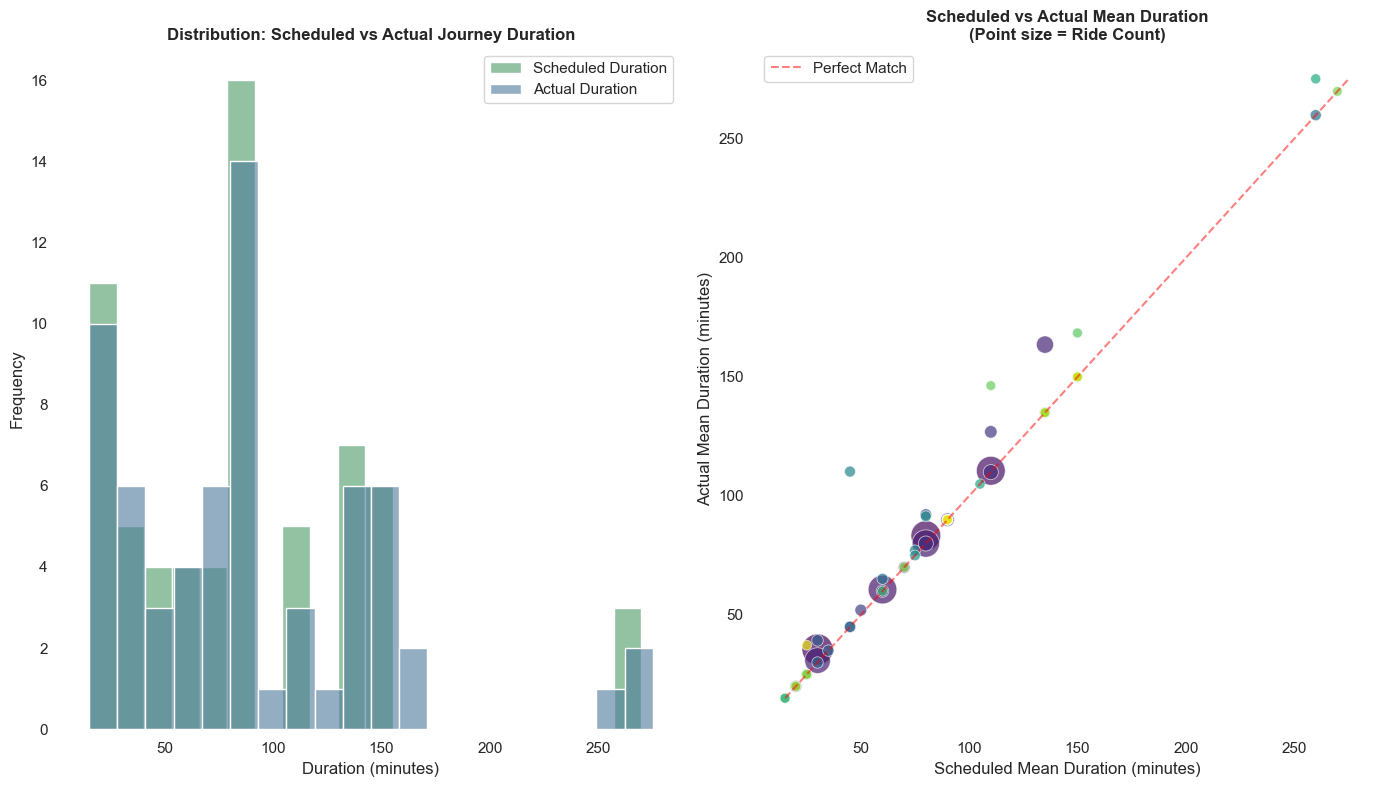

In [71]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Plot 1: Histogram with two overlapping layers (scheduled vs actual duration)
ax1 = plt.subplot(1, 2, 1)
sns.histplot(
    data=route_duration_stats,
    x='Scheduled Mean',
    color="#4b9a65",
    label='Scheduled Duration',
    bins=20,
    kde=False,
    alpha=0.6  # Semi-transparent
)
sns.histplot(
    data=route_duration_stats,
    x='Actual Mean',
    color='#4b799a',
    label='Actual Duration',
    bins=20,
    kde=False,
    alpha=0.6  # Semi-transparent
)
plt.title('Distribution: Scheduled vs Actual Journey Duration', fontsize=12, fontweight='bold')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Plot 2: Scatter plot of scheduled vs actual mean duration with count as size
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x='Scheduled Mean', 
    y='Actual Mean', 
    size='Count',  # Point size represents journey count
    hue='Route', 
    data=route_duration_stats, 
    palette='viridis', 
    legend=False,
    sizes=(50, 500),  # Min and max point sizes
    alpha=0.7
)
plt.title('Scheduled vs Actual Mean Duration\n(Point size = Ride Count)', fontsize=12, fontweight='bold')
plt.xlabel('Scheduled Mean Duration (minutes)')
plt.ylabel('Actual Mean Duration (minutes)')
plt.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Add a diagonal reference line
min_duration = min(route_duration_stats['Scheduled Mean'].min(), route_duration_stats['Actual Mean'].min())
max_duration = max(route_duration_stats['Scheduled Mean'].max(), route_duration_stats['Actual Mean'].max())
ax2.plot([min_duration, max_duration], [min_duration, max_duration], 'r--', alpha=0.5, label='Perfect Match')

# Add a legend for the reference line
ax2.legend(loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

## Journey Status Distrubution

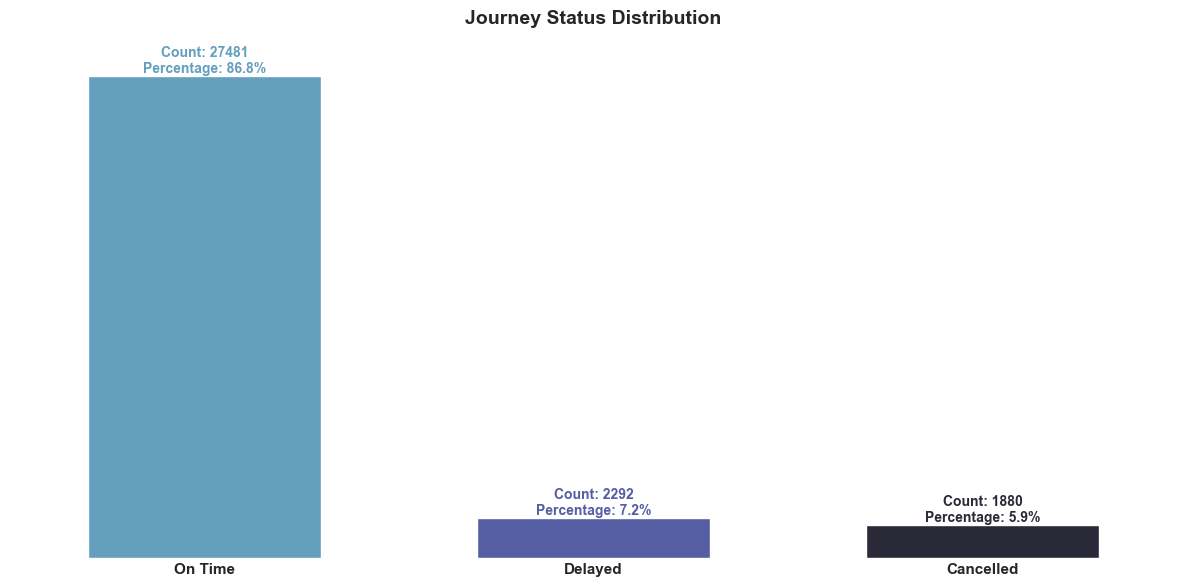

In [72]:
# Set theme and style for better aesthetics
sns.set_theme(style="whitegrid", palette="icefire", font="sans-serif")
plt.rcParams['font.size'] = 11
plt.rcParams['font.weight'] = 'normal'

# Calculating Count and Percent
status_counts = df['Journey Status'].value_counts()
status_percent = df['Journey Status'].value_counts(normalize=True) * 100

# Create a DataFrame for plotting
status_df = pd.DataFrame({
    'Journey Status': status_counts.index,
    'Count': status_counts,
    'Percentage': status_percent
})

# Create figure with better sizing
fig, ax = plt.subplots(figsize=(12, 6))

# Plot with refined styling
sns.barplot(
    x='Journey Status', 
    y='Count', 
    data=status_df, 
    hue='Journey Status',  
    legend=False,
    ax=ax,
    width=0.6
)

# Add count and percentage text inside the bars with better contrast
for idx, row in enumerate(status_df.itertuples()):
    count = row.Count
    percent = row.Percentage
    
    # Get the color of the current bar
    bar_color = ax.patches[idx].get_facecolor()
    
    ax.text(
        idx, 
        count,  # Position at the top of the bar
        f"Count: {count}\nPercentage: {percent:.1f}%", 
        ha='center', 
        va='bottom',  # Align text bottom to bar top
        color=bar_color,  # Match bar color
        fontsize=10,
        fontweight='bold'
    )

# Remove y-axis, ticks, and borders
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Set x-axis ticks and labels properly
ax.set_xticks(range(len(status_df)))
ax.set_xticklabels(status_df['Journey Status'], rotation=0, fontsize=11, fontweight='bold')
ax.tick_params(axis='x', length=0)

# Hide unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add title with better styling
plt.title('Journey Status Distribution', fontsize=14, fontweight='bold', pad=20)

# Adjust layout to fit
plt.tight_layout()

plt.show()

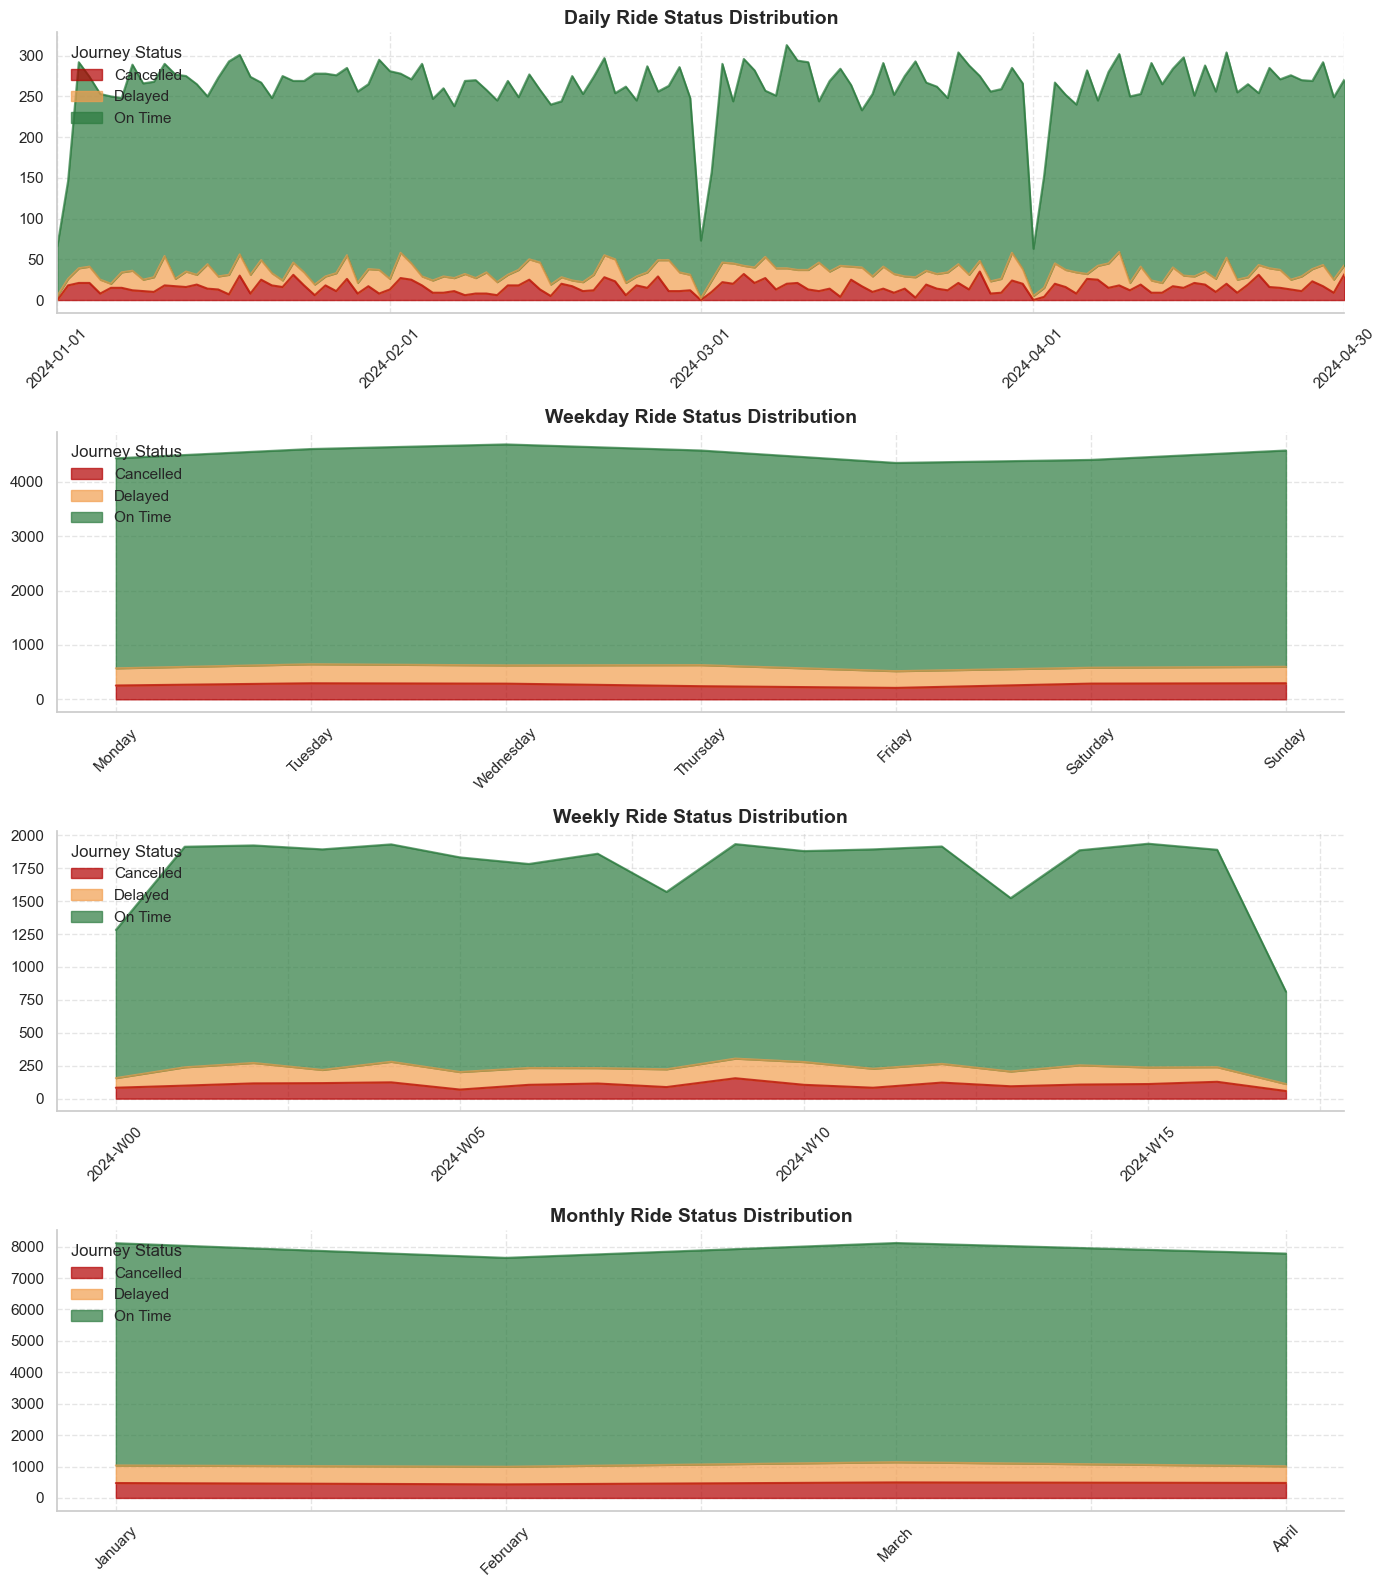

In [73]:
# Ensure 'Departure Timestamp' is in datetime format
df['Departure Timestamp'] = pd.to_datetime(df['Departure Timestamp'])
df['Departure Date'] = pd.to_datetime(df['Departure Date'])

# Extract time periods
df['Departure Week'] = df['Departure Timestamp'].dt.strftime('%Y-W%U')
df['Departure Month'] = df['Departure Timestamp'].dt.strftime('%B')

# Define month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# ===== DAILY STATUS DISTRIBUTION =====
daily_status = df.groupby([df['Departure Date'].dt.date, 'Journey Status']).size().reset_index(name='Count')
daily_status.columns = ['Departure Date', 'Journey Status', 'Count']
daily_status['Departure Date'] = pd.to_datetime(daily_status['Departure Date'])
daily_pivot = daily_status.pivot_table(index='Departure Date', columns='Journey Status', values='Count', fill_value=0)

# ===== WEEKLY STATUS DISTRIBUTION =====
weekly_status = df.groupby(['Departure Week', 'Journey Status']).size().reset_index(name='Count')
weekly_pivot = weekly_status.pivot_table(index='Departure Week', columns='Journey Status', values='Count', fill_value=0)

# ===== MONTHLY STATUS DISTRIBUTION =====
monthly_status = df.groupby(['Departure Month', 'Journey Status']).size().reset_index(name='Count')
monthly_status['Departure Month'] = pd.Categorical(
    monthly_status['Departure Month'], categories=month_order, ordered=True
)
monthly_status = monthly_status.sort_values('Departure Month')
monthly_pivot = monthly_status.pivot_table(index='Departure Month', columns='Journey Status', 
                                           values='Count', fill_value=0, observed=False)

# ===== WEEKDAY STATUS DISTRIBUTION =====
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_status = df.groupby(['Departure Weekday', 'Journey Status']).size().reset_index(name='Count')
weekday_status['Departure Weekday'] = pd.Categorical(
    weekday_status['Departure Weekday'], categories=weekday_order, ordered=True
)
weekday_status = weekday_status.sort_values('Departure Weekday')
weekday_pivot = weekday_status.pivot_table(index='Departure Weekday', columns='Journey Status', 
                                           values='Count', fill_value=0, observed=False)
# Define colors
colors = ["#b30000", "#f29e4e", "#2c7b3f"]

# Create subplots
plt.figure(figsize=(14, 16))

# ===== SUBPLOT 1: Daily Status Over Time =====
ax0 = plt.subplot(4, 1, 1)
daily_pivot.plot(kind='area', stacked=True, alpha=0.7, ax=ax0, color=colors)
ax0.set_title('Daily Ride Status Distribution', fontsize=14, fontweight='bold')
ax0.set_xlabel('')
ax0.set_ylabel('')
ax0.legend(title='Journey Status', loc='upper left', frameon=False)
ax0.grid(True, linestyle='--', alpha=0.5)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
plt.setp(ax0.xaxis.get_majorticklabels(), rotation=45)

# Format x-axis to show full date
ax0.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d')) 

# ===== SUBPLOT 2: Weekday Status Distribution =====
ax1 = plt.subplot(4, 1, 2)
weekday_pivot.plot(kind='area', stacked=True, alpha=0.7, ax=ax1, color=colors)
ax1.set_title('Weekday Ride Status Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.legend(title='Journey Status', loc='upper left', frameon=False)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# ===== SUBPLOT 3: Weekly Status Distribution =====
ax2 = plt.subplot(4, 1, 3)
weekly_pivot.plot(kind='area', stacked=True, alpha=0.7, ax=ax2, color=colors)
ax2.set_title('Weekly Ride Status Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.legend(title='Journey Status', loc='upper left', frameon=False)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# ===== SUBPLOT 4: Monthly Status Distribution =====
ax3 = plt.subplot(4, 1, 4)
monthly_pivot.plot(kind='area', stacked=True, alpha=0.7, ax=ax3, color=colors)
ax3.set_title('Monthly Ride Status Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.legend(title='Journey Status', loc='upper left', frameon=False)
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

### Delay & Cancellation attribution

In [74]:
# Filter for delayed journeys only
delayed_journeys = df[df['Journey Status'] == 'Delayed'].copy()

# Create comprehensive delay analysis
delay_analysis = delayed_journeys.groupby('Reason for Delay').agg({
    'Delay Duration': ['mean', 'median', 'std', 'min', 'max'],
     'Transaction ID': 'count'
}).round(2)

# Flatten column names
delay_analysis.columns = ['Mean_Duration', 'Median_Duration', 
                          'Standard Deviation', 'Min_Duration', 'Max_Duration', 'Count']

# Add percentage of total delays
delay_analysis['Percentage'] = (delay_analysis['Count'] / 
                                delay_analysis['Count'].sum() * 100).round(2)

# Sort by Count (descending)
delay_analysis = delay_analysis.sort_values('Count', ascending=False)

# Reset index to make 'Reason for Delay' a column
delay_analysis = delay_analysis.reset_index()

delay_analysis

Reason for Delay  Mean_Duration  Median_Duration  Standard Deviation  \
0  Weather Conditions          43.84             45.0               20.89   
1     Technical Issue          24.92             24.0               16.12   
2      Signal Failure          51.81             37.0               48.73   
3      Staff Shortage          51.18             36.0               49.47   
4             Traffic          32.34             26.0               22.11   

   Min_Duration  Max_Duration  Count  Percentage  
0           0.0          99.0    927       40.45  
1           0.0          80.0    472       20.59  
2           1.0         180.0    451       19.68  
3           0.0         179.0    355       15.49  
4           0.0          89.0     87        3.80

In [75]:
# Filter for Cancelled journeys only
cancelled_journeys = df[df['Journey Status'] == 'Cancelled'].copy()

# Create comprehensive cancellation analysis
cancellation_analysis = cancelled_journeys.groupby('Reason for Delay').agg({
    'Transaction ID': 'count'
}).round(2)

cancellation_analysis.columns = ['Count']
cancellation_analysis['Percentage'] = (
    cancellation_analysis['Count'] / cancellation_analysis['Count'].sum() * 100
).round(2)

cancellation_analysis = cancellation_analysis.sort_values('Count', ascending=False).reset_index()

cancellation_analysis

Reason for Delay  Count  Percentage
0      Signal Failure    519       27.61
1      Staff Shortage    454       24.15
2  Weather Conditions    445       23.67
3     Technical Issue    235       12.50
4             Traffic    227       12.07

In [76]:
# Filter for delayed or cancelled journeys
delayed_cancelled_df = df[df['Journey Status'].isin(['Delayed', 'Cancelled'])].copy()

# Get total journeys per route (from ALL journeys)
total_journeys_per_route = df.groupby('Route').size().reset_index(name='total_journeys')

# Group delayed/cancelled by Route
route_delay_summary = delayed_cancelled_df.groupby('Route').agg(
    total_delays=('Journey Status', lambda x: (x == 'Delayed').sum()),
    total_cancellations=('Journey Status', lambda x: (x == 'Cancelled').sum())
).reset_index()

# Merge to get total journeys
route_delay_summary = route_delay_summary.merge(total_journeys_per_route, on='Route')

# Calculate delay percentage
route_delay_summary['delay_percentage'] = (
    (route_delay_summary['total_delays'] + route_delay_summary['total_cancellations']) 
    / route_delay_summary['total_journeys'] * 100
).round(2)

# Create reason breakdown per route
reason_breakdown = delayed_cancelled_df.groupby(['Route', 'Reason for Delay']).size().reset_index(name='reason_count')
reason_breakdown.columns = ['Route', 'reason', 'reason_count']

# Merge with route summary to get total journeys and delay info
reason_breakdown = reason_breakdown.merge(
    route_delay_summary[['Route', 'total_journeys', 'total_delays', 'total_cancellations', 'delay_percentage']], 
    on='Route'
)

# Calculate reason percentage
reason_breakdown['reason_percentage'] = (
    reason_breakdown['reason_count'] / reason_breakdown.groupby('Route')['reason_count'].transform('sum') * 100
).round(2)

# Reorder columns to match your requirements
final_df = reason_breakdown[
    ['Route', 'total_journeys', 'total_delays', 'total_cancellations', 'delay_percentage', 'reason', 'reason_count', 'reason_percentage']
].copy()

# Rename columns for clarity
final_df.columns = ['Route', 'total_journeys', 'total_delays', 'total_cancellations', 'delay_percentage', 'reason', 'reason_count', 'reason_percentage']

final_df.sort_values('total_journeys',ascending=False)

Route  total_journeys  \
97   Manchester Piccadilly _TO_ Liverpool Lime Street            4628   
93   Manchester Piccadilly _TO_ Liverpool Lime Street            4628   
94   Manchester Piccadilly _TO_ Liverpool Lime Street            4628   
95   Manchester Piccadilly _TO_ Liverpool Lime Street            4628   
96   Manchester Piccadilly _TO_ Liverpool Lime Street            4628   
..                                                ...             ...   
128                   York _TO_ Birmingham New Street              16   
139                   York _TO_ Liverpool Lime Street              15   
143                               York _TO_ Wakefield              15   
31   Liverpool Lime Street _TO_ Birmingham New Street              14   
30   Liverpool Lime Street _TO_ Birmingham New Street              14   

     total_delays  total_cancellations  delay_percentage              reason  \
97            354                  290             13.92  Weather Conditions   
93            354                  290             13.92      Signal Failure   
94            354                  290             13.92      Staff Shortage   
95            354                  290             13.92     Technical Issue   
96            354                  290             13.92             Traffic   
..            ...                  ...               ...                 ...   
128             0                    2             12.50  Weather Conditions   
139             0                    1              6.67      Staff Shortage   
143            15                    0            100.00      Staff Shortage   
31              0                    2             14.29  Weather Conditions   
30              0                    2             14.29     Technical Issue   

     reason_count  reason_percentage  
97            168              26.09  
93            166              25.78  
94            187              29.04  
95             55               8.54  
96             68              10.56  
..            ...                ...  
128             2             100.00  
139             1             100.00  
143            15             100.00  
31              1              50.00  
30              1              50.00  

[144 rows x 8 columns]

In [77]:
# Create the analysis dataframe
route_delay_analysis = df.groupby('Route').agg({
    'Transaction ID': 'count',  # Total journey count
    'Journey Status': lambda x: ((x == 'Delayed') | (x == 'Cancelled')).sum()  # Total delays + cancellations
}).rename(columns={
    'Transaction ID': 'Total_Journeys',
    'Journey Status': 'Total_Delays_Cancellations'
})

# Calculate delay percentage
route_delay_analysis['Delay_Percentage'] = (
    route_delay_analysis['Total_Delays_Cancellations'] / 
    route_delay_analysis['Total_Journeys'] * 100
).round(2)

# Get breakdown of delay reasons per route
delay_reasons = df[df['Reason for Delay'].notna()].groupby(['Route', 'Reason for Delay']).size().unstack(fill_value=0)

# Combine both dataframes
route_delay_analysis = route_delay_analysis.join(delay_reasons)

# Add percentage columns for each delay reason
for reason_col in delay_reasons.columns:
    route_delay_analysis[f'{reason_col}_Pct'] = (
        route_delay_analysis[reason_col] / 
        route_delay_analysis['Total_Delays_Cancellations'] * 100
    ).round(2)

# Sort by total journeys descending
route_delay_analysis = route_delay_analysis.sort_values('Total_Journeys', ascending=False)

route_delay_analysis

Total_Journeys  \
Route                                                              
Manchester Piccadilly _TO_ Liverpool Lime Street            4628   
London Euston _TO_ Birmingham New Street                    4209   
London Kings Cross _TO_ York                                3922   
London Paddington _TO_ Reading                              3873   
London St Pancras _TO_ Birmingham New Street                3471   
...                                                          ...   
Manchester Piccadilly _TO_ Warrington                         15   
York _TO_ Liverpool Lime Street                               15   
York _TO_ Edinburgh Waverley                                  15   
York _TO_ Wakefield                                           15   
Liverpool Lime Street _TO_ Birmingham New Street              14   

                                                  Total_Delays_Cancellations  \
Route                                                                          
Manchester Piccadilly _TO_ Liverpool Lime Street                         644   
London Euston _TO_ Birmingham New Street                                 453   
London Kings Cross _TO_ York                                             329   
London Paddington _TO_ Reading                                           352   
London St Pancras _TO_ Birmingham New Street                             273   
...                                                                      ...   
Manchester Piccadilly _TO_ Warrington                                      0   
York _TO_ Liverpool Lime Street                                            1   
York _TO_ Edinburgh Waverley                                               0   
York _TO_ Wakefield                                                       15   
Liverpool Lime Street _TO_ Birmingham New Street                           2   

                                                  Delay_Percentage  \
Route                                                                
Manchester Piccadilly _TO_ Liverpool Lime Street             13.92   
London Euston _TO_ Birmingham New Street                     10.76   
London Kings Cross _TO_ York                                  8.39   
London Paddington _TO_ Reading                                9.09   
London St Pancras _TO_ Birmingham New Street                  7.87   
...                                                            ...   
Manchester Piccadilly _TO_ Warrington                         0.00   
York _TO_ Liverpool Lime Street                               6.67   
York _TO_ Edinburgh Waverley                                  0.00   
York _TO_ Wakefield                                         100.00   
Liverpool Lime Street _TO_ Birmingham New Street             14.29   

                                                  Signal Failure  \
Route                                                              
Manchester Piccadilly _TO_ Liverpool Lime Street           166.0   
London Euston _TO_ Birmingham New Street                   188.0   
London Kings Cross _TO_ York                               145.0   
London Paddington _TO_ Reading                              65.0   
London St Pancras _TO_ Birmingham New Street               110.0   
...                                                          ...   
Manchester Piccadilly _TO_ Warrington                        NaN   
York _TO_ Liverpool Lime Street                              0.0   
York _TO_ Edinburgh Waverley                                 NaN   
York _TO_ Wakefield                                          0.0   
Liverpool Lime Street _TO_ Birmingham New Street             0.0   

                                                  Staff Shortage  \
Route                                                              
Manchester Piccadilly _TO_ Liverpool Lime Street           187.0   
London Euston _TO_ Birmingham New Street                    70.0   
London Kings Cross _TO_ York                            

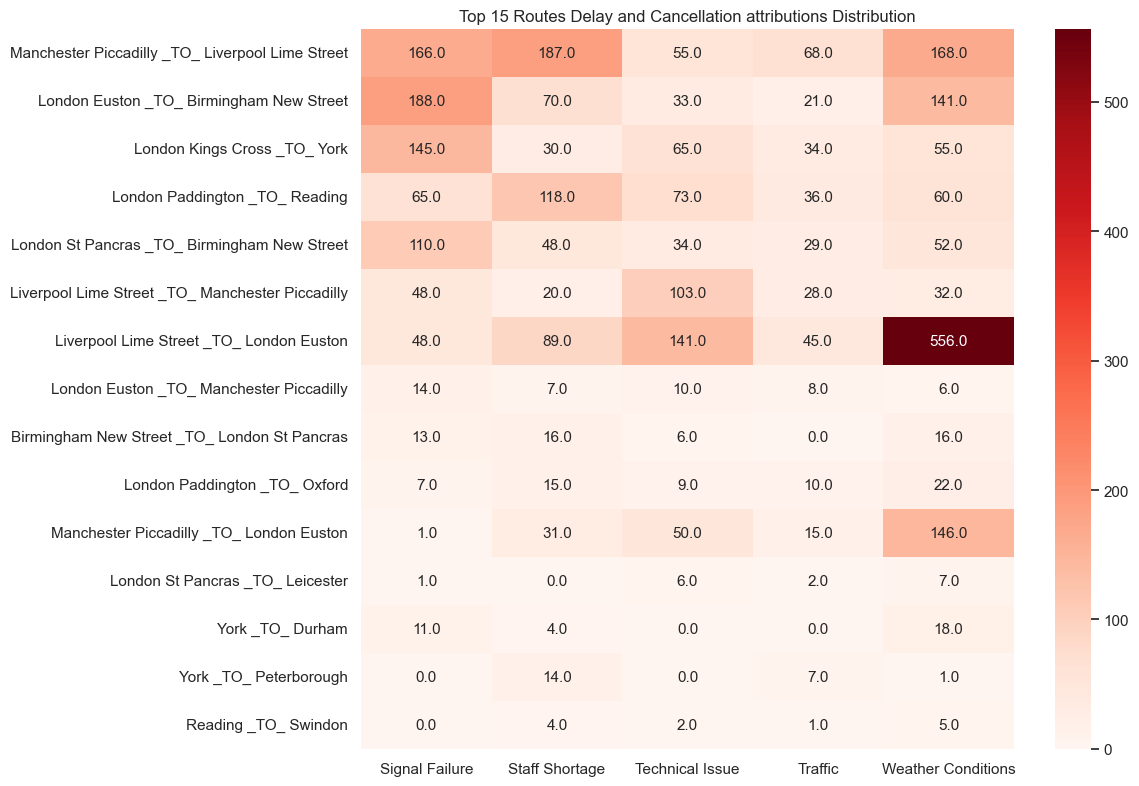

In [78]:
# Select the top 5 routes for visualization
top_routes = route_delay_analysis.head(15)

# Drop non-numeric columns for heatmap
heatmap_data = top_routes.drop(columns=['Total_Journeys', 'Total_Delays_Cancellations', 'Delay_Percentage', 'Signal Failure_Pct', 'Staff Shortage_Pct',
       'Technical Issue_Pct', 'Traffic_Pct', 'Weather Conditions_Pct'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Reds")
plt.title('Top 15 Routes Delay and Cancellation attributions Distribution')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

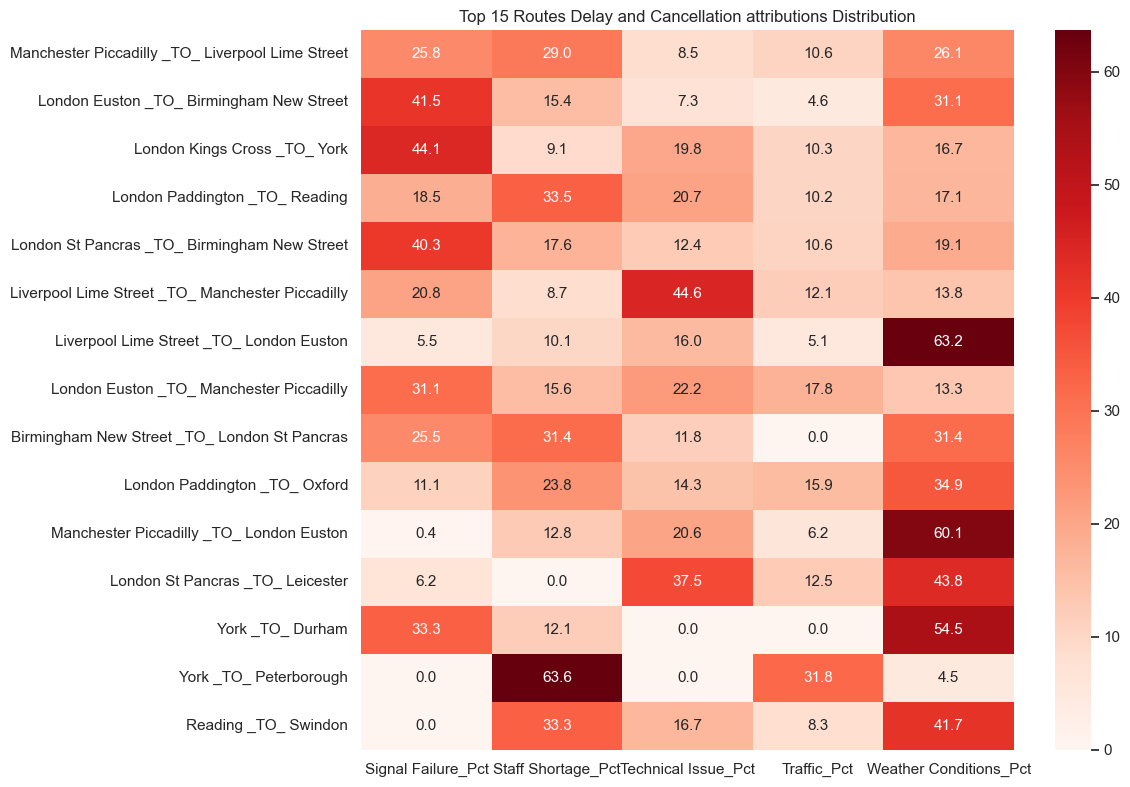

In [79]:
# Select the top 5 routes for visualization
top_routes = route_delay_analysis.head(15)

# Drop non-numeric columns for heatmap
heatmap_data = top_routes.drop(columns=['Total_Journeys', 'Total_Delays_Cancellations', 'Delay_Percentage', 'Signal Failure', 'Staff Shortage',
       'Technical Issue', 'Traffic', 'Weather Conditions'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Reds")
plt.title('Top 15 Routes Delay and Cancellation attributions Distribution')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

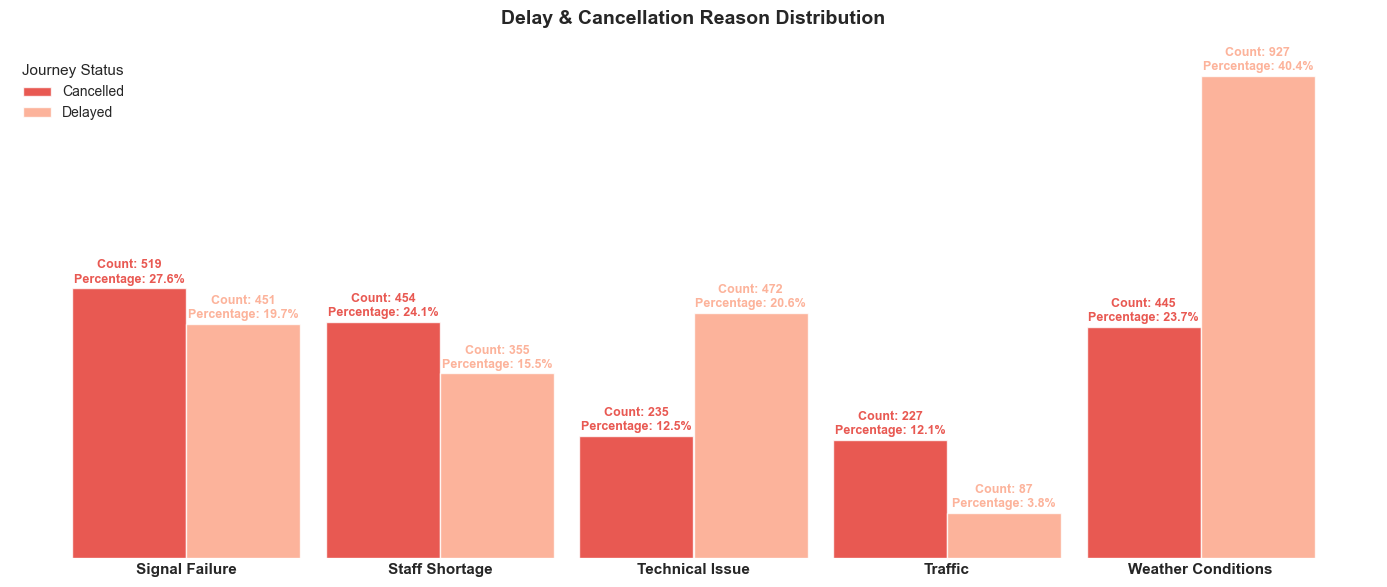

In [80]:
# Set theme and style for better aesthetics
sns.set_theme(style="whitegrid", palette="Reds_d", font="sans-serif")
plt.rcParams['font.size'] = 11
plt.rcParams['font.weight'] = 'normal'

# Calculate counts for each combination of Reason and Journey Status
reason_status_counts = df.groupby(['Reason for Delay', 'Journey Status']).size().reset_index(name='Count')

# Calculate percentages
total_counts = df.groupby('Journey Status').size()
reason_status_counts['Percentage'] = reason_status_counts.apply(
    lambda row: (row['Count'] / total_counts[row['Journey Status']]) * 100, axis=1
)

# Create figure with better sizing
fig, ax = plt.subplots(figsize=(14, 6))

# Get unique reasons and statuses
reasons = sorted(reason_status_counts['Reason for Delay'].unique())
statuses = sorted(reason_status_counts['Journey Status'].unique())

# Set bar width and positions
bar_width = 0.45  # Increased bar width for better text visibility
x = np.arange(len(reasons))

# Create color palette
colors = sns.color_palette("Reds_r", len(statuses))

# Plot grouped bars
for i, status in enumerate(statuses):
    status_data = reason_status_counts[reason_status_counts['Journey Status'] == status]
    
    # Create a dictionary for easier lookup
    count_dict = dict(zip(status_data['Reason for Delay'], status_data['Count']))
    percent_dict = dict(zip(status_data['Reason for Delay'], status_data['Percentage']))
    
    # Extract counts and percentages
    counts = [count_dict.get(reason, 0) for reason in reasons]
    percentages = [percent_dict.get(reason, 0) for reason in reasons]
    
    bars = ax.bar(x + i * bar_width, counts, bar_width, label=status, alpha=0.8, color=colors[i])
    
    # Add count and percentage text on top of bars with better contrast
    for idx, (bar, count, percent) in enumerate(zip(bars, counts, percentages)):
        if count > 0:
            # Get the color of the current bar
            bar_color = bar.get_facecolor()
            
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 5,  # Slight offset to ensure text is above the bar
                f"Count: {int(count)}\nPercentage: {percent:.1f}%",
                ha='center',
                va='bottom',
                color=bar_color,
                fontsize=9,
                fontweight='bold'
            )

# Remove y-axis, ticks, and borders
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Set x-axis ticks and labels properly
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(reasons, rotation=0, fontsize=11, fontweight='bold')
ax.tick_params(axis='x', length=0)

# Hide unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove gridlines
ax.grid(False)

# Add legend
ax.legend(title='Journey Status', fontsize=10, title_fontsize=11, loc='upper left', frameon=False)

# Add title with better styling
plt.title('Delay & Cancellation Reason Distribution', fontsize=14, fontweight='bold', pad=20)

# Adjust layout to fit
plt.tight_layout()

plt.show()

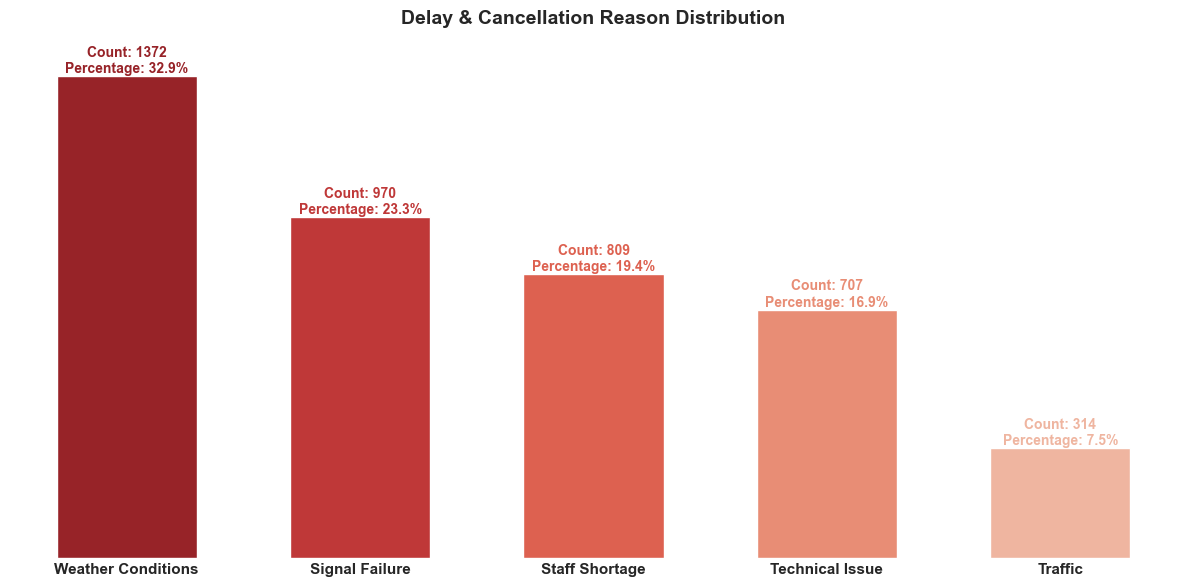

In [81]:
# Set theme and style for better aesthetics
sns.set_theme(style="whitegrid", palette="Reds_r", font="sans-serif")
plt.rcParams['font.size'] = 11
plt.rcParams['font.weight'] = 'normal'


# Calculating Count and Percent
reason_counts = df['Reason for Delay'].value_counts()
reason_percent = df['Reason for Delay'].value_counts(normalize=True) * 100

# Create a DataFrame for plotting
reason_df = pd.DataFrame({
    'Reason for Delay': reason_counts.index,
    'Count': reason_counts,
    'Percentage': reason_percent
})

# Create figure with better sizing
fig, ax = plt.subplots(figsize=(12, 6))

# Plot with refined styling
sns.barplot(
    x='Reason for Delay', 
    y='Count', 
    data=reason_df, 
    hue='Reason for Delay',  
    legend=False,
    ax=ax,
    width=0.6
)

# Add count and percentage text inside the bars with better contrast
for idx, row in enumerate(reason_df.itertuples()):
    count = row.Count
    percent = row.Percentage
    
    # Get the color of the current bar
    bar_color = ax.patches[idx].get_facecolor()
    
    ax.text(
        idx, 
        count,  # Position at the top of the bar
        f"Count: {count}\nPercentage: {percent:.1f}%", 
        ha='center', 
        va='bottom',  # Align text bottom to bar top
        color=bar_color,  # Match bar color
        fontsize=10,
        fontweight='bold'
    )

# Remove y-axis, ticks, and borders
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Set x-axis ticks and labels properly
ax.set_xticks(range(len(reason_df)))
ax.set_xticklabels(reason_df['Reason for Delay'], rotation=0, fontsize=11, fontweight='bold')
ax.tick_params(axis='x', length=0)

# Hide unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add title with better styling
plt.title('Delay & Cancellation Reason Distribution', fontsize=14, fontweight='bold', pad=20)

# Adjust layout to fit
plt.tight_layout()

plt.show()

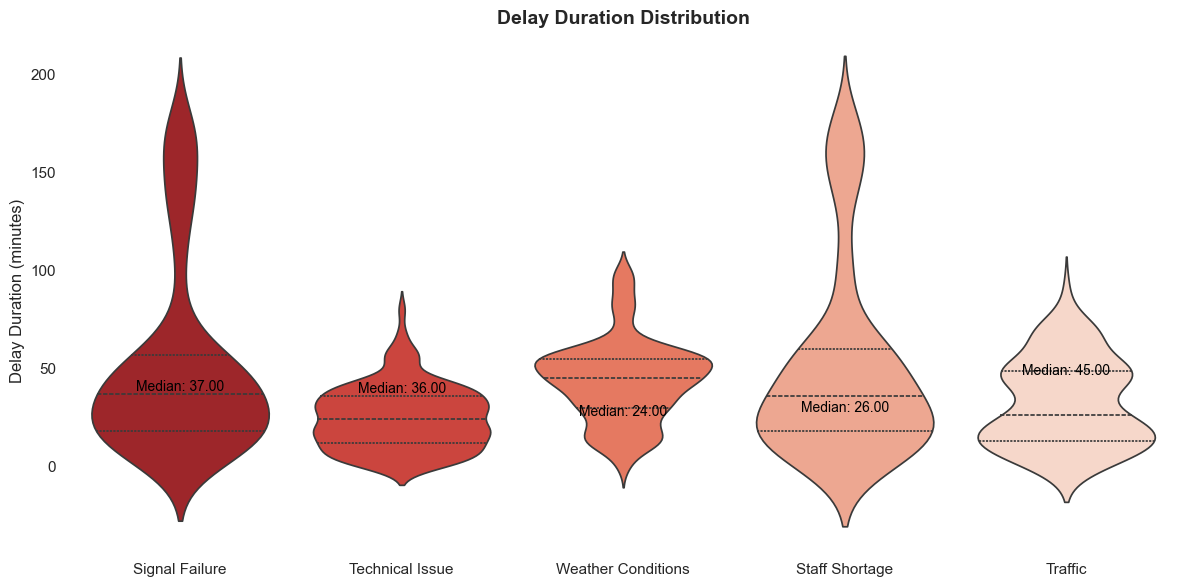

In [82]:
# Filter the dataframe to only include delayed journeys
delayed_journeys = df[df['Journey Status'] == 'Delayed']

# Melt the data to have a single 'Delay Duration' column
delay_data = delayed_journeys[['Reason for Delay', 'Delay Duration']].copy()

# Plot using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(
    x='Reason for Delay', 
    y='Delay Duration', 
    hue='Reason for Delay', 
    data=delay_data, 
    palette='Reds_r', 
    inner="quartile", 
    legend=False
)

plt.grid(False)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title('Delay Duration Distribution', fontsize=14, fontweight='bold')


plt.xlabel('')
plt.ylabel('Delay Duration (minutes)')

plt.xticks(rotation=0)

# Annotate median values
for i, (idx, row) in enumerate(delay_data.groupby('Reason for Delay').median().reset_index().iterrows()):
    ax.text(i, row['Delay Duration'], f'Median: {row["Delay Duration"]:.2f}', 
            color='black', fontsize=10, ha='center', va='bottom')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

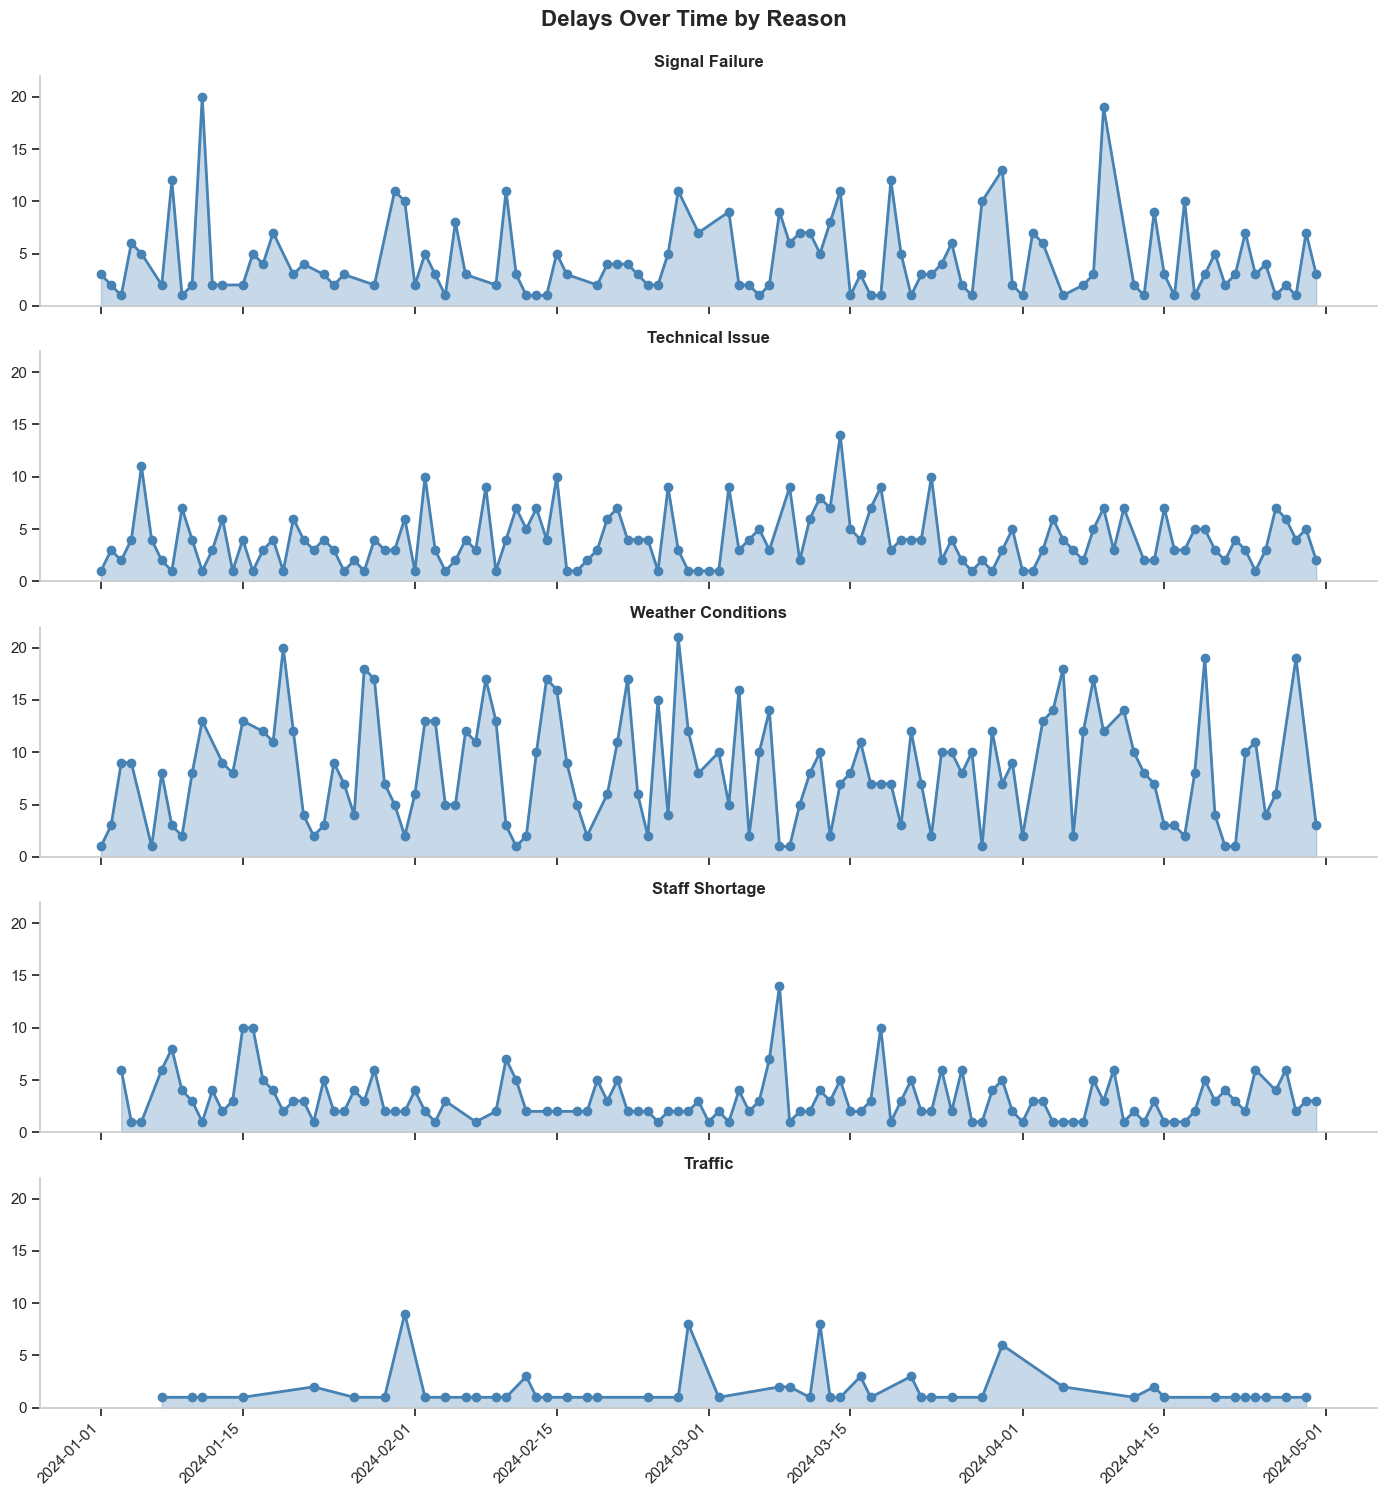

In [83]:
# Get unique delay reasons from the column
delay_reasons = df['Reason for Delay'].dropna().unique()

# Filter for delayed journeys and ensure Departure Date is datetime
delay_data = df[(df['Journey Status'] == 'Delayed') & 
                df['Reason for Delay'].isin(delay_reasons)].copy()
delay_data['Departure Date'] = pd.to_datetime(delay_data['Departure Date'])

# Group by date and delay reason
delay_counts = delay_data.groupby([delay_data['Departure Date'].dt.date, 'Reason for Delay']).size().reset_index(name='Count')
delay_counts.columns = ['Departure Date', 'Reason for Delay', 'Count']
delay_counts['Departure Date'] = pd.to_datetime(delay_counts['Departure Date'])

# Find global min and max for standardized y-axis
global_min = delay_counts['Count'].min()
global_max = delay_counts['Count'].max()

# Create subplots dynamically based on number of unique reasons
num_reasons = len(delay_reasons)
fig, axes = plt.subplots(num_reasons, 1, figsize=(14, 3 * num_reasons), sharex=True, sharey=True)
fig.suptitle('Delays Over Time by Reason', fontsize=16, fontweight='bold', y=0.995)

# Handle case where there's only one subplot
if num_reasons == 1:
    axes = [axes]

# Plot each delay reason separately
for i, reason in enumerate(delay_reasons):
    reason_data = delay_counts[delay_counts['Reason for Delay'] == reason]
    axes[i].plot(reason_data['Departure Date'], reason_data['Count'], marker='o', linewidth=2, color='steelblue')
    axes[i].set_title(reason, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('')
    axes[i].grid(False)
    axes[i].fill_between(reason_data['Departure Date'], reason_data['Count'], alpha=0.3, color='steelblue')
    
    # Set standardized y-axis limits
    axes[i].set_ylim(global_min - 1, global_max + 1)
    
    # Remove only top and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    # Show ticks and labels
    axes[i].tick_params(bottom=True, left=True, labelbottom=False, labelleft=True)
    
    # Format x-axis for last subplot
    if i == num_reasons - 1:
        axes[i].tick_params(labelbottom=True)
        axes[i].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')

axes[-1].set_xlabel('')
plt.tight_layout()
plt.show()

#### Weather Conditions

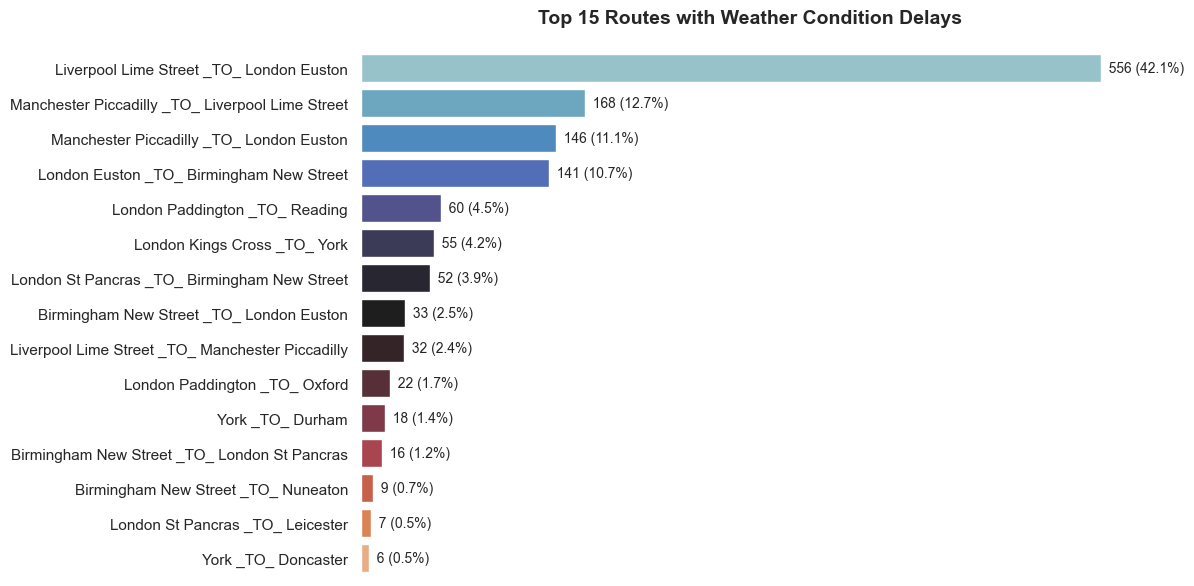

In [84]:
# Count of journeys per Route
weather_delays = df.loc[df['Reason for Delay'] == 'Weather Conditions']
Route_counts = weather_delays['Route'].value_counts().nlargest(15)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=Route_counts.values, y=Route_counts.index, orient='h', 
                  hue=Route_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Top 15 Routes with Weather Condition Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = Route_counts.sum()
for i, (idx, value) in enumerate(Route_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

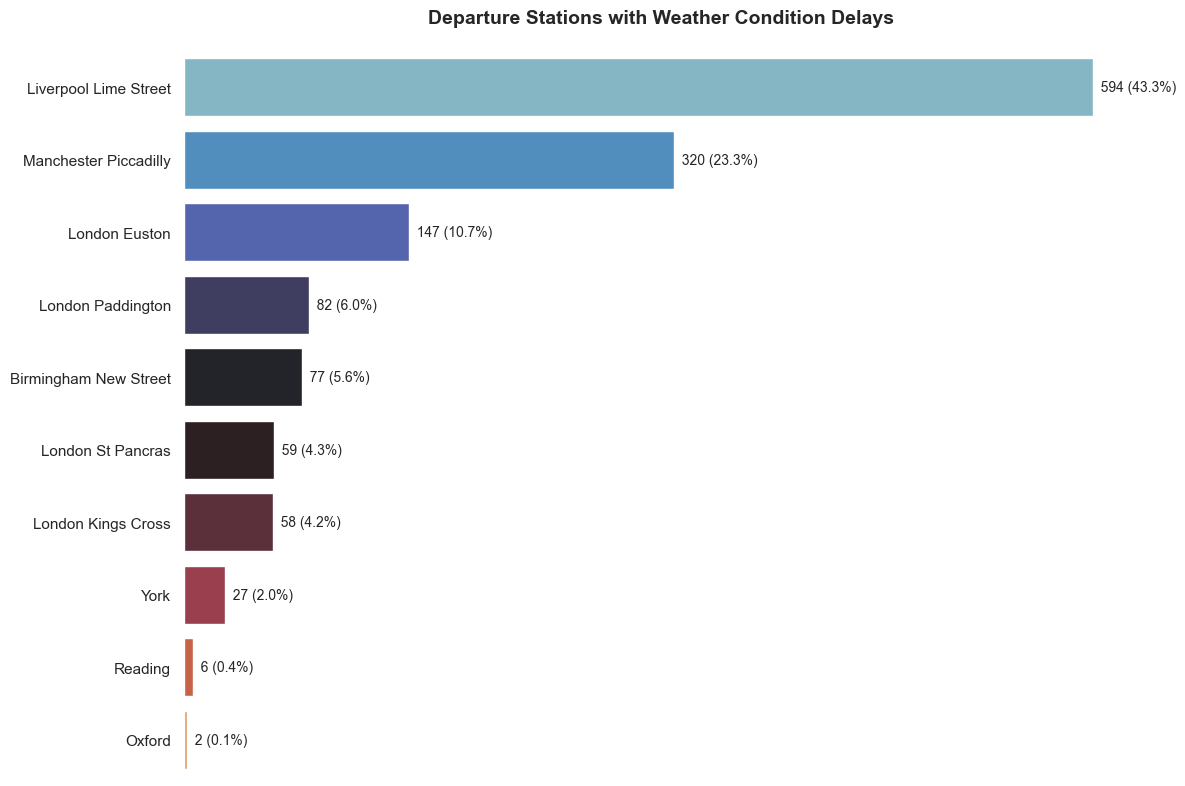

In [85]:
# Count of journeys per Departure Station
weather_delays = df.loc[df['Reason for Delay'] == 'Weather Conditions']
station_counts = weather_delays['Departure Station'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, max(8, len(station_counts) * 0.3)))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Departure Stations with Weather Condition Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

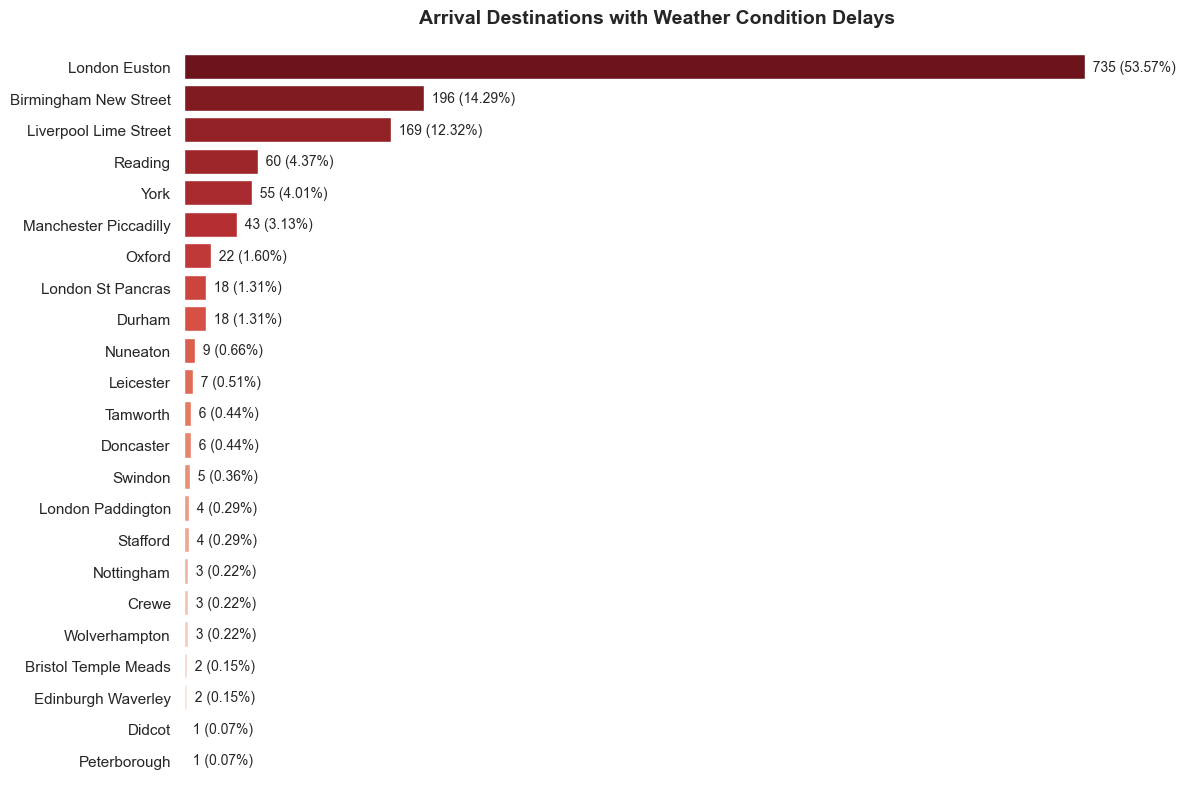

In [86]:
# Count of journeys per Arrival Destination
weather_delays = df.loc[df['Reason for Delay'] == 'Weather Conditions']
station_counts = weather_delays['Arrival Destination'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, max(8, len(station_counts) * 0.3)))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='Reds_r', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Arrival Destinations with Weather Condition Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.2f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

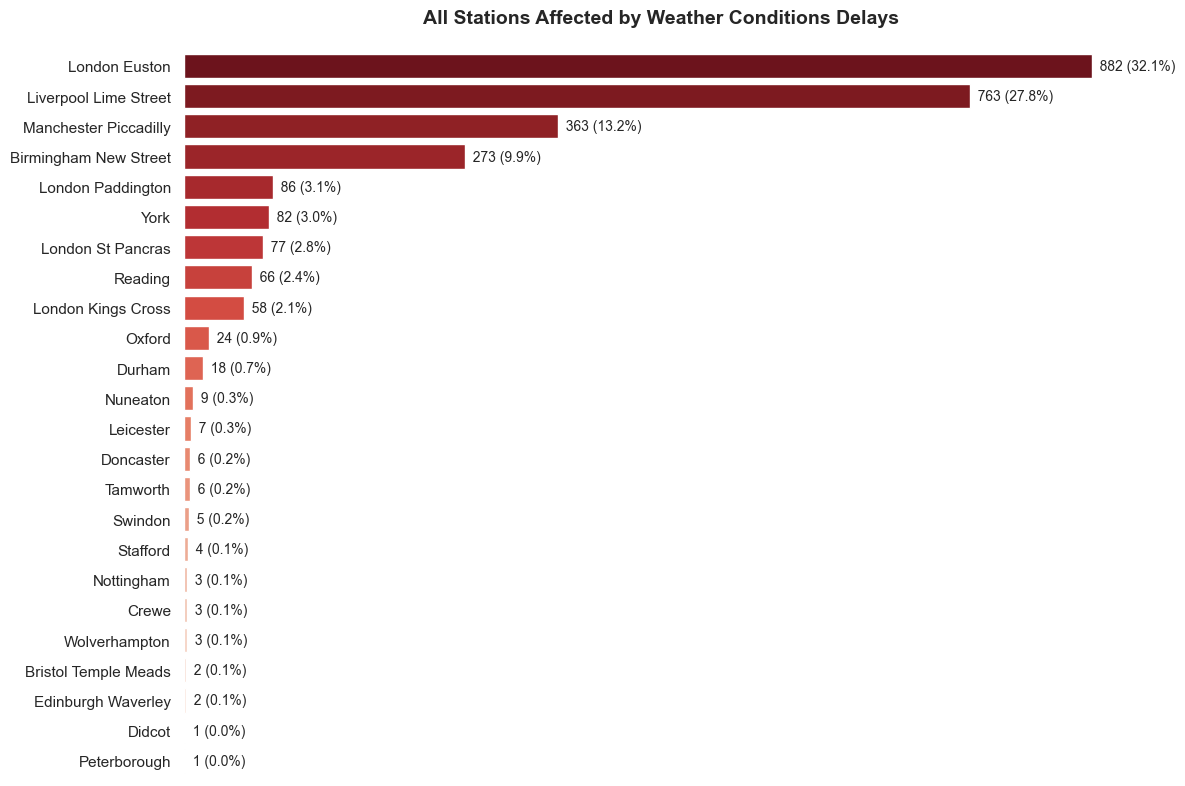

In [87]:
# Filter for journeys with Weather Conditions delays
weather_delays = df[df['Reason for Delay'] == 'Weather Conditions'].copy()

# Combine departure and arrival stations for delayed journeys
all_stations_weather = pd.concat([weather_delays['Departure Station'], 
                                   weather_delays['Arrival Destination']])
station_weather_counts = all_stations_weather.value_counts()  # Show all stations

# Plot as a bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=station_weather_counts.values, y=station_weather_counts.index, orient='h', 
                 hue=station_weather_counts.index, palette='Reds_r', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('All Stations Affected by Weather Conditions Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_weather_counts.sum()
for i, (idx, value) in enumerate(station_weather_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

#### Technical Issue

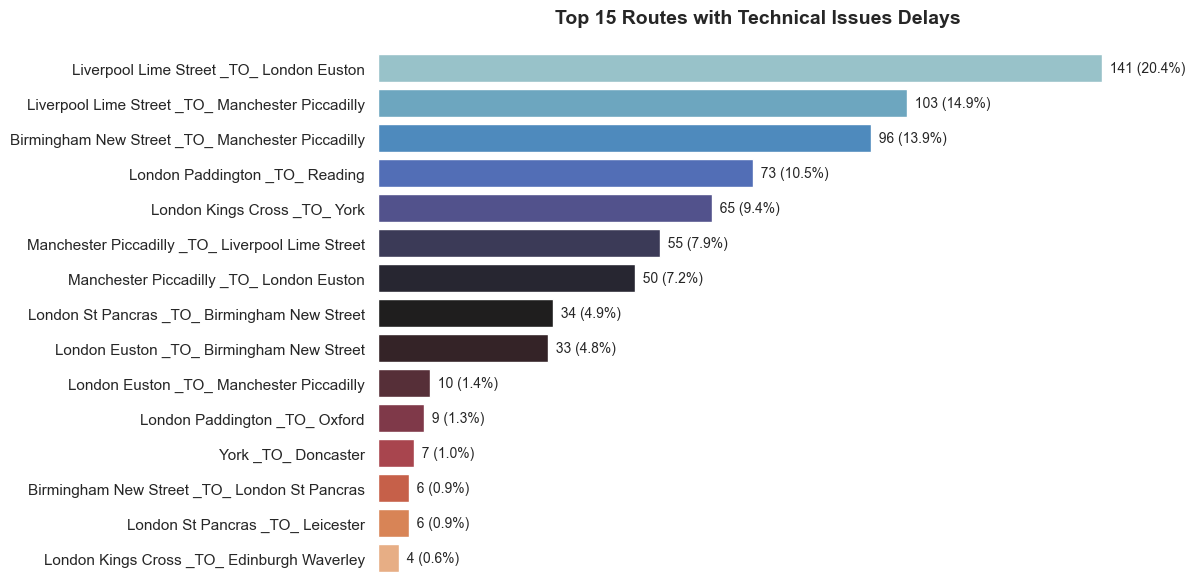

In [88]:
# Count of journeys per Route
technical_delays = df.loc[df['Reason for Delay'] == 'Technical Issue']
Route_counts = technical_delays['Route'].value_counts().nlargest(15)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=Route_counts.values, y=Route_counts.index, orient='h', 
                  hue=Route_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Top 15 Routes with Technical Issues Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = Route_counts.sum()
for i, (idx, value) in enumerate(Route_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

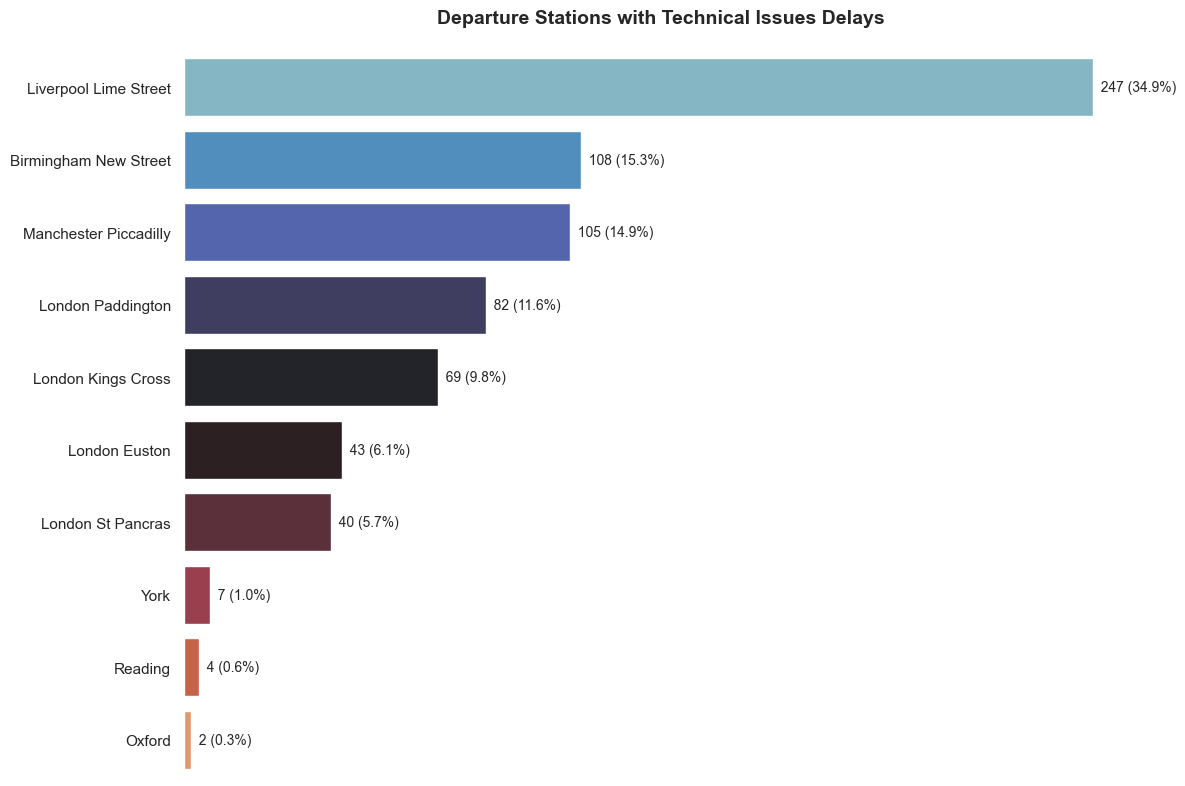

In [89]:
# Count of journeys per Departure Station
technical_delays = df.loc[df['Reason for Delay'] == 'Technical Issue']
station_counts = technical_delays['Departure Station'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, max(8, len(station_counts) * 0.3)))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Departure Stations with Technical Issues Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

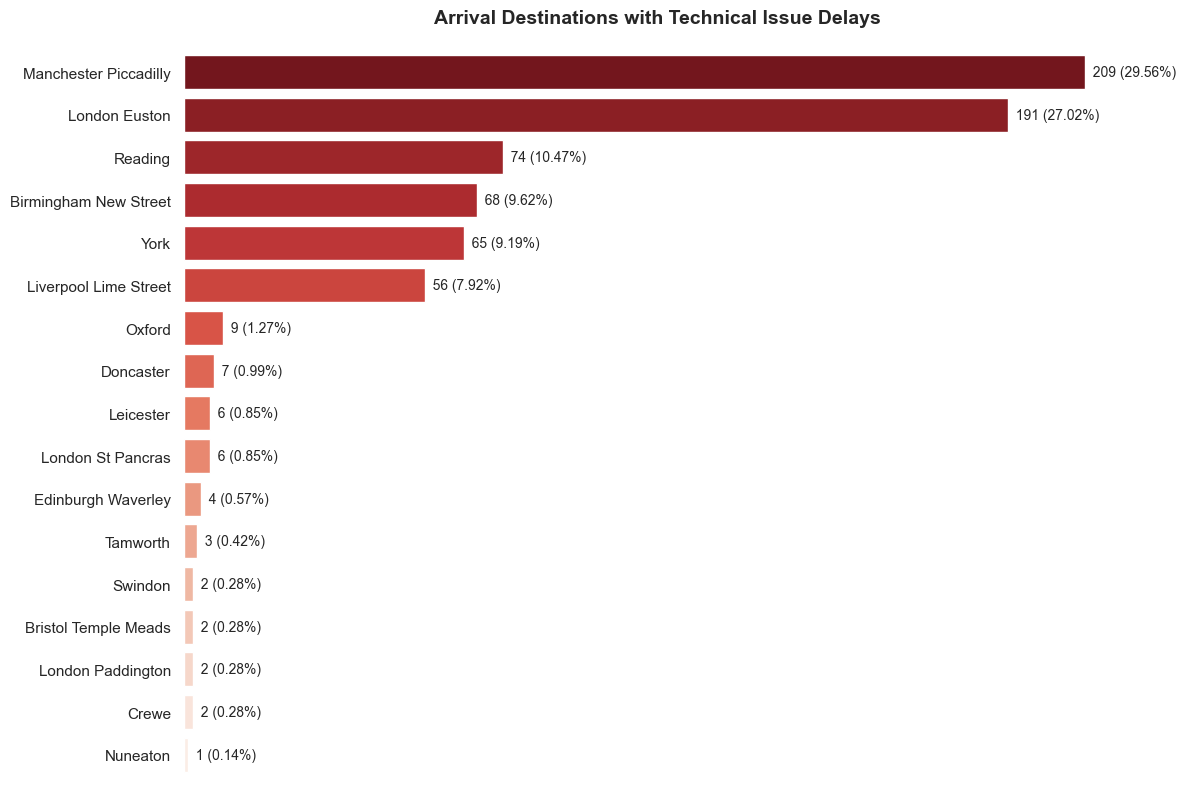

In [90]:
# Count of journeys per Arrival Destination
weather_delays = df.loc[df['Reason for Delay'] == 'Technical Issue']
station_counts = weather_delays['Arrival Destination'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, max(8, len(station_counts) * 0.3)))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='Reds_r', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Arrival Destinations with Technical Issue Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.2f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

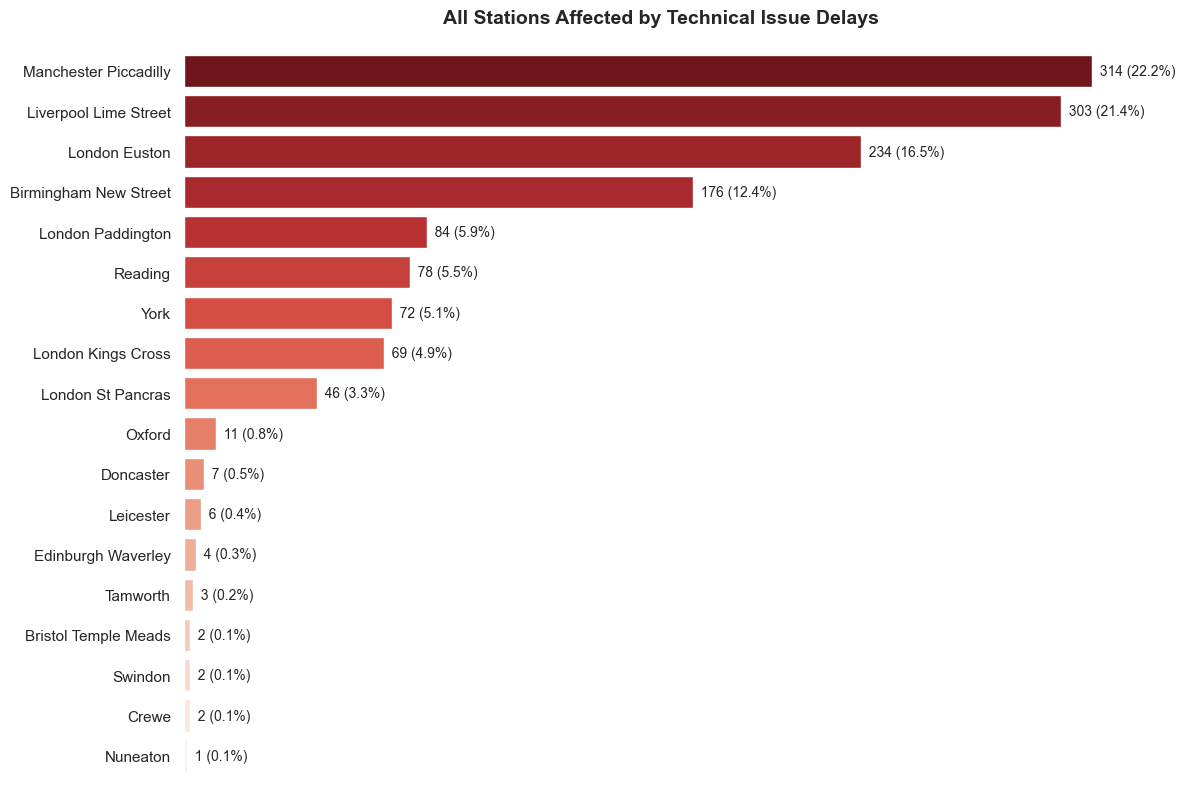

In [91]:
# Filter for journeys with Technical Issue delays
weather_delays = df[df['Reason for Delay'] == 'Technical Issue'].copy()

# Combine departure and arrival stations for delayed journeys
all_stations_weather = pd.concat([weather_delays['Departure Station'], 
                                   weather_delays['Arrival Destination']])
station_weather_counts = all_stations_weather.value_counts()  # Show all stations

# Plot as a bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=station_weather_counts.values, y=station_weather_counts.index, orient='h', 
                 hue=station_weather_counts.index, palette='Reds_r', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('All Stations Affected by Technical Issue Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_weather_counts.sum()
for i, (idx, value) in enumerate(station_weather_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

#### Signal Failure

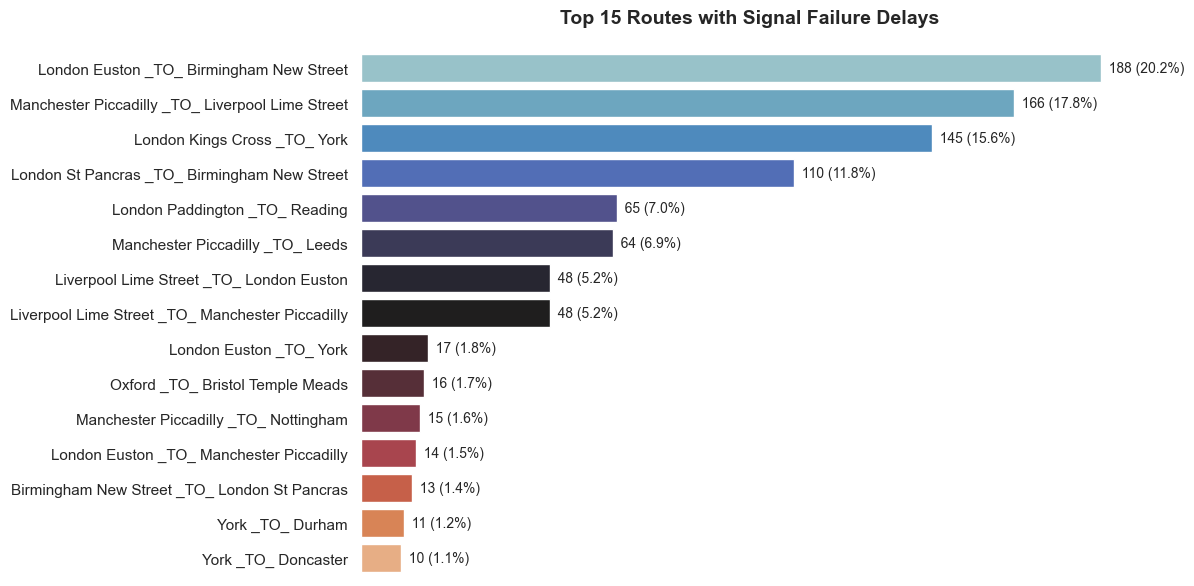

In [92]:
# Count of journeys per Route
signal_delays = df.loc[df['Reason for Delay'] == 'Signal Failure']
Route_counts = signal_delays['Route'].value_counts().nlargest(15)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=Route_counts.values, y=Route_counts.index, orient='h', 
                  hue=Route_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Top 15 Routes with Signal Failure Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = Route_counts.sum()
for i, (idx, value) in enumerate(Route_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

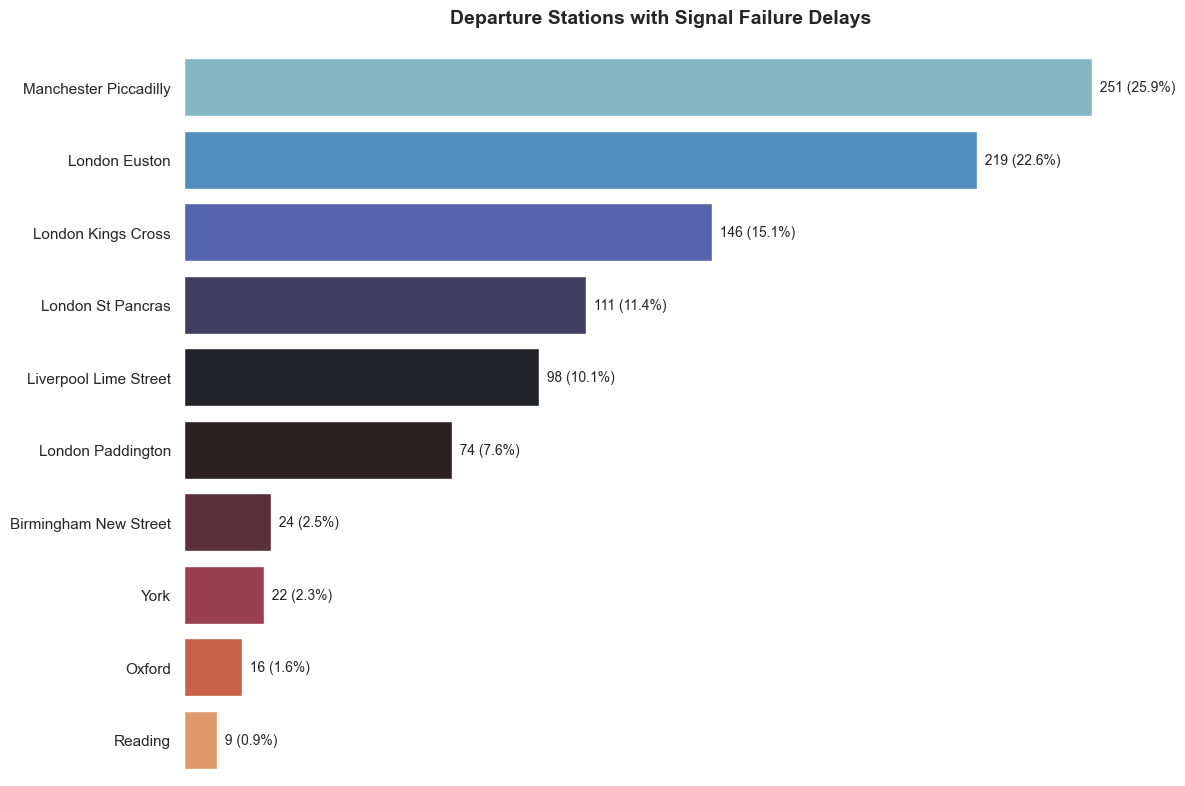

In [93]:
# Count of journeys per Departure Station
signal_delays = df.loc[df['Reason for Delay'] == 'Signal Failure']
station_counts = signal_delays['Departure Station'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, max(8, len(station_counts) * 0.3)))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Departure Stations with Signal Failure Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

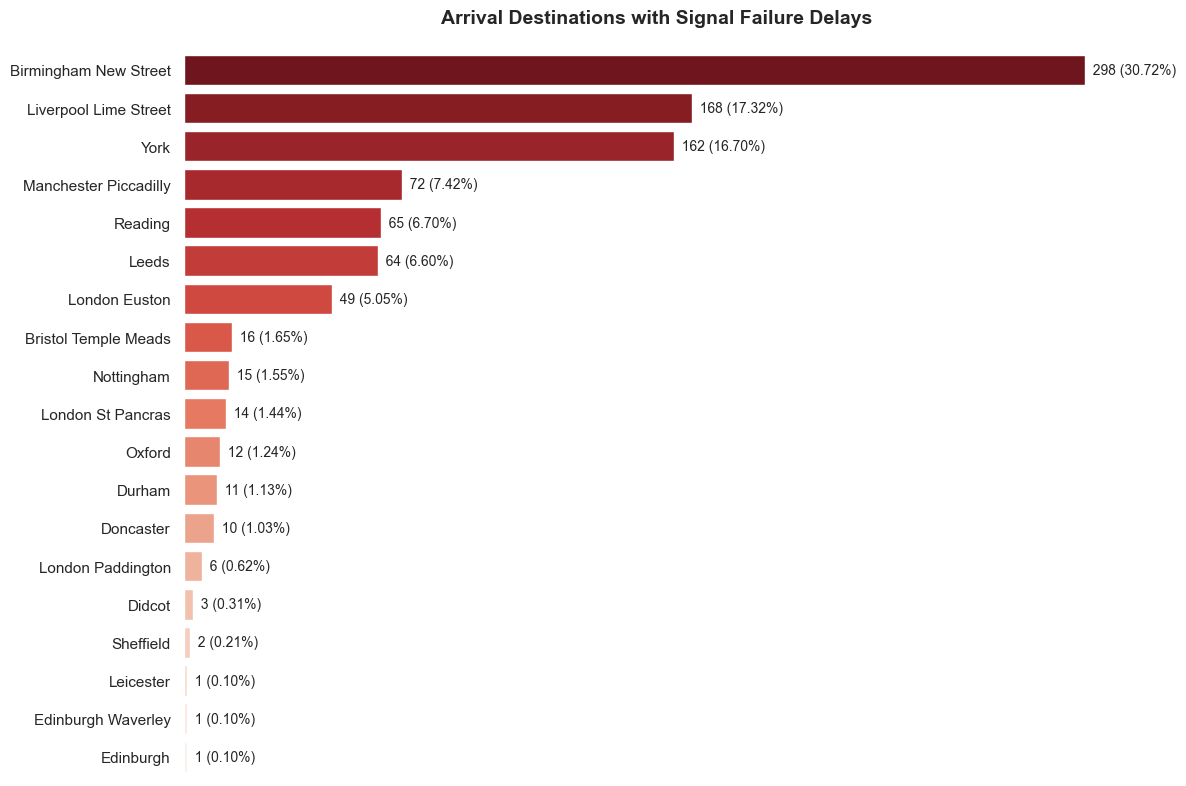

In [94]:
# Count of journeys per Arrival Destination
weather_delays = df.loc[df['Reason for Delay'] == 'Signal Failure']
station_counts = weather_delays['Arrival Destination'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, max(8, len(station_counts) * 0.3)))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='Reds_r', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Arrival Destinations with Signal Failure Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.2f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

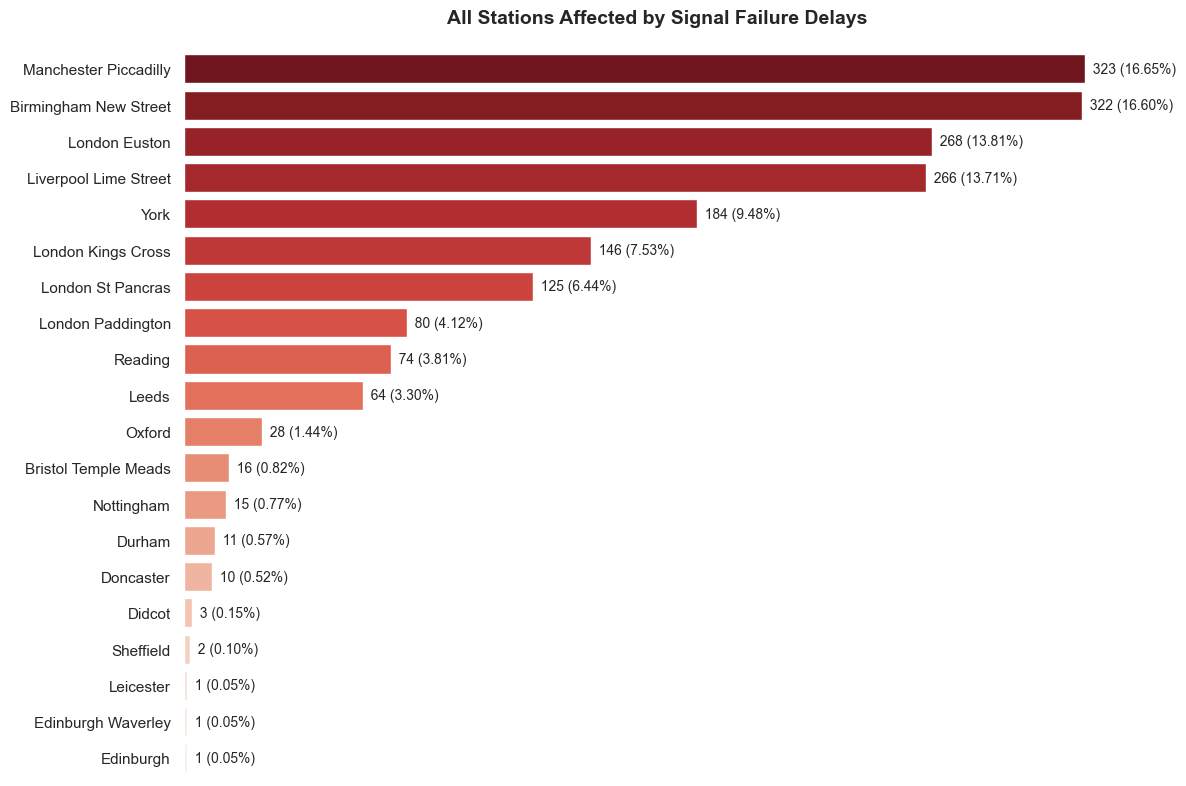

In [95]:
# Filter for journeys with Signal Failure delays
weather_delays = df[df['Reason for Delay'] == 'Signal Failure'].copy()

# Combine departure and arrival stations for delayed journeys
all_stations_weather = pd.concat([weather_delays['Departure Station'], 
                                   weather_delays['Arrival Destination']])
station_weather_counts = all_stations_weather.value_counts()  # Show all stations

# Plot as a bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=station_weather_counts.values, y=station_weather_counts.index, orient='h', 
                 hue=station_weather_counts.index, palette='Reds_r', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('All Stations Affected by Signal Failure Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_weather_counts.sum()
for i, (idx, value) in enumerate(station_weather_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.2f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

#### Staff Shortage

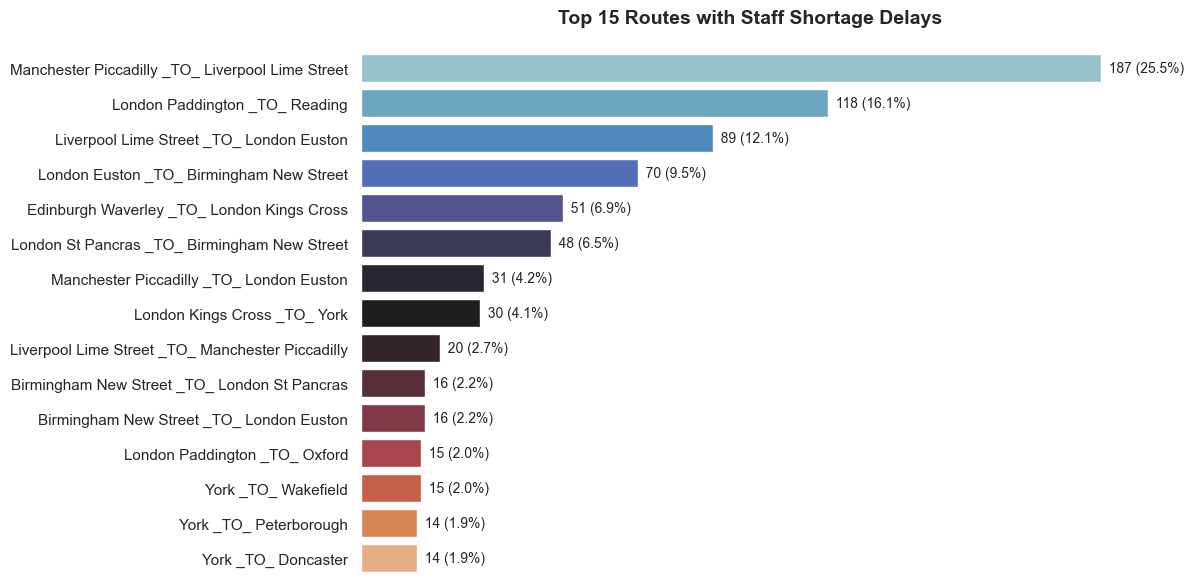

In [96]:
# Count of journeys per Route
staff_delays = df.loc[df['Reason for Delay'] == 'Staff Shortage']
Route_counts = staff_delays['Route'].value_counts().nlargest(15)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=Route_counts.values, y=Route_counts.index, orient='h', 
                  hue=Route_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Top 15 Routes with Staff Shortage Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = Route_counts.sum()
for i, (idx, value) in enumerate(Route_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

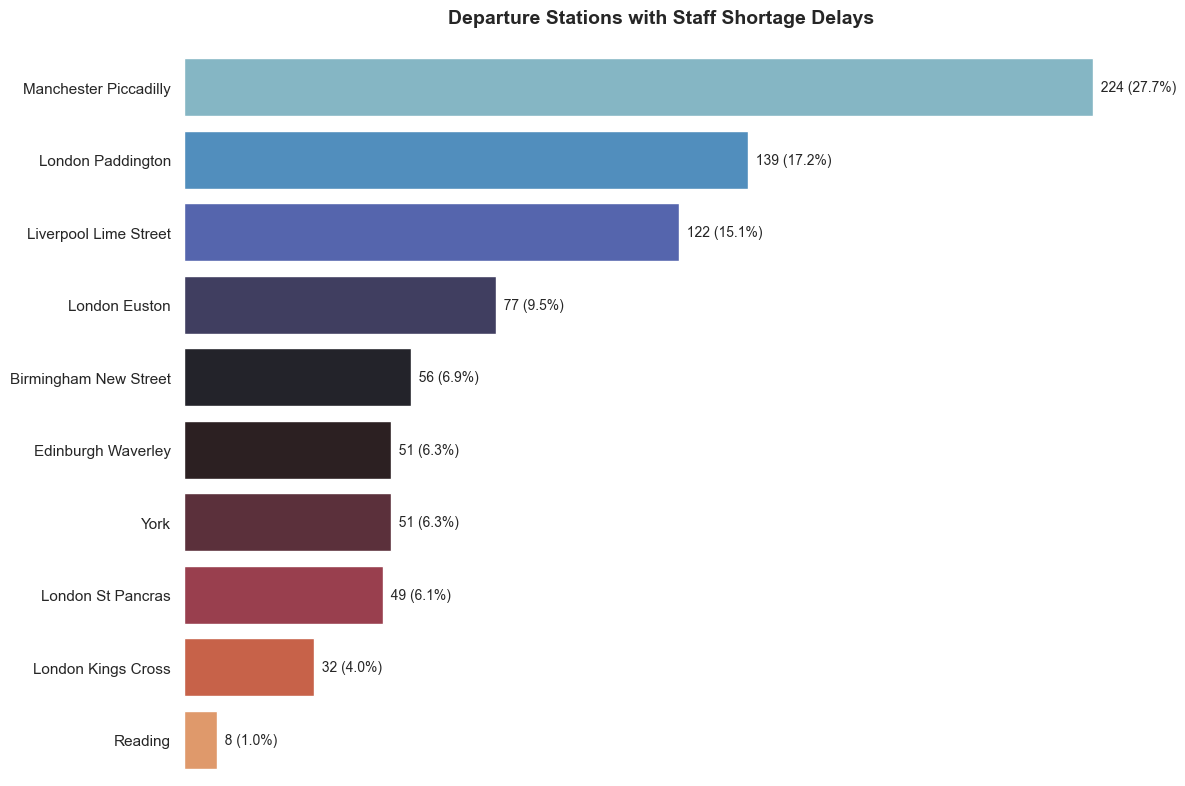

In [97]:
# Count of journeys per Departure Station
staff_delays = df.loc[df['Reason for Delay'] ==  'Staff Shortage']
station_counts = staff_delays['Departure Station'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, max(8, len(station_counts) * 0.3)))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Departure Stations with Staff Shortage Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

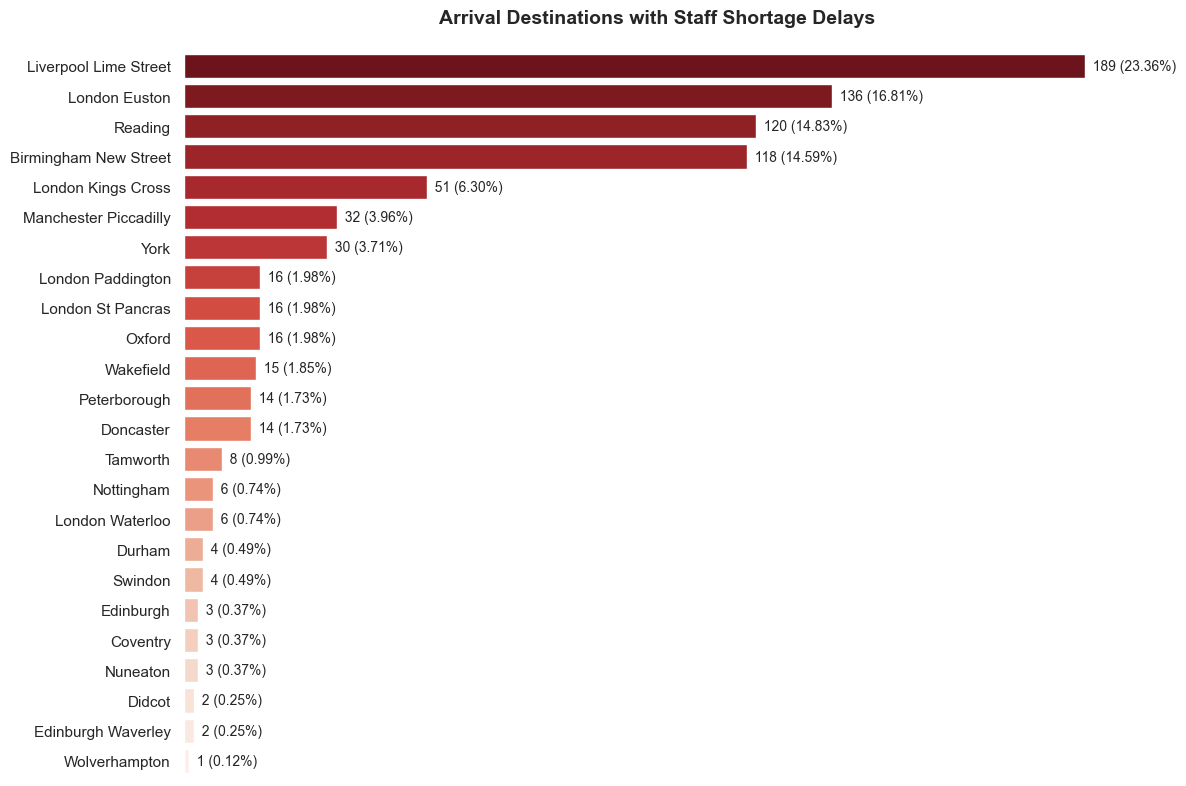

In [98]:
# Count of journeys per Arrival Destination
weather_delays = df.loc[df['Reason for Delay'] == 'Staff Shortage']
station_counts = weather_delays['Arrival Destination'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, max(8, len(station_counts) * 0.3)))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='Reds_r', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Arrival Destinations with Staff Shortage Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.2f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

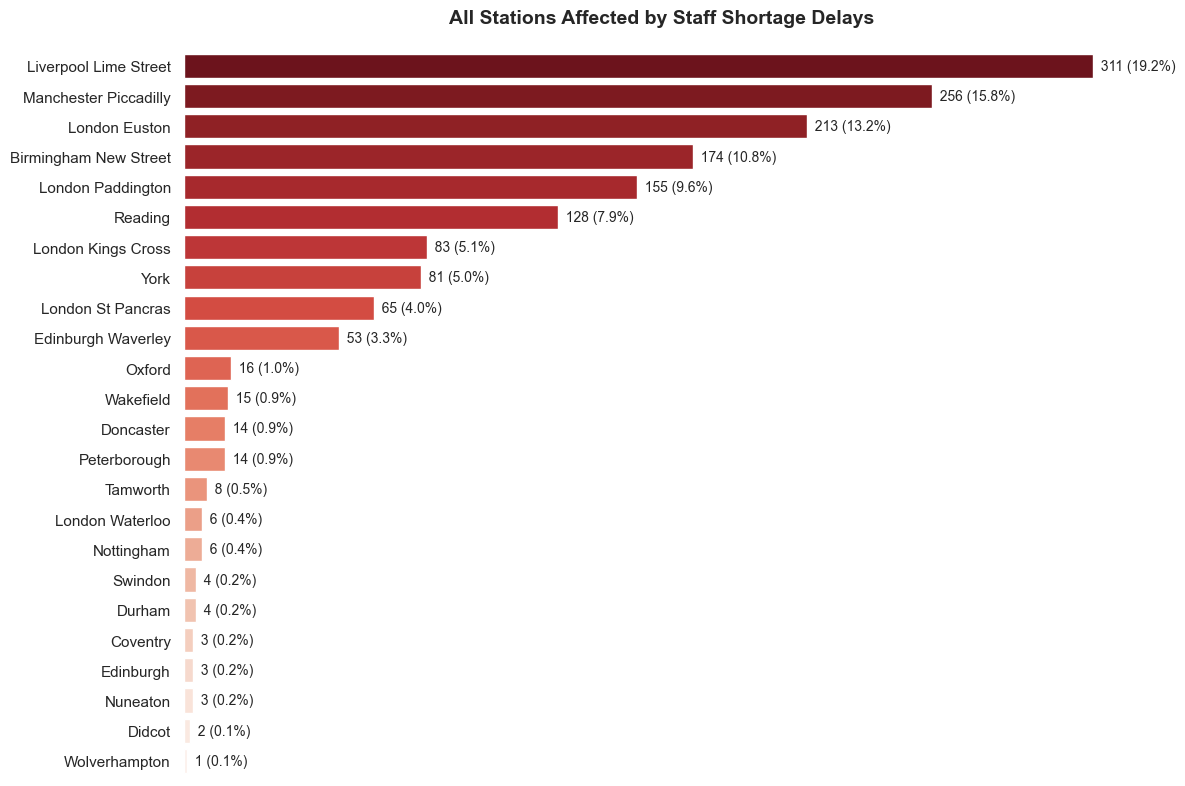

In [99]:
# Filter for journeys with Staff Shortage delays
weather_delays = df[df['Reason for Delay'] == 'Staff Shortage'].copy()

# Combine departure and arrival stations for delayed journeys
all_stations_weather = pd.concat([weather_delays['Departure Station'], 
                                   weather_delays['Arrival Destination']])
station_weather_counts = all_stations_weather.value_counts()  # Show all stations

# Plot as a bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=station_weather_counts.values, y=station_weather_counts.index, orient='h', 
                 hue=station_weather_counts.index, palette='Reds_r', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('All Stations Affected by Staff Shortage Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_weather_counts.sum()
for i, (idx, value) in enumerate(station_weather_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

#### Traffic

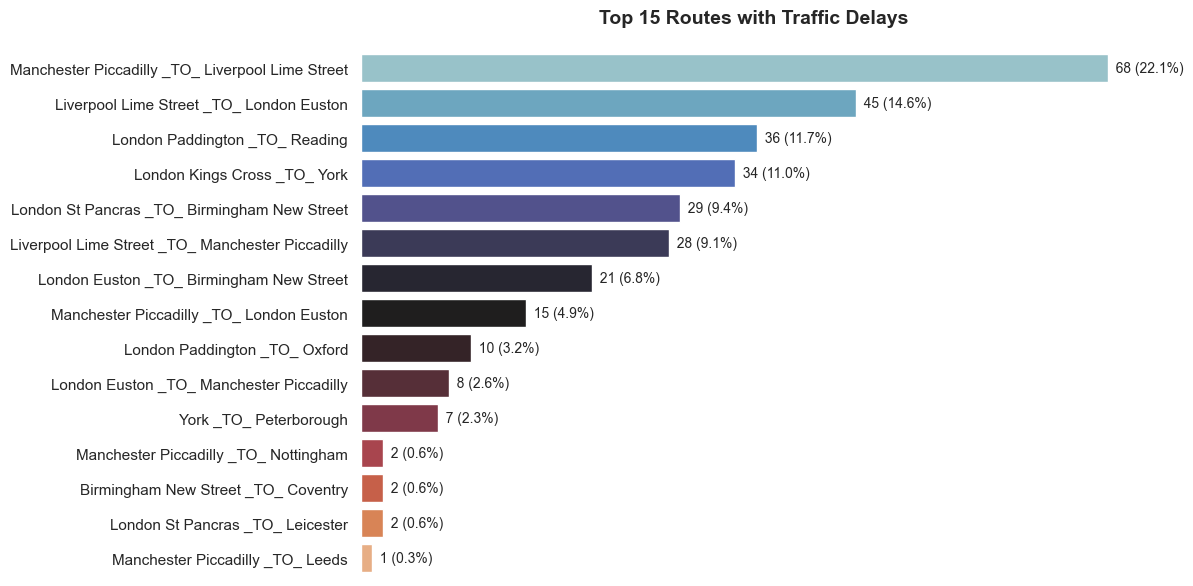

In [100]:
# Count of journeys per Route
traffic_delays = df.loc[df['Reason for Delay'] == 'Traffic']
Route_counts = traffic_delays['Route'].value_counts().nlargest(15)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=Route_counts.values, y=Route_counts.index, orient='h', 
                  hue=Route_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Top 15 Routes with Traffic Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = Route_counts.sum()
for i, (idx, value) in enumerate(Route_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

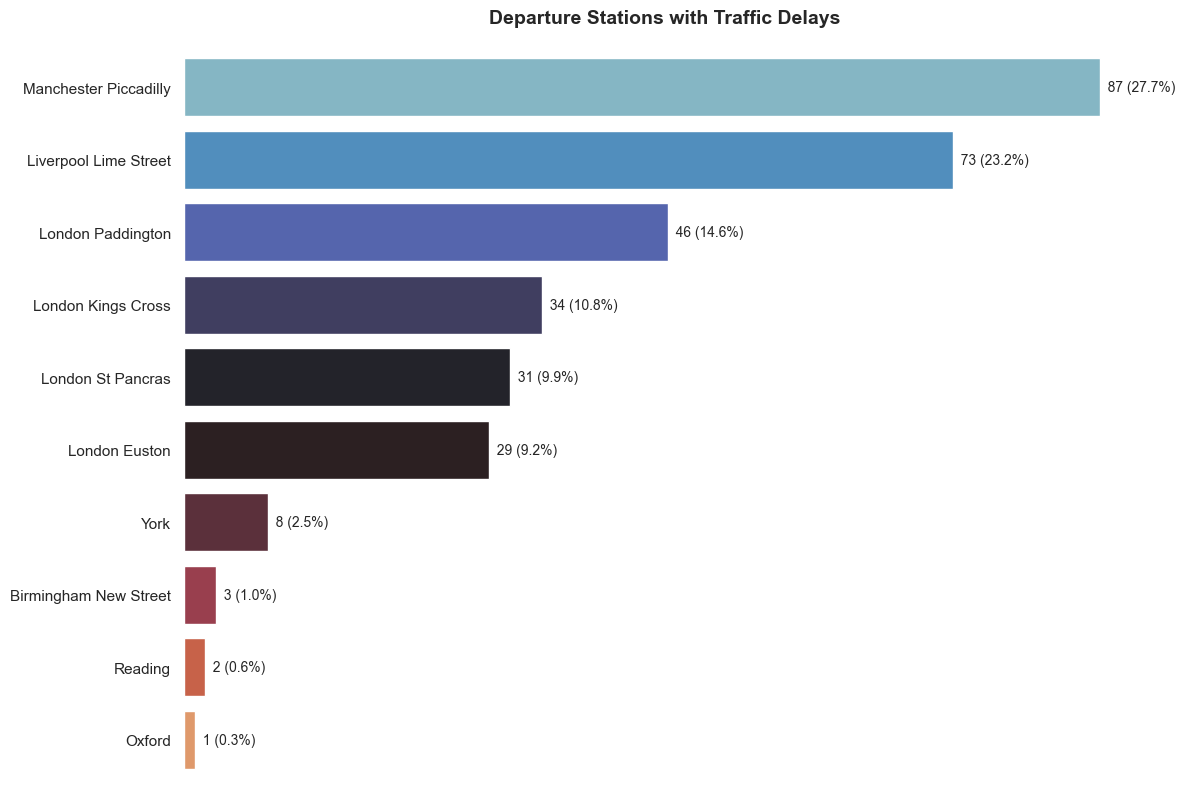

In [101]:
# Count of journeys per Departure Station
traffic_delays = df.loc[df['Reason for Delay'] ==  'Traffic']
station_counts = traffic_delays['Departure Station'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, max(8, len(station_counts) * 0.3)))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='icefire', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Departure Stations with Traffic Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

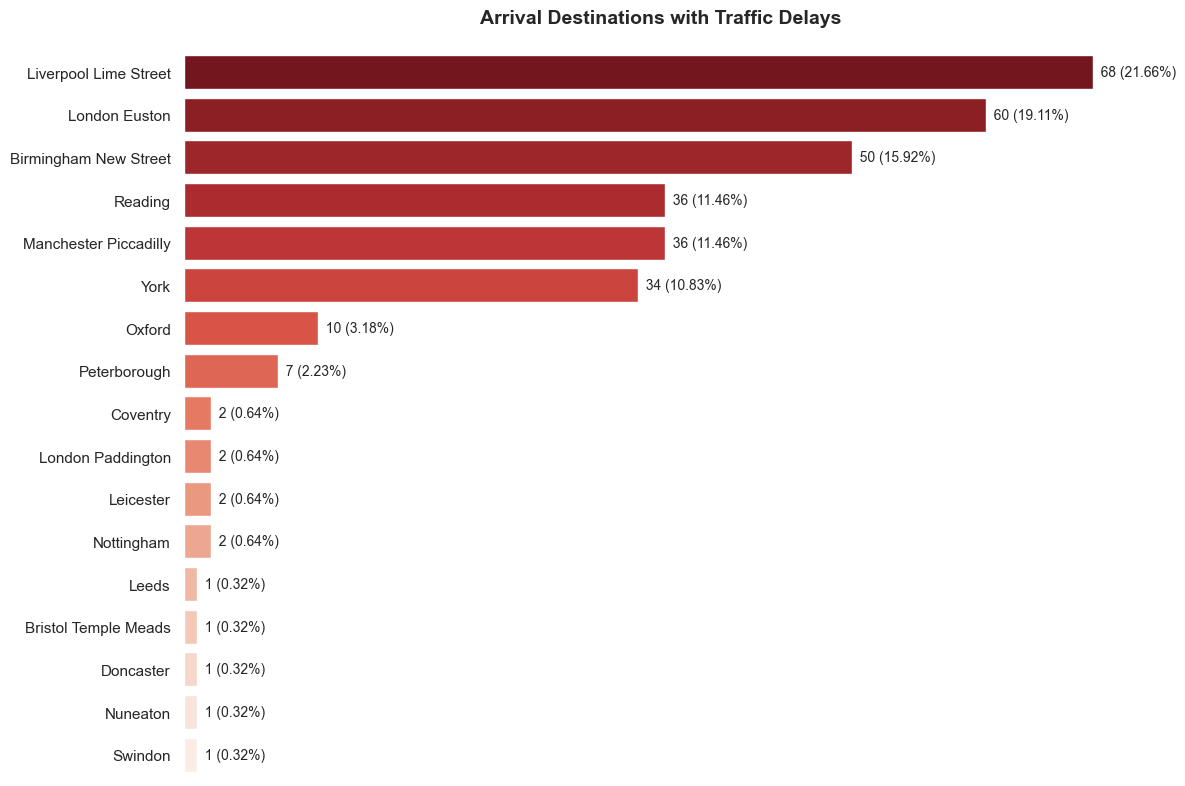

In [102]:
# Count of journeys per Arrival Destination
weather_delays = df.loc[df['Reason for Delay'] == 'Traffic']
station_counts = weather_delays['Arrival Destination'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, max(8, len(station_counts) * 0.3)))
ax = sns.barplot(x=station_counts.values, y=station_counts.index, orient='h', 
                  hue=station_counts.index, palette='Reds_r', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('Arrival Destinations with Traffic Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_counts.sum()
for i, (idx, value) in enumerate(station_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.2f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

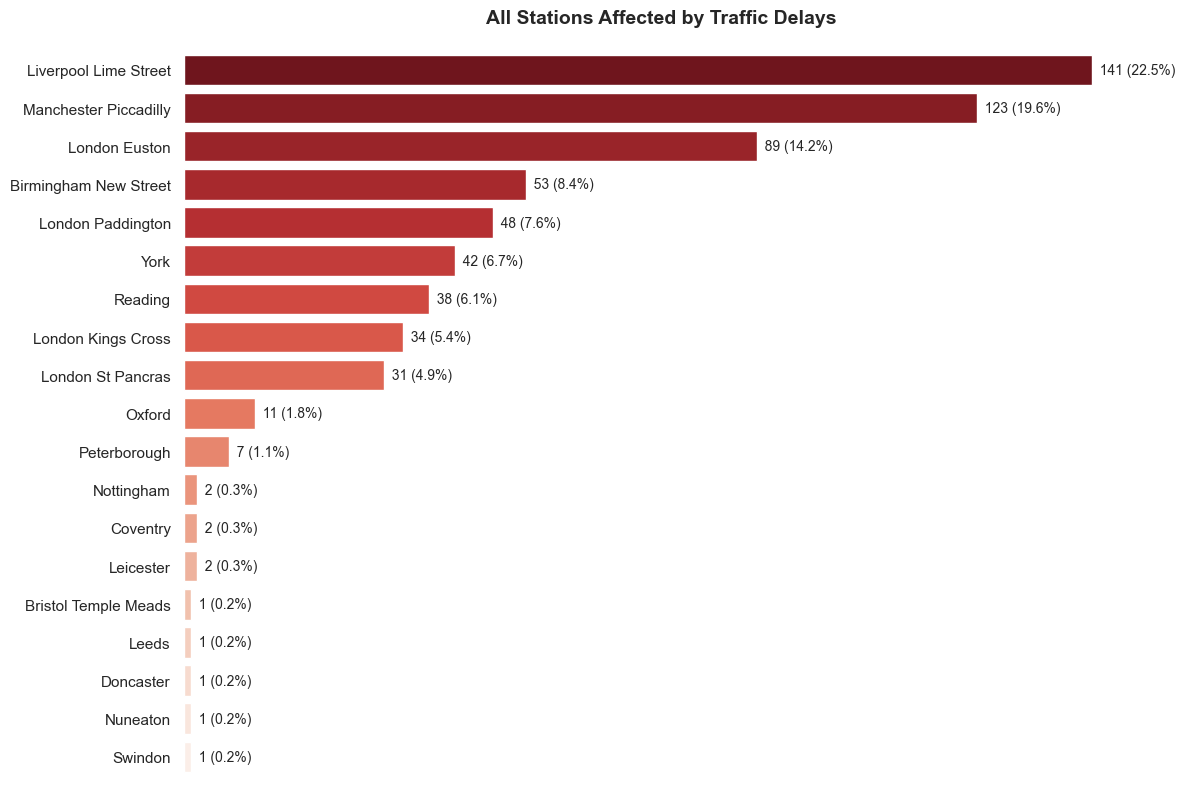

In [103]:
# Filter for journeys with Traffic delays
weather_delays = df[df['Reason for Delay'] == 'Traffic'].copy()

# Combine departure and arrival stations for delayed journeys
all_stations_weather = pd.concat([weather_delays['Departure Station'], 
                                   weather_delays['Arrival Destination']])
station_weather_counts = all_stations_weather.value_counts()  # Show all stations

# Plot as a bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=station_weather_counts.values, y=station_weather_counts.index, orient='h', 
                 hue=station_weather_counts.index, palette='Reds_r', legend=False)

# Remove grid lines and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis ticks
ax.set_xticks([])
ax.set_ylabel('')

# Add title with better styling
plt.title('All Stations Affected by Traffic Delays', fontsize=14, fontweight='bold', pad=20)

# Add data labels with count and percentage
total = station_weather_counts.sum()
for i, (idx, value) in enumerate(station_weather_counts.items()):
    percentage = (value / total) * 100
    ax.text(value, i, f'  {int(value)} ({percentage:.1f}%)', 
            va='center', fontsize=10)

# Adjust layout to fit
plt.tight_layout()

plt.show()

# Passenger Behaviour

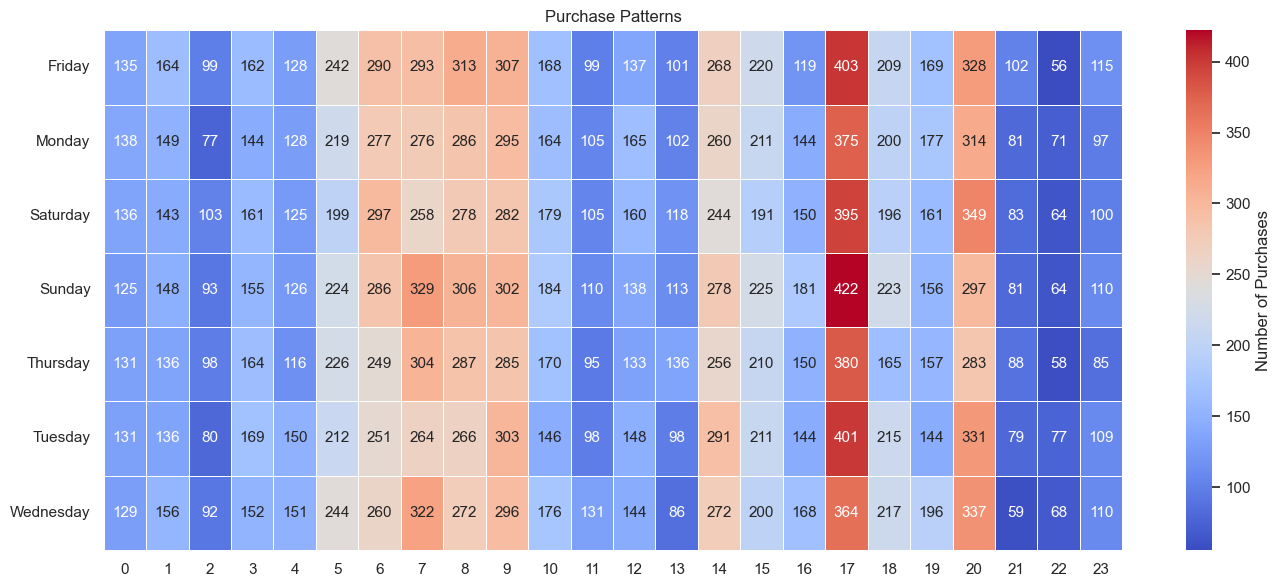

In [104]:
# Convert 'Purchase Time' to hour with explicit format
df['Purchase Hour'] = pd.to_datetime(df['Purchase Time'], format='%H:%M:%S', errors='coerce').dt.hour

# Create a pivot table
pivot_table = df.pivot_table(values='Transaction ID', 
                               index='Purchase Weekday', 
                               columns='Purchase Hour', 
                               aggfunc='count', 
                               fill_value=0)

# Ensure all values are integers
pivot_table = pivot_table.astype(int)

# Plot the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='d', cbar_kws={'label': 'Number of Purchases'}, linewidths=0.5)
plt.title('Purchase Patterns')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

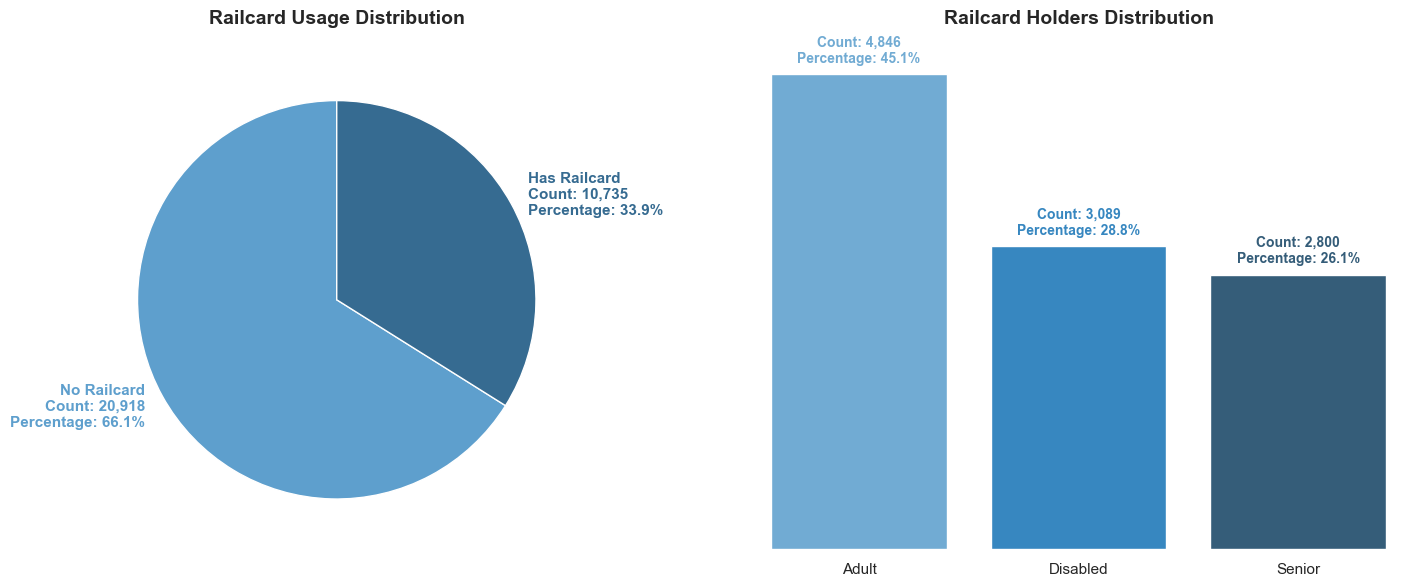

In [105]:
# Set style
sns.set_style("white")
plt.rcParams['figure.figsize'] = (15, 6)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# 1. PIE CHART - Railcard Usage Distribution
railcard_counts = df['Railcard'].fillna('None').value_counts()
no_railcard = railcard_counts.get('None', 0)
has_railcard = railcard_counts.drop('None', errors='ignore').sum()
railcard_usage = pd.Series([no_railcard, has_railcard], index=['No Railcard', 'Has Railcard'])

colors_pie = sns.color_palette("Blues_d", len(railcard_usage))

# Create pie chart with custom labels inside
wedges, texts = ax1.pie(
    railcard_usage.values,
    labels=railcard_usage.index,
    colors=colors_pie,
    startangle=90,
    textprops={'fontsize': 11, 'weight': 'bold'}
)

# Replace the default labels with custom ones (category name, count, and percentage)
for i, (wedge, label) in enumerate(zip(wedges, railcard_usage.index)):
    absolute = int(railcard_usage.values[i])
    percentage = (railcard_usage.values[i] / railcard_usage.sum()) * 100
    label_text = f'{label}\nCount: {absolute:,}\nPercentage: {percentage:.1f}%'
    # Replace the default label with the custom one
    texts[i].set_text(label_text)
    # Set the color of the label to match the wedge
    texts[i].set_color(wedge.get_facecolor())

ax1.set_title('Railcard Usage Distribution', fontsize=14, weight='bold', pad=20)

# 2. BAR CHART - Railcard Holders Distribution (excluding 'None')
railcard_types = df[df['Railcard'] != 'None']['Railcard'].value_counts()
colors_bar = sns.color_palette("Blues_d", len(railcard_types))

bars = ax2.bar(range(len(railcard_types)), railcard_types.values, color=colors_bar)

# Add labels on top of bars with matching colors
for i, (bar, value) in enumerate(zip(bars, railcard_types.values)):
    percentage = (value / railcard_types.sum()) * 100
    label = f'Count: {value:,}\nPercentage: {percentage:.1f}%'
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + max(railcard_types.values) * 0.02,
        label,
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold',
        color=bar.get_facecolor()
    )

# Remove spines, ticks, and borders
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(left=False, bottom=False)
ax2.set_xticks(range(len(railcard_types)))
ax2.set_xticklabels(railcard_types.index, fontsize=11)
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_title('Railcard Holders Distribution', fontsize=14, weight='bold', pad=20)
ax2.grid(False)

plt.tight_layout()
plt.show()

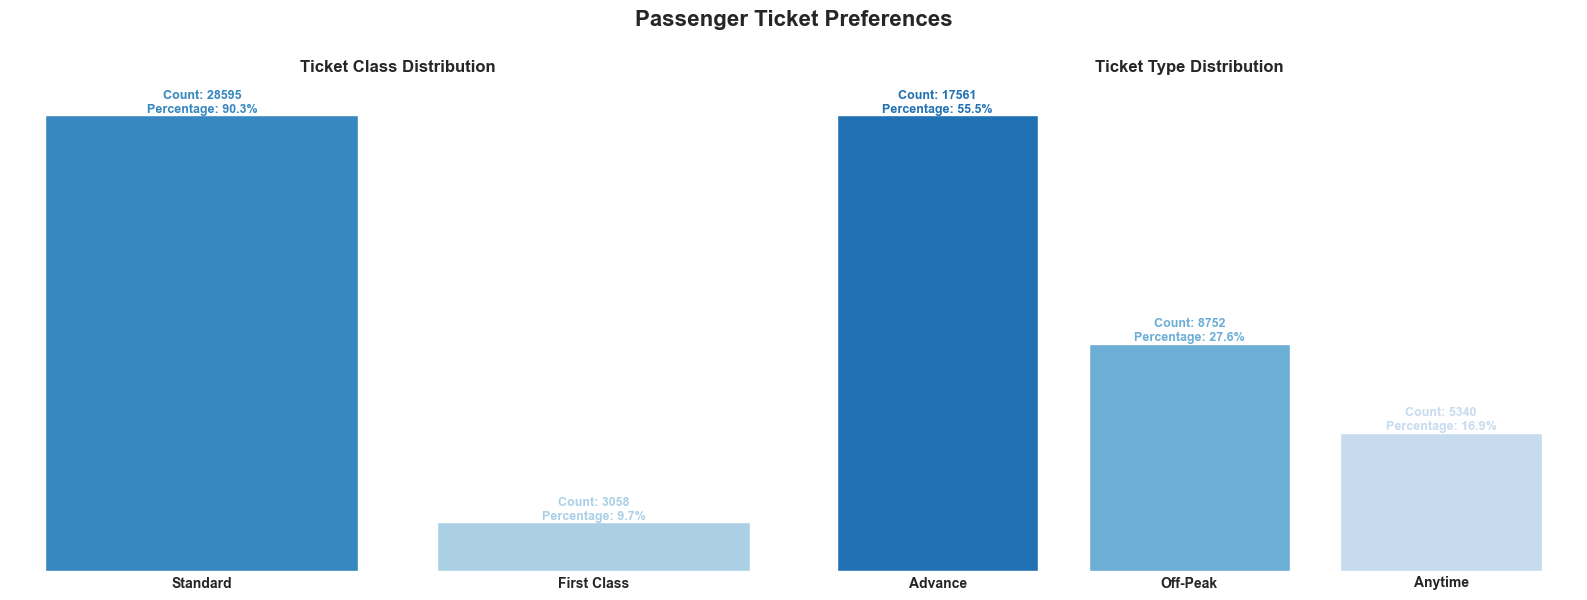

In [106]:
# Set theme and style for better aesthetics
sns.set_theme(style="white", palette="Blues", font="sans-serif")
plt.rcParams['font.size'] = 11
plt.rcParams['font.weight'] = 'normal'

ticket_class_counts = df['Ticket Class'].value_counts()
ticket_class_percent = df['Ticket Class'].value_counts(normalize=True) * 100
ticket_class_df = pd.DataFrame({
    'Ticket Class': ticket_class_counts.index,
    'Count': ticket_class_counts,
    'Percentage': ticket_class_percent
})

ticket_type_counts = df['Ticket Type'].value_counts()
ticket_type_percent = df['Ticket Type'].value_counts(normalize=True) * 100
ticket_type_df = pd.DataFrame({
    'Ticket Type': ticket_type_counts.index,
    'Count': ticket_type_counts,
    'Percentage': ticket_type_percent
})

# Create figure with 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Passenger Ticket Preferences', fontsize=16, fontweight='bold', y=0.995)

# Data and titles for each subplot
data_list = [
    (ticket_class_df, 'Ticket Class', 'Ticket Class Distribution', ax1),
    (ticket_type_df, 'Ticket Type', 'Ticket Type Distribution', ax2)
]

# Plot each category
for df_data, col_name, title, ax in data_list:
    # Generate colors based on number of categories
    colors = sns.color_palette("Blues_r", n_colors=len(df_data))
    
    # Use matplotlib bar instead of seaborn
    bars = ax.bar(range(len(df_data)), df_data['Count'], color=colors)
    
    # Add count and percentage text on bars
    for idx, row in enumerate(df_data.itertuples()):
        count = row.Count
        percent = row.Percentage
        
        ax.text(
            idx, 
            count,
            f"Count: {count}\nPercentage: {percent:.1f}%", 
            ha='center', 
            va='bottom',
            fontsize=9,
            fontweight='bold',
            color=colors[idx]  # Match bar color
        )
    
    # Remove y-axis, ticks, and borders
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Set x-axis ticks and labels properly
    ax.set_xticks(range(len(df_data)))
    ax.set_xticklabels(df_data[col_name], rotation=0, fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', length=0)

    # Hide unnecessary spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Add title
    ax.set_title(title, fontsize=12, fontweight='bold', pad=15)

# Adjust layout to fit
plt.tight_layout()
plt.show()

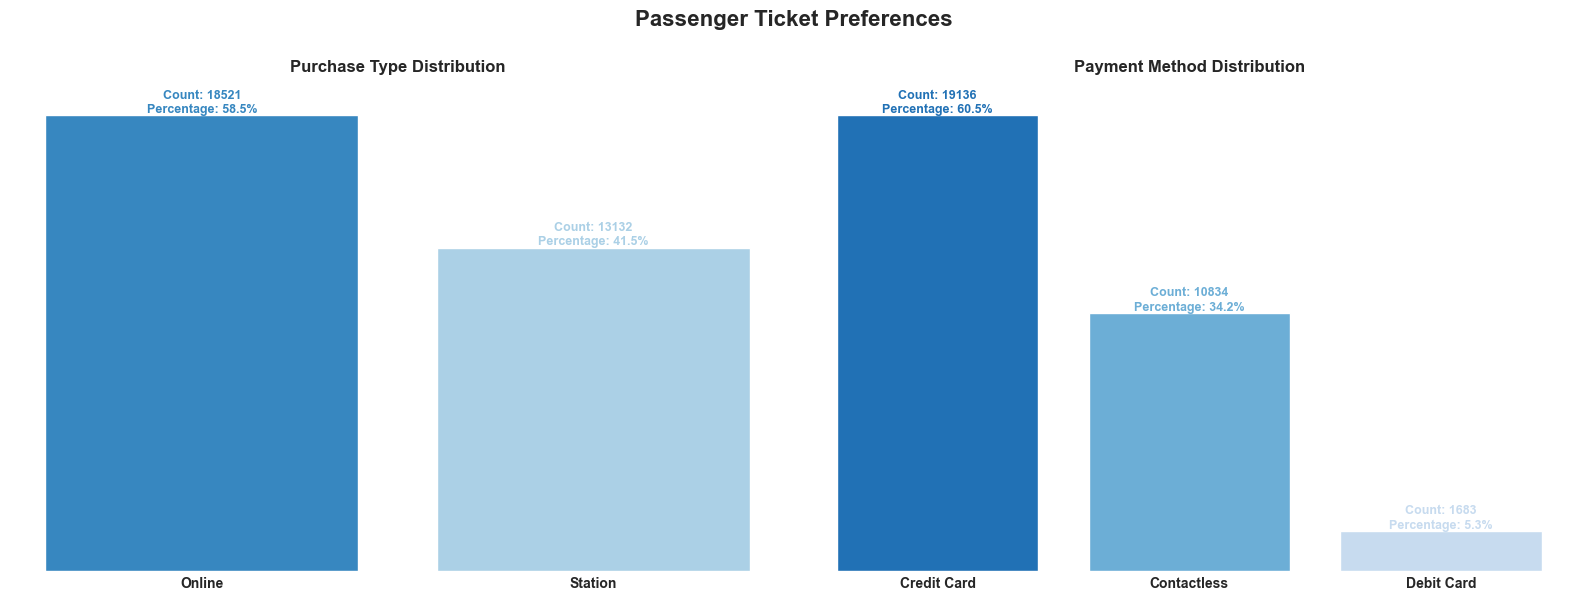

In [107]:
# Set theme and style for better aesthetics
sns.set_theme(style="white", palette="Blues", font="sans-serif")
plt.rcParams['font.size'] = 11
plt.rcParams['font.weight'] = 'normal'

payment_method_counts = df['Payment Method'].value_counts()
payment_method_percent = df['Payment Method'].value_counts(normalize=True) * 100
payment_method_df = pd.DataFrame({
    'Payment Method': payment_method_counts.index,
    'Count': payment_method_counts,
    'Percentage': payment_method_percent
})

purchase_type_counts = df['Purchase Type'].value_counts()
purchase_type_percent = df['Purchase Type'].value_counts(normalize=True) * 100
purchase_type_df = pd.DataFrame({
    'Purchase Type': purchase_type_counts.index,
    'Count': purchase_type_counts,
    'Percentage': purchase_type_percent
})

# Create figure with 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Passenger Ticket Preferences', fontsize=16, fontweight='bold', y=0.995)

# Data and titles for each subplot
data_list = [
    (purchase_type_df, 'Purchase Type', 'Purchase Type Distribution', ax1),
    (payment_method_df, 'Payment Method', 'Payment Method Distribution', ax2)
]

# Plot each category
for df_data, col_name, title, ax in data_list:
    # Generate colors based on number of categories
    colors = sns.color_palette("Blues_r", n_colors=len(df_data))
    
    # Use matplotlib bar instead of seaborn
    bars = ax.bar(range(len(df_data)), df_data['Count'], color=colors)
    
    # Add count and percentage text on bars
    for idx, row in enumerate(df_data.itertuples()):
        count = row.Count
        percent = row.Percentage
        
        ax.text(
            idx, 
            count,
            f"Count: {count}\nPercentage: {percent:.1f}%", 
            ha='center', 
            va='bottom',
            fontsize=9,
            fontweight='bold',
            color=colors[idx]  # Match bar color
        )
    
    # Remove y-axis, ticks, and borders
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Set x-axis ticks and labels properly
    ax.set_xticks(range(len(df_data)))
    ax.set_xticklabels(df_data[col_name], rotation=0, fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', length=0)

    # Hide unnecessary spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Add title
    ax.set_title(title, fontsize=12, fontweight='bold', pad=15)

# Adjust layout to fit
plt.tight_layout()
plt.show()

# Revenue Analysis

In [108]:
print(f"Total Revenue before Refund: £{df['Price'].sum():,.2f}")
print(f"Total Revenue after Refund: £{df[df['Refund Request'] == 'No']['Price'].sum():,.2f}")
print(f"Total Revenue loss: £{df[df['Refund Request'] == 'Yes']['Price'].sum():,.2f}")

Total Revenue before Refund: £741,921.00
Total Revenue after Refund: £703,219.00
Total Revenue loss: £38,702.00


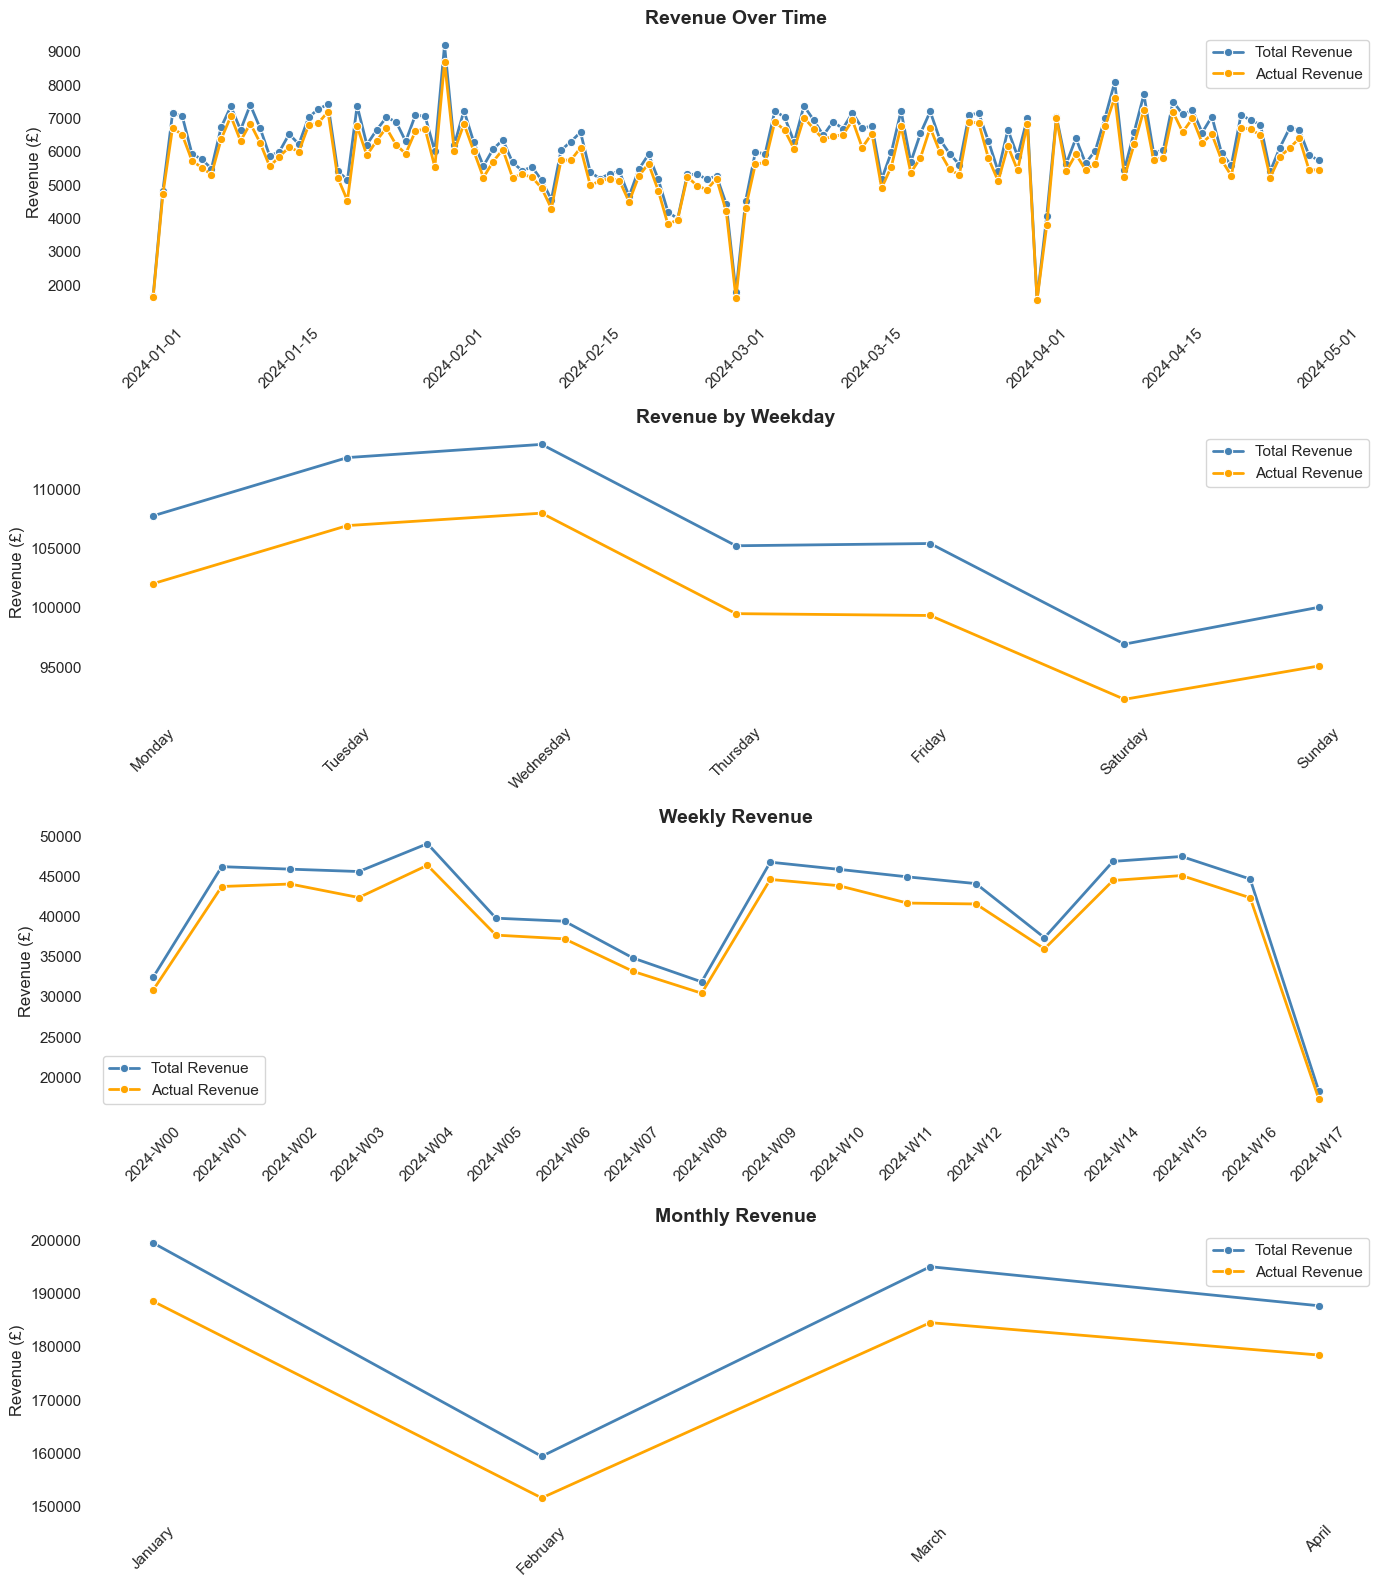

In [109]:
# Ensure 'Departure Timestamp' is in datetime format
df['Departure Timestamp'] = pd.to_datetime(df['Departure Timestamp'])

# Extract the day and month from the 'Departure Timestamp'
df['Departure Week'] = df['Departure Timestamp'].dt.strftime('%Y-W%U')
df['Departure Month'] = df['Departure Timestamp'].dt.strftime('%B')
df['Departure Weekday'] = df['Departure Timestamp'].dt.strftime('%A')

# Create a new column for refund amount (assuming refund is 100% of ticket price)
df['Refund Amount'] = df.apply(lambda row: row['Price'] if row['Refund Request'] == 'Yes' else 0, axis=1)

# Group by date and calculate total revenue and actual revenue
revenue_over_time = df.groupby(df['Departure Timestamp'].dt.date).agg(
    Total_Revenue=('Price', 'sum'),
    Refund_Amount=('Refund Amount', 'sum'),
    Actual_Revenue=('Price', lambda x: x.sum() - df.loc[x.index, 'Refund Amount'].sum())
).reset_index()

# Group by 'Departure Week' and calculate total and actual revenue
weekly_revenue = df.groupby('Departure Week').agg(
    Total_Revenue=('Price', 'sum'),
    Refund_Amount=('Refund Amount', 'sum'),
    Actual_Revenue=('Price', lambda x: x.sum() - df.loc[x.index, 'Refund Amount'].sum())
).reset_index()

# Group by 'Departure Month' and calculate total and actual revenue
monthly_revenue = df.groupby('Departure Month').agg(
    Total_Revenue=('Price', 'sum'),
    Refund_Amount=('Refund Amount', 'sum'),
    Actual_Revenue=('Price', lambda x: x.sum() - df.loc[x.index, 'Refund Amount'].sum())
).reset_index()

# Group by 'Departure Weekday' and calculate total and actual revenue
weekday_revenue = df.groupby('Departure Weekday').agg(
    Total_Revenue=('Price', 'sum'),
    Refund_Amount=('Refund Amount', 'sum'),
    Actual_Revenue=('Price', lambda x: x.sum() - df.loc[x.index, 'Refund Amount'].sum())
).reset_index()

# Sort by timestamp
revenue_over_time['Departure Timestamp'] = pd.to_datetime(revenue_over_time['Departure Timestamp'])

# Sort the months in chronological order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

monthly_revenue['Departure Month'] = pd.Categorical(
    monthly_revenue['Departure Month'], categories=month_order, ordered=True
)
monthly_revenue = monthly_revenue.sort_values('Departure Month')

# Sort the weekdays in chronological order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_revenue['Departure Weekday'] = pd.Categorical(
    weekday_revenue['Departure Weekday'], categories=weekday_order, ordered=True
)
weekday_revenue = weekday_revenue.sort_values('Departure Weekday')

# Plot all four revenue metrics
plt.figure(figsize=(14, 16))

# Plot total and actual revenue over time (first subplot)
ax0 = plt.subplot(4, 1, 1)
sns.lineplot(x='Departure Timestamp', y='Total_Revenue', data=revenue_over_time, marker='o', color='steelblue', linewidth=2, label='Total Revenue')
sns.lineplot(x='Departure Timestamp', y='Actual_Revenue', data=revenue_over_time, marker='o', color='orange', linewidth=2, label='Actual Revenue')
plt.title('Revenue Over Time', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Revenue (£)')
date_format = DateFormatter("%Y-%m-%d")
ax0.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)
ax0.legend()
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.grid(False)

# Plot weekday total and actual revenue
ax1 = plt.subplot(4, 1, 2)
sns.lineplot(x='Departure Weekday', y='Total_Revenue', data=weekday_revenue, marker='o', color='steelblue', linewidth=2, label='Total Revenue')
sns.lineplot(x='Departure Weekday', y='Actual_Revenue', data=weekday_revenue, marker='o', color='orange', linewidth=2, label='Actual Revenue')
plt.title('Revenue by Weekday', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Revenue (£)')
plt.xticks(rotation=45)
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.grid(False)

# Plot weekly total and actual revenue
ax2 = plt.subplot(4, 1, 3)
sns.lineplot(x='Departure Week', y='Total_Revenue', data=weekly_revenue, marker='o', color='steelblue', linewidth=2, label='Total Revenue')
sns.lineplot(x='Departure Week', y='Actual_Revenue', data=weekly_revenue, marker='o', color='orange', linewidth=2, label='Actual Revenue')
plt.title('Weekly Revenue', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Revenue (£)')
plt.xticks(rotation=45)
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.grid(False)

# Plot monthly total and actual revenue
ax3 = plt.subplot(4, 1, 4)
sns.lineplot(x='Departure Month', y='Total_Revenue', data=monthly_revenue, marker='o', color='steelblue', linewidth=2, label='Total Revenue')
sns.lineplot(x='Departure Month', y='Actual_Revenue', data=monthly_revenue, marker='o', color='orange', linewidth=2, label='Actual Revenue')
plt.title('Monthly Revenue', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Revenue (£)')
plt.xticks(rotation=45)
ax3.legend()
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.grid(False)



plt.tight_layout()
plt.show()

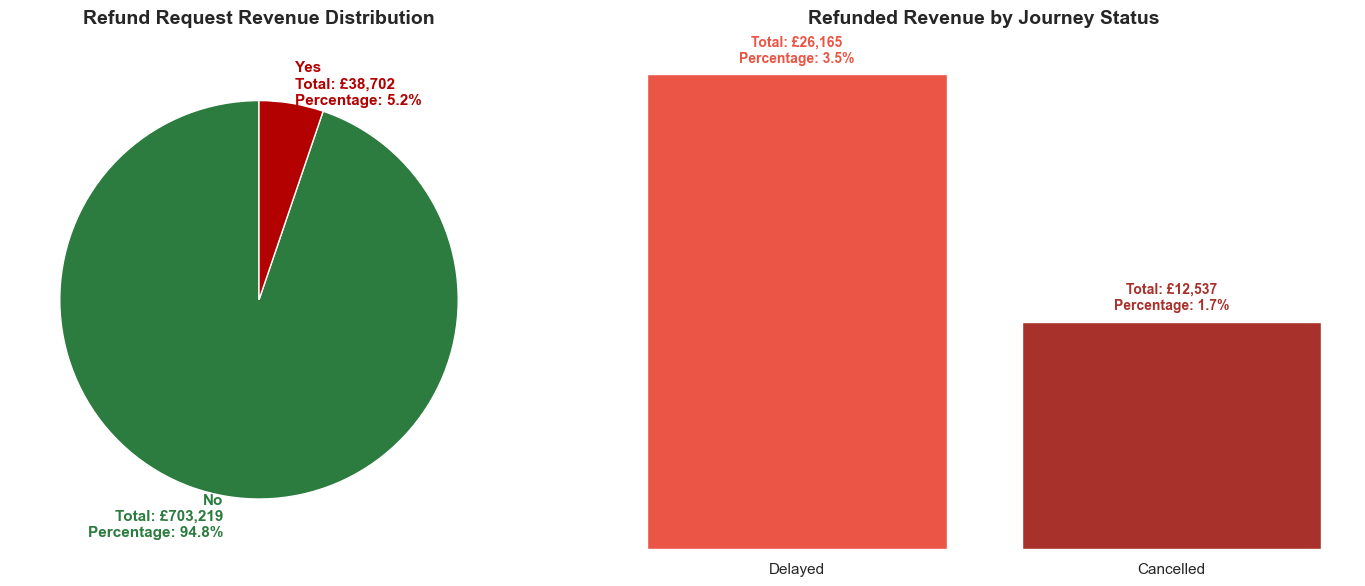

In [110]:
# Set style
sns.set_style("white")
plt.rcParams['figure.figsize'] = (15, 6)

# Calculate refund statistics
total_revenue = df['Price'].sum()
refund_revenue = df.groupby('Refund Request')['Price'].sum()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# 1. PIE CHART - Refund Request Distribution
colors_pie = ['#2c7b3f', '#b30000']  # Green for No, Red for Yes

# Create pie chart with custom labels inside
wedges, texts = ax1.pie(
    refund_revenue.values,
    labels=refund_revenue.index,
    colors=colors_pie,
    startangle=90,
    textprops={'fontsize': 11, 'weight': 'bold'}
)

# Replace the default labels with custom ones (category name, revenue, and percentage)
for i, (wedge, label) in enumerate(zip(wedges, refund_revenue.index)):
    revenue = int(refund_revenue.values[i])
    percentage = (refund_revenue.values[i] / refund_revenue.sum()) * 100
    label_text = f'{label}\nTotal: £{revenue:,}\nPercentage: {percentage:.1f}%'
    # Replace the default label with the custom one
    texts[i].set_text(label_text)
    # Set the color of the label to match the wedge
    texts[i].set_color(wedge.get_facecolor())

ax1.set_title('Refund Request Revenue Distribution', fontsize=14, weight='bold', pad=20)

# 2. BAR CHART - Refund Count by Journey Status
refund_by_status = df[df['Refund Request'] == 'Yes'].groupby('Journey Status')['Price'].sum().sort_values(ascending=False)
colors_bar = sns.color_palette("Reds_d", len(refund_by_status))

bars = ax2.bar(range(len(refund_by_status)), refund_by_status.values, color=colors_bar)

# Add labels on top of bars with matching colors
for i, (bar, value) in enumerate(zip(bars, refund_by_status.values)):
    percentage = (value / total_revenue) * 100
    label = f'Total: £{value:,}\nPercentage: {percentage:.1f}%'
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + max(refund_by_status.values) * 0.02,
        label,
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold',
        color=bar.get_facecolor()
    )

# Remove spines, ticks, and borders
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(left=False, bottom=False)
ax2.set_xticks(range(len(refund_by_status)))
ax2.set_xticklabels(refund_by_status.index, fontsize=11)
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_title('Refunded Revenue by Journey Status', fontsize=14, weight='bold', pad=20)
ax2.grid(False)

plt.tight_layout()
plt.show()

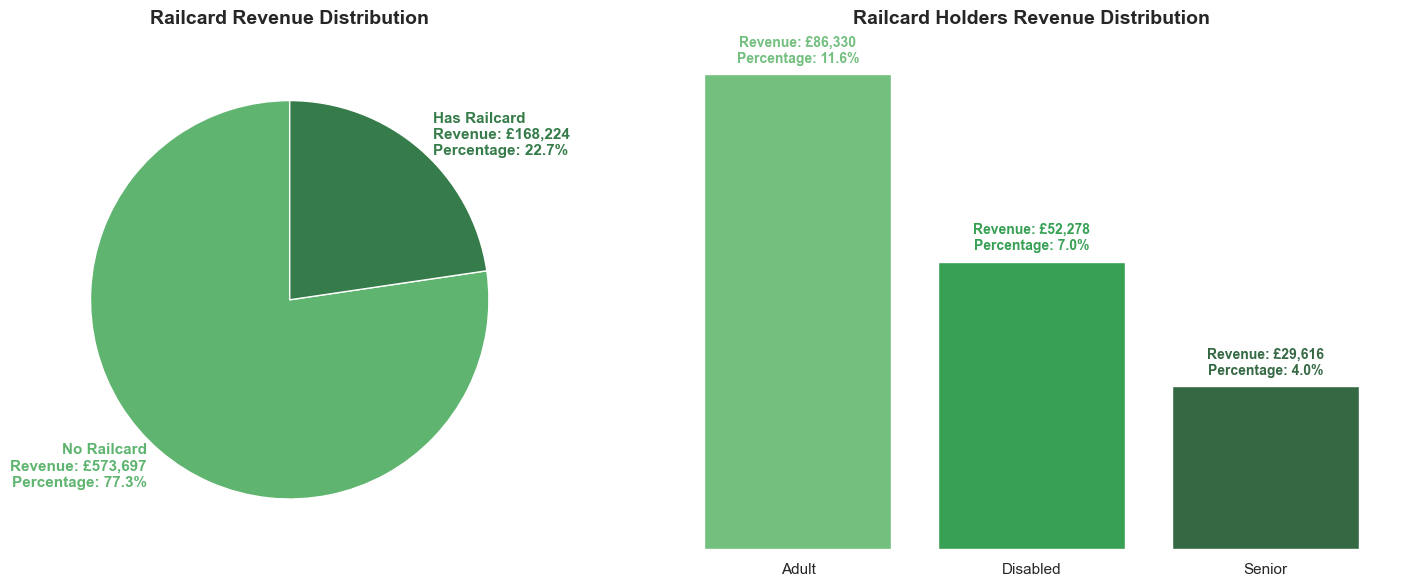

In [111]:
# Set style
sns.set_style("white")
plt.rcParams['figure.figsize'] = (15, 6)

# Replace NaN with 'None' in the 'Railcard' column
df['Railcard'] = df['Railcard'].fillna('None')

# Calculate total revenue
total_revenue = df['Price'].sum()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# 1. PIE CHART - Railcard Revenue Distribution
railcard_revenue = df.groupby('Railcard')['Price'].sum()
no_railcard = railcard_revenue.get('None', 0)
has_railcard = railcard_revenue.drop('None', errors='ignore').sum()
railcard_usage = pd.Series([no_railcard, has_railcard], index=['No Railcard', 'Has Railcard'])

colors_pie = sns.color_palette("Greens_d", len(railcard_usage))


# Create pie chart with custom labels inside
wedges, texts = ax1.pie(
    railcard_usage.values,
    labels=railcard_usage.index,
    colors=colors_pie,
    startangle=90,
    textprops={'fontsize': 11, 'weight': 'bold'}
)

# Replace the default labels with custom ones (category name, revenue, and percentage)
for i, (wedge, label) in enumerate(zip(wedges, railcard_usage.index)):
    revenue = int(railcard_usage.values[i])
    percentage = (railcard_usage.values[i] / railcard_usage.sum()) * 100
    label_text = f'{label}\nRevenue: £{revenue:,}\nPercentage: {percentage:.1f}%'
    # Replace the default label with the custom one
    texts[i].set_text(label_text)
    # Set the color of the label to match the wedge
    texts[i].set_color(wedge.get_facecolor())

ax1.set_title('Railcard Revenue Distribution', fontsize=14, weight='bold', pad=20)

# 2. BAR CHART - Railcard Holders Revenue Distribution (excluding 'None')
railcard_types_revenue = df[df['Railcard'] != 'None'].groupby('Railcard')['Price'].sum()
colors_bar = sns.color_palette("Greens_d", len(railcard_types_revenue))

bars = ax2.bar(range(len(railcard_types_revenue)), railcard_types_revenue.values, color=colors_bar)

# Add labels on top of bars with matching colors
for i, (bar, value) in enumerate(zip(bars, railcard_types_revenue.values)):
    percentage = (value / total_revenue) * 100
    label = f'Revenue: £{value:,}\nPercentage: {percentage:.1f}%'
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + max(railcard_types_revenue.values) * 0.02,
        label,
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold',
        color=bar.get_facecolor()
    )

# Remove spines, ticks, and borders
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(left=False, bottom=False)
ax2.set_xticks(range(len(railcard_types_revenue)))
ax2.set_xticklabels(railcard_types_revenue.index, fontsize=11)
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_title('Railcard Holders Revenue Distribution', fontsize=14, weight='bold', pad=20)
ax2.grid(False)

plt.tight_layout()
plt.show()

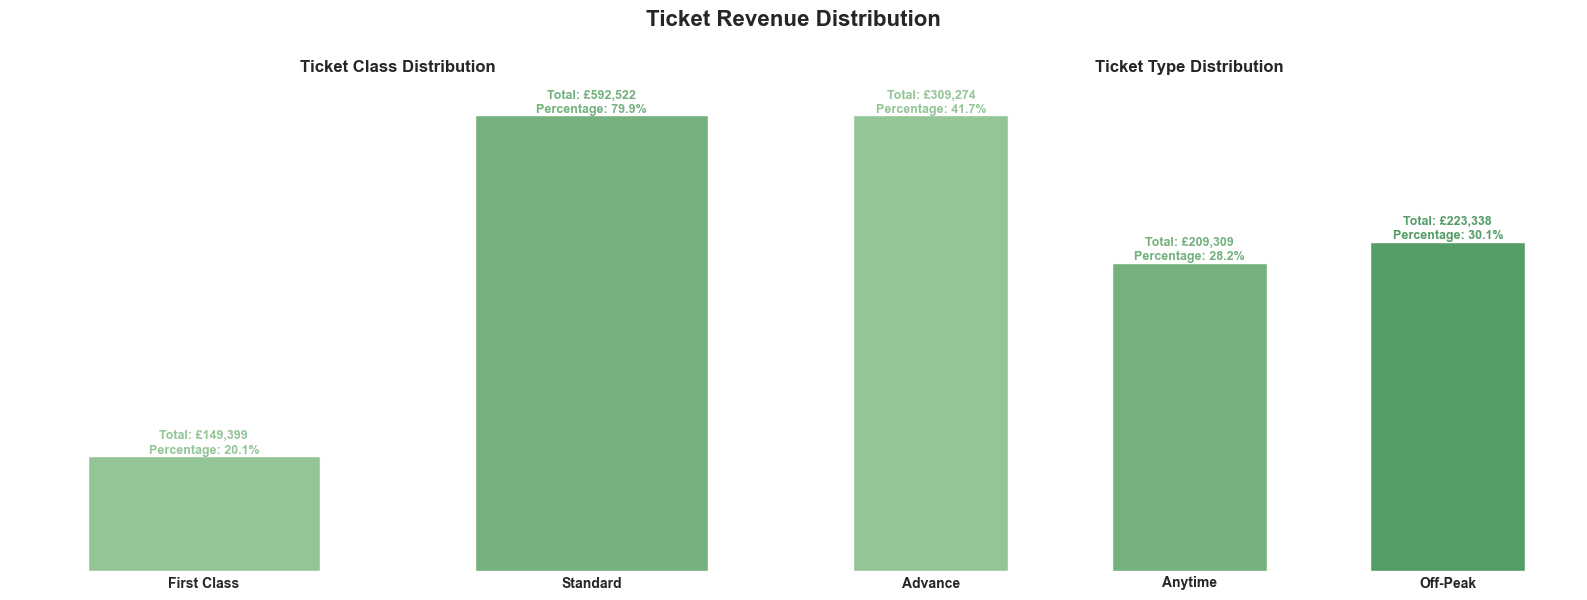

In [112]:
# Set theme and style for better aesthetics
sns.set_theme(style="white", palette="Greens_d", font="sans-serif")
plt.rcParams['font.size'] = 11
plt.rcParams['font.weight'] = 'normal'

# Calculate total revenue by Ticket Type
ticket_type_revenue = df.groupby(['Ticket Type'])['Price'].sum().reset_index()
ticket_type_revenue.columns = ['Ticket Type', 'Total Revenue']
ticket_type_revenue['Percentage'] = (ticket_type_revenue['Total Revenue'] / 
                                     ticket_type_revenue['Total Revenue'].sum()) * 100
ticket_type_df = pd.DataFrame({
    'Ticket Type': ticket_type_revenue['Ticket Type'],
    'Total': ticket_type_revenue['Total Revenue'],
    'Percentage': ticket_type_revenue['Percentage']
})

# Calculate total revenue by Ticket Class
ticket_class_revenue = df.groupby(['Ticket Class'])['Price'].sum().reset_index()
ticket_class_revenue.columns = ['Ticket Class', 'Total Revenue']
ticket_class_revenue['Percentage'] = (ticket_class_revenue['Total Revenue'] / 
                                     ticket_class_revenue['Total Revenue'].sum()) * 100
ticket_class_df = pd.DataFrame({
    'Ticket Class': ticket_class_revenue['Ticket Class'],
    'Total': ticket_class_revenue['Total Revenue'],
    'Percentage': ticket_class_revenue['Percentage']
})

# Create figure with 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Ticket Revenue Distribution', fontsize=16, fontweight='bold', y=0.995)

# Data and titles for each subplot
data_list = [
    (ticket_class_df, 'Ticket Class', 'Ticket Class Distribution', ax1),
    (ticket_type_df, 'Ticket Type', 'Ticket Type Distribution', ax2)
]

# Plot each category
for df_data, col_name, title, ax in data_list:
    # Plot the bar chart
    sns.barplot(
        x=col_name, 
        y='Total', 
        data=df_data, 
        hue=col_name,  
        legend=False,
        ax=ax,
        width=0.6
    )
    
    # Add revenue and percentage text on bars
    for idx, row in enumerate(df_data.itertuples()):
        revenue = row.Total
        percent = row.Percentage
        
        # Get the color of the current bar
        bar_color = ax.patches[idx].get_facecolor()
        
        # Use the index to place the text at the correct position
        ax.text(
            idx, 
            revenue,  # Position at the top of the bar
            f"Total: £{revenue:,.0f}\nPercentage: {percent:.1f}%", 
            ha='center', 
            va='bottom',  # Align text bottom to bar top
            color=bar_color,  # Match bar color
            fontsize=9,
            fontweight='bold'
        )
    
    # Remove y-axis, ticks, and borders
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Set x-axis ticks and labels properly
    ax.set_xticks(range(len(df_data)))
    ax.set_xticklabels(df_data[col_name], rotation=0, fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', length=0)

    # Hide unnecessary spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Add title
    ax.set_title(title, fontsize=12, fontweight='bold', pad=15)

# Adjust layout to fit
plt.tight_layout()
plt.show()

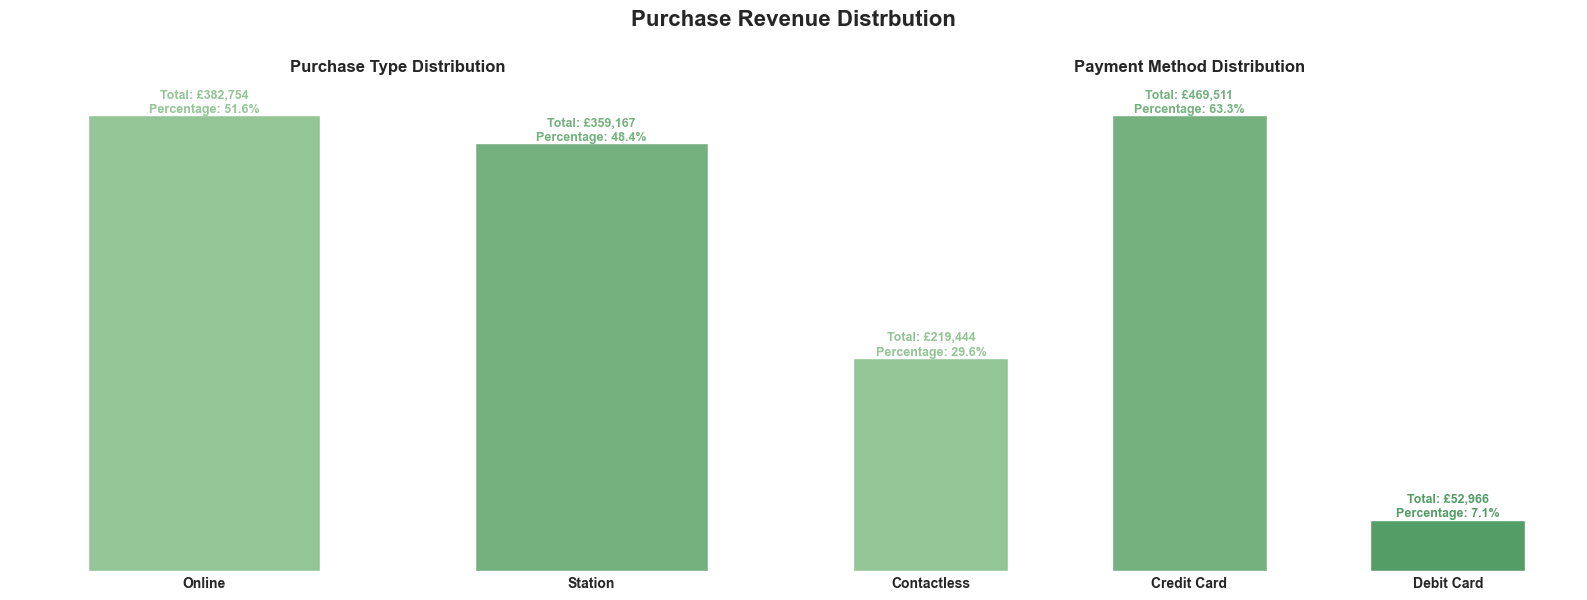

In [113]:
# Set theme and style for better aesthetics
sns.set_theme(style="white", palette="Greens_d", font="sans-serif")
plt.rcParams['font.size'] = 11
plt.rcParams['font.weight'] = 'normal'

# Calculate total revenue by Purchase Type
purchase_type_revenue = df.groupby(['Purchase Type'])['Price'].sum().reset_index()
purchase_type_revenue.columns = ['Purchase Type', 'Total Revenue']
purchase_type_revenue['Percentage'] = (purchase_type_revenue['Total Revenue'] / 
                                     purchase_type_revenue['Total Revenue'].sum()) * 100
purchase_type_df = pd.DataFrame({
    'Purchase Type': purchase_type_revenue['Purchase Type'],
    'Total': purchase_type_revenue['Total Revenue'],
    'Percentage': purchase_type_revenue['Percentage']
})

# Calculate total revenue by Payment Method
payment_method_revenue = df.groupby(['Payment Method'])['Price'].sum().reset_index()
payment_method_revenue.columns = ['Payment Method', 'Total Revenue']
payment_method_revenue['Percentage'] = (payment_method_revenue['Total Revenue'] / 
                                     payment_method_revenue['Total Revenue'].sum()) * 100
payment_method_df = pd.DataFrame({
    'Payment Method': payment_method_revenue['Payment Method'],
    'Total': payment_method_revenue['Total Revenue'],
    'Percentage': payment_method_revenue['Percentage']
})

# Create figure with 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Purchase Revenue Distrbution', fontsize=16, fontweight='bold', y=0.995)

# Data and titles for each subplot
data_list = [
    (purchase_type_df, 'Purchase Type', 'Purchase Type Distribution', ax1),
    (payment_method_df, 'Payment Method', 'Payment Method Distribution', ax2)
]

# Plot each category
for df_data, col_name, title, ax in data_list:
    # Plot the bar chart
    sns.barplot(
        x=col_name, 
        y='Total', 
        data=df_data, 
        hue=col_name,  
        legend=False,
        ax=ax,
        width=0.6
    )
    
    # Add revenue and percentage text on bars
    for idx, row in enumerate(df_data.itertuples()):
        revenue = row.Total
        percent = row.Percentage
        
        # Get the color of the current bar
        bar_color = ax.patches[idx].get_facecolor()
        
        # Use the index to place the text at the correct position
        ax.text(
            idx, 
            revenue,  # Position at the top of the bar
            f"Total: £{revenue:,.0f}\nPercentage: {percent:.1f}%", 
            ha='center', 
            va='bottom',  # Align text bottom to bar top
            color=bar_color,  # Match bar color
            fontsize=9,
            fontweight='bold'
        )
    
    # Remove y-axis, ticks, and borders
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Set x-axis ticks and labels properly
    ax.set_xticks(range(len(df_data)))
    ax.set_xticklabels(df_data[col_name], rotation=0, fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', length=0)

    # Hide unnecessary spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Add title
    ax.set_title(title, fontsize=12, fontweight='bold', pad=15)

# Adjust layout to fit
plt.tight_layout()
plt.show()